# AER for HFIR Cycle 502

***
## Basic constants and functions
***

In [1]:
import numpy as np
import sympy as sym
import scipy as sc
import matplotlib.pyplot as plt
import mcstasscript as ms
import scienceplots
import time, math, os
from scipy.optimize import curve_fit
from scipy.signal import hilbert,convolve
from scipy.fft import fft,fftfreq,ifft
from scipy.integrate import quad,simpson
from matplotlib.animation import FuncAnimation, PillowWriter
from itertools import islice

plt.style.use(['science', 'notebook', 'grid', 'default', 'bright'])
plot_height = 8
plot_width = plot_height*1.618

SMALL_SIZE,MEDIUM_SIZE,BIGGER_SIZE = 20,30,40
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('axes', titlesize=BIGGER_SIZE)    # actually gets title font size (glitch in matplotlib?)
plt.rcParams.update({'axes.grid':True})

if False: #Additions to latex preamble for matplotlib:
    plt.rc('text', usetex=True)
    plt.rc('text.latex', preamble=r'\usepackage{amsmath,amsthm,amssymb,amsfonts,braket,siunitx}')
    plt.rcParams["font.family"] = "Computer Modern Roman"
sym.init_printing()

xp = 1/np.sqrt(2)*np.array([[1],[1]]) #spin states
xm = 1/np.sqrt(2)*np.array([[1],[-1]])
yp = 1/np.sqrt(2)*np.array([[1],[1j]])
ym = 1/np.sqrt(2)*np.array([[1],[-1j]])
zp = np.array([[1],[0]])
zm = np.array([[0],[1]])

sx = np.array([[0,1],[1,0]]) #Pauli operators
sy = np.array([[0,-1j],[1j,0]])
sz = np.array([[1,0],[0,-1]])

G = -1.832471e8    #gyromagnetic ratio of neutron (rad/T/m^2)
M = 1.674927e-27    #mass of neutron (kg)
HBAR = 1.054571e-34    #plancks constant (kg m^2/s)
CL = G/(HBAR*2*np.pi)*M*1e-10    #Larmor phase constant (T^-1 m^-1 AA^-1)

In [2]:
def rebin(data,new_shape):
    """Rebins 2D data by taking average."""
    sh = new_shape[0],data.shape[0]//new_shape[0],new_shape[1],data.shape[1]//new_shape[1]
    return data.reshape(sh).mean(3).mean(1)

def get_SS_focus(harm,Ls,res,ml,a,L):
    """Returns SESANS magnetic field focuing condtion (T)."""
    return 2*np.pi*harm*Ls/(res/1e3)/(CL*lam*a*(L[1] - L[0]))

def cos(x,amp,freq,phase,shim):
    """Simple cosine with shim."""
    return amp*np.cos(x*freq + phase) + shim

def pol_sc(x,A,B,freq):
    """Linear combination of sine and cosine."""
    return A*np.cos(x*freq) + B*np.sin(x*freq)

def quad_cos(x,amp,freq,qfreq,phase,shim):
    """Cosine with quadratic frequency and shim."""
    return amp*np.cos(x*freq + x**2*qfreq + phase) + shim

def g_cos(x,amp,freq,phase,shim,mean,sigma):
    """Cosine with Gaussian envelope and shim."""
    return amp*np.exp(-(x - mean)**2/2/sigma**2)*np.cos(x*freq + phase) + shim

def quad(x,a,b,c):
    """Returns quadratic for peak fitting."""
    return a*x**2 + b*x + c

def sample_factor(x,r,ls,ld):
    """Returns tupule of sample seen by pixel x."""
    return -r/2 - (1 -ls/ld)*x, r/2 - (1 -ls/ld)*x

In [3]:
I1,I2,I3,I4,x,phi,theta = sym.symbols('I_1,I_2,I_3,I_4,x,phi,theta', real=True)
L1,L2,L3,L4,a,b,lam,delta = sym.symbols('L_1,L_2,L_3,L_4,a,b,lambda,delta', real=True, positive=True)
larm = sym.symbols('c_L', real=True, negative=True)
b=a

A = 5e-3 #in Tesla
B = 5e-3 #in Tesla

def MWP(a,b,I,x,phi,inv=False):
    """Field integral from MWP."""
    if inv: a = -a
    return I*(a*x + b*x*phi)

def AER(L1,L2,I1,I2,focus_SS=False):
    """Field integral with option focusing conditions."""
    result = MWP(a,b,I1,x-L1*phi,phi) + MWP(a,b,I2,x-L2*phi,phi)
    if focus_SS: result = result.subs(I2,-I1)
    return result.expand().collect([a,b]).simplify() 

def double_AER(L1,L2,L3,L4,I1,I2,I3,I4,focus_SS=False):
    """Field integral with option focusing conditions."""
    result = MWP(a,b,I1,x-L1*phi,phi) + MWP(a,b,I2,x-L2*phi,phi) + \
                MWP(a,b,I3,x-L3*phi,phi) + MWP(a,b,I4,x-L4*phi,phi)
    if focus_SS: result = result.subs([(I2,I1),(I3,-I1),(I4,-I1)])
    return result.expand().collect([a,b]).simplify() 

def SEMSANS_tilt(L1,L2,I1,I2,focus_SS=False):
    """Field integral with option focusing conditions."""
    result = MWP(a,b,I1,x*(sym.cos(theta)-phi*sym.sin(theta))-L1*phi,phi) + \
                MWP(a,b,I2,x*(sym.cos(theta)-phi*sym.sin(theta))-L2*phi,phi)
    if focus_SS: result = result.subs(I2,-I1*L1/L2)
    return result.expand().collect([a,b]).simplify() 

display(AER(L1,L2,I1,I2,focus_SS=True))
display(double_AER(L1,L2,L3,L4,I1,I2,I3,I4,focus_SS=True))
"""display(SEMSANS_tilt(L1,L2,I1,I2,focus_SS=False))
display(SEMSANS_tilt(L1,L2,I1,I2,focus_SS=True))
theta = 0
display(SEMSANS_tilt(L1,L2,I1,I2,focus_SS=True))
theta = sym.pi/4
display(SEMSANS_tilt(L1,L2,I1,I2,focus_SS=True))
theta = -sym.pi/4
display(SEMSANS_tilt(L1,L2,I1,I2,focus_SS=True))"""

'display(SEMSANS_tilt(L1,L2,I1,I2,focus_SS=False))\ndisplay(SEMSANS_tilt(L1,L2,I1,I2,focus_SS=True))\ntheta = 0\ndisplay(SEMSANS_tilt(L1,L2,I1,I2,focus_SS=True))\ntheta = sym.pi/4\ndisplay(SEMSANS_tilt(L1,L2,I1,I2,focus_SS=True))\ntheta = -sym.pi/4\ndisplay(SEMSANS_tilt(L1,L2,I1,I2,focus_SS=True))'

***
## Building the beamline
***

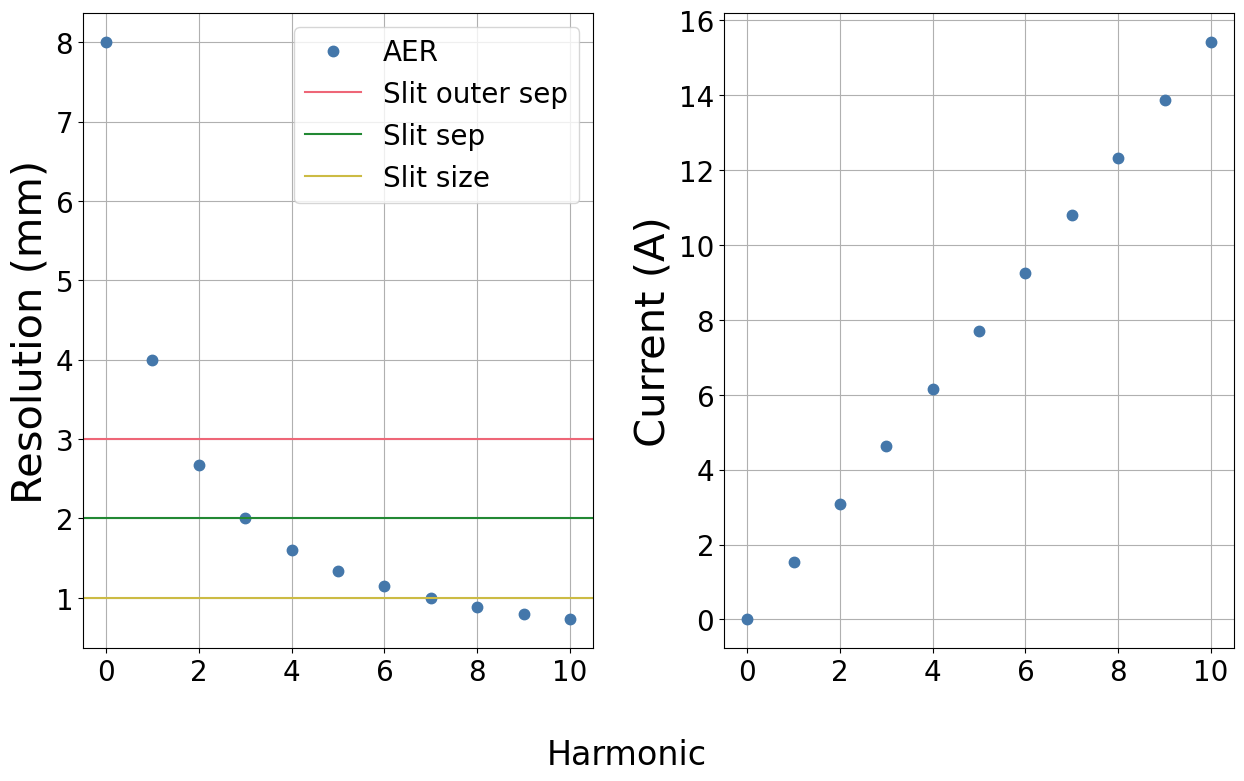

Wavelength: 5.5 p/m  0.055 (Angstroms)
Aperture diameter: 20.0 (mm)
Midpoint distances from MWP to detector: [1.9 1.5] (m)
Geometric resolution: 8.0 (mm) 

MWP currents for first and last harmonic: [ 1.541 15.414] (amps)
Polarizer axis: [1.0, 0.0, 0.0] 

Detector size: [10.0, 10.0] (mm)
[x,y] bin number: [100, 100]
[x,y] bin size: [0.1, 0.1] (mm) 



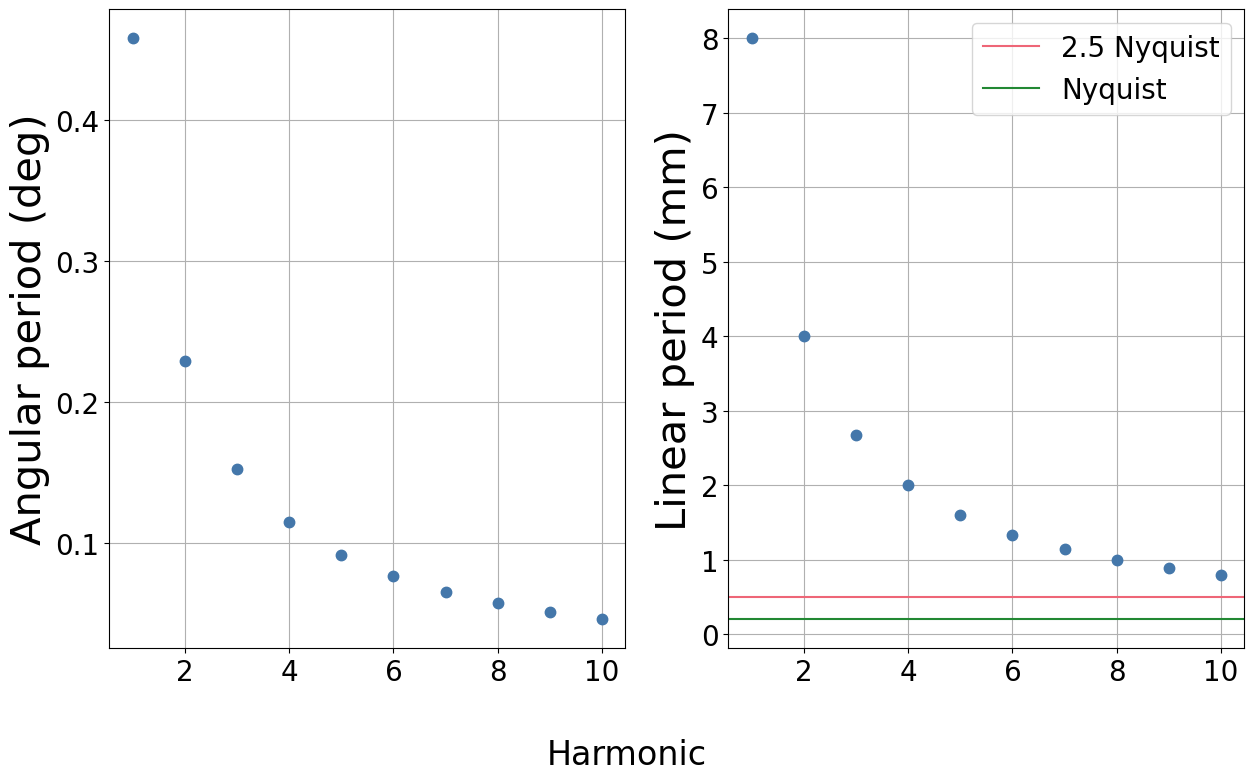

--------------------------------------------------------------------------------
double delta_lambda  = 0.055  // Wavelength spread [AA]
int    low_count     = 0      // if true flips analyzer direction [N/A]
int    all_off       = 0      // if true turns off all MWPs [N/A]
double cur1          = 0.0    // MWP1 current [Amps]
double cur2          = -0.0   // MWP2 current [Amps]
double BCG           = 0.0    // Center guide field [Gauss]
double polx          = 1.0    // x-component of polarizer [N/A]
double poly          = 0.0    // y-component of polarizer [N/A]
double polz          = 0.0    // z-component of polarizer [N/A]
--------------------------------------------------------------------------------
COMPONENT src = Source_sam(
  radius = 0.01, // [m]
  dist = 2.5, // [m]
  focus_xw = 0.01, // [m]
  focus_yh = 0.01, // [m]
  lambda0 = 5.5, // [AA]
  dlambda = delta_lambda, // [AA]
  I1 = 1000000000000000.0 // [1/(cm**2*sr)]
)
AT (0, 0, 0) RELATIVE origin
COMPONENT pol = Set_pol(
  

In [14]:
lam = 5.5  #wavelength (AA)
dl = lam*.01
ap_dia = 20.0 #aperature diameter (mm)

cg_gpa = 25.  #25 Gauss per amp for center guide field
strength = 2.5e-3 #T per amp, experimental
MWP_parm = {'FI0':0.,'a':strength*2,'b':strength*2,'c':0.0,'d':0.0}
MWP_dim = {'x':.02,'y':.02,'z':.1}
CG_dim = {'x':.02,'y':.02,'z':.3}
LG_parm = {'B0':0.0,'Bx':0.0,'By':0.0,'Bz':0.0}

MWP_sep, Lss, Ld = .4, 1.5, 2.5 #beamline parameters (m)
dists = {'pol':.0,'P1':.55,'CG':.65,'P2':.95,'ana':1.15,'sam':Lss,'det':Ld}
assert math.isclose(dists['P2'] - dists['P1'], MWP_sep,rel_tol=1e-2), 'Prisms too far apart!'
L = np.array([Ld-dists['P1']-MWP_dim['z']/2,Ld-dists['P2']-MWP_dim['z']/2])
L1, L2 = L  #naming the distances
Ls = Ld - Lss  #distance from sample to detector

slit_width,slit_hieght,slit_num,slit_offset = 1.,10.,11,.5 #mask parameters (mm)
slit_inner,slit_outer = 22.,40.

res = Ls / (dists['det'] / ap_dia) #geometric resolution (mm)
harms = np.arange(0,11)
currents = get_SS_focus(harms,Ls,res,lam,MWP_parm['a'],L)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(plot_width,plot_height))
ax1.plot(harms,res/(1+harms),'.',ms=15,label='AER')
ax1.axhline(y=3., label='Slit outer sep',color='C1')
ax1.axhline(y=2., label='Slit sep',color='C2')
ax1.axhline(y=1., label='Slit size',color='C3')
ax1.set(ylabel='Resolution (mm)')
ax2.plot(harms,currents,'.',ms=15)
ax2.set(ylabel='Current (A)')
ax1.legend()
fig.supxlabel("Harmonic")
plt.tight_layout()
plt.show()

print(f'Wavelength: {lam} p/m  {round(dl,3)} (Angstroms)')
print(f'Aperture diameter: {ap_dia} (mm)')
print(f'Midpoint distances from MWP to detector: {np.round(L,3)} (m)')
print(f'Geometric resolution: {round(res, 3)} (mm) \n')

c1 = get_SS_focus(harms,Ls,res,lam,MWP_parm['a'],L) #currents (amps)
c2 = -c1
c_CG = 0.
print(f'MWP currents for first and last harmonic: {np.round([c1[1],c1[-1]],3)} (amps)')

per_rad = abs(2*np.pi/(CL*lam*MWP_parm['a']*(c1[1:]*L1 + c2[1:]*L2)))
per_lin = np.round([res/i for i in harms[1:]],3)
det_res = .4 #Anger camera bin size (mm)
#det_res = .1 #Timepix3 camera bin size (mm)

pol_dir = [1,0,0] #direction of polarizer (x,y,z)
pol_dir = [i/np.sqrt(sum([j**2 for j in pol_dir])) for i in pol_dir]
print(f'Polarizer axis: {[round(i,3) for i in pol_dir]} \n')

ff = .5
det_x,det_y = ff*ap_dia,ff*ap_dia
#bin_x,bin_y = int(det_x/det_res),int(det_y/det_res)
bin_x,bin_y = 100,100
print(f'Detector size: {[round(i,3) for i in [det_x,det_y]]} (mm)')
print(f'[x,y] bin number: {[round(i,3) for i in [bin_x,bin_y]]}')
print(f'[x,y] bin size: {[round(i,3) for i in [det_x/bin_x,det_y/bin_y]]} (mm) \n')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(plot_width,plot_height))
ax1.plot(harms[1:],per_rad*180/np.pi,'.',ms=15)
ax1.set(ylabel='Angular period (deg)')
ax2.plot(harms[1:],per_lin,'.',ms=15)
ax2.axhline(y=5*det_x/bin_x, label='2.5 Nyquist',color='C1')
ax2.axhline(y=2*det_x/bin_x, label='Nyquist',color='C2')
ax2.set(ylabel='Linear period (mm)')
ax2.legend()
fig.supxlabel("Harmonic")
plt.tight_layout()
plt.show()

sam_ang,sam_offset = 0.0,0.0 #angular and linear offset (degs and mm)

#hdiv_pre_det, vdiv_pre_det = '', ''
hdiv_post_det, vdiv_post_det = 'hdiv limits=[-.25,.25] bins=128', 'vdiv limits=[-.25,.25], bins=128'
hdiv_pre_file, vdiv_pre_file = "\"AER_hdiv_pre.dat\"", "\"AER_vdiv_pre.dat\""
hdiv_post_file, vdiv_post_file = "\"AER_hdiv_post.dat\"", "\"AER_vdiv_post.dat\""
twoD_file = "\"AER_2D.dat\""

print("-"*80)     #Start of instrument definition
AER = ms.McStas_instr('AER_HFIR_2023', author = 'Sam McKay', origin = 'Indiana University')
delta_lambda = AER.add_parameter("double", "delta_lambda", value = dl, comment="Wavelength spread [AA]")
low_count = AER.add_parameter("int", "low_count", value = 0, comment="if true flips analyzer direction [N/A]")
all_off = AER.add_parameter("int", "all_off", value = 0, comment="if true turns off all MWPs [N/A]")
cur1 = AER.add_parameter("double", "cur1", value = c1[0], comment="MWP1 current [Amps]")
cur2 = AER.add_parameter("double", "cur2", value = c2[0], comment="MWP2 current [Amps]")
BCG = AER.add_parameter("double", "BCG", value = c_CG, comment="Center guide field [Gauss]")
polx = AER.add_parameter("double", "polx", value = pol_dir[0], comment="x-component of polarizer [N/A]")
poly = AER.add_parameter("double", "poly", value = pol_dir[1], comment="y-component of polarizer [N/A]")
polz = AER.add_parameter("double", "polz", value = pol_dir[2], comment="z-component of polarizer [N/A]")
AER.show_parameters()

print("-"*80)    #Source and polarizer (collimation included via source parameters):
AER.add_component("origin","Progress_bar")
AER.add_component("arm","Arm", AT=[0,0,0], RELATIVE="origin")

src = AER.add_component("src","Source_sam", AT=[0,0,0], RELATIVE="origin")
src.set_parameters(radius=ap_dia/2e3, I1=1e15, lambda0=lam, dlambda="delta_lambda", \
                   focus_xw=det_x/1e3, focus_yh=det_y/1e3, dist=Ld)
print(src)

pol = AER.add_component("pol","Set_pol", AT=[0,0,1e-6], RELATIVE="origin")
pol.set_parameters(px="polx", py="poly", pz="polz")
print(pol)

print("-"*80)    #Magnetic Wollaston prisms:
MWP1 = AER.add_component("MWP1","Pol_MWP_v3", AT=[0,0,dists['P1']], RELATIVE="origin")
MWP1.set_parameters(xwidth=MWP_dim['x'], yheight=MWP_dim['y'], zdepth=MWP_dim['z'], \
                    current="cur1*(1-all_off)", a=MWP_parm['a'], b=MWP_parm['b'])
print(MWP1)

CG = AER.add_component("CG","Pol_constBfield", AT=[0,0,dists['CG']], RELATIVE="origin")
CG.set_parameters(xwidth=CG_dim['x'], yheight=CG_dim['y'], zdepth=CG_dim['z'], \
                    B="BCG*(1-all_off)")
print(CG)

MWP2 = AER.add_component("MWP2","Pol_MWP_v3", AT=[0,0,dists['P2']], RELATIVE="origin")
MWP2.set_parameters(xwidth=MWP_dim['x'], yheight=MWP_dim['y'], zdepth=MWP_dim['z'], \
                    current="cur2*(1-all_off)", a=MWP_parm['a'], b=MWP_parm['b'])
print(MWP2)

print("-"*80)    #Analyzer and slit pattern (sample):
ana = AER.add_component("ana","PolAnalyser_ideal", AT=[0,0,dists['ana']], RELATIVE="origin")
ana.set_parameters(mx="polx*(1-2*low_count)", my="poly*(1-2*low_count)", mz="polz*(1-2*low_count)")
print(ana)

sam = AER.add_component("sam","grating_mask", AT=[sam_offset*1e-3,0,Lss], RELATIVE="origin")
sam.set_parameters(outer=1e-3*slit_outer,inner=1e-3*slit_inner,Tr_len=1e-3*slit_width,Ab_len=1e-3*slit_width,\
                   offset=1e-3*slit_offset,slits=slit_num)
sam.set_ROTATED([0,sam_ang,0])
print(sam)

print("-"*80)    #2D and post-sample divergence detectors
det = AER.add_component("det","PSD_monitor", AT=[0,0,Ld], RELATIVE="origin")
det.set_parameters(nx=bin_x,ny=bin_y,filename=twoD_file,xwidth=det_x*1e-3,yheight=det_y*1e-3)
print(det)

"""hdiv = AER.add_component("hdiv","Monitor_nD", AT=[0,0,Ld+1e-6], RELATIVE="origin")
hdiv.set_parameters(xwidth=0.1,yheight=0.1,options=hdiv_post_det,filename=hdiv_post_file)
print(hdiv)

vdiv = AER.add_component("vdiv","Monitor_nD", AT=[0,0,Ld+2e-6], RELATIVE="origin")
vdiv.set_parameters(xwidth=0.1,yheight=0.1,options=vdiv_post_det,filename=vdiv_post_file)
print(vdiv)"""

print("-"*80)    #Final instrument summary:
AER.show_components()

### Portion of grating seen by beam:

Lower/upper limits: -4.0,4.0
Ls=1.0, Ld=2.5, SF=0.6 R=8.0 (mm)
Lower/upper limits: -1.0,7.0


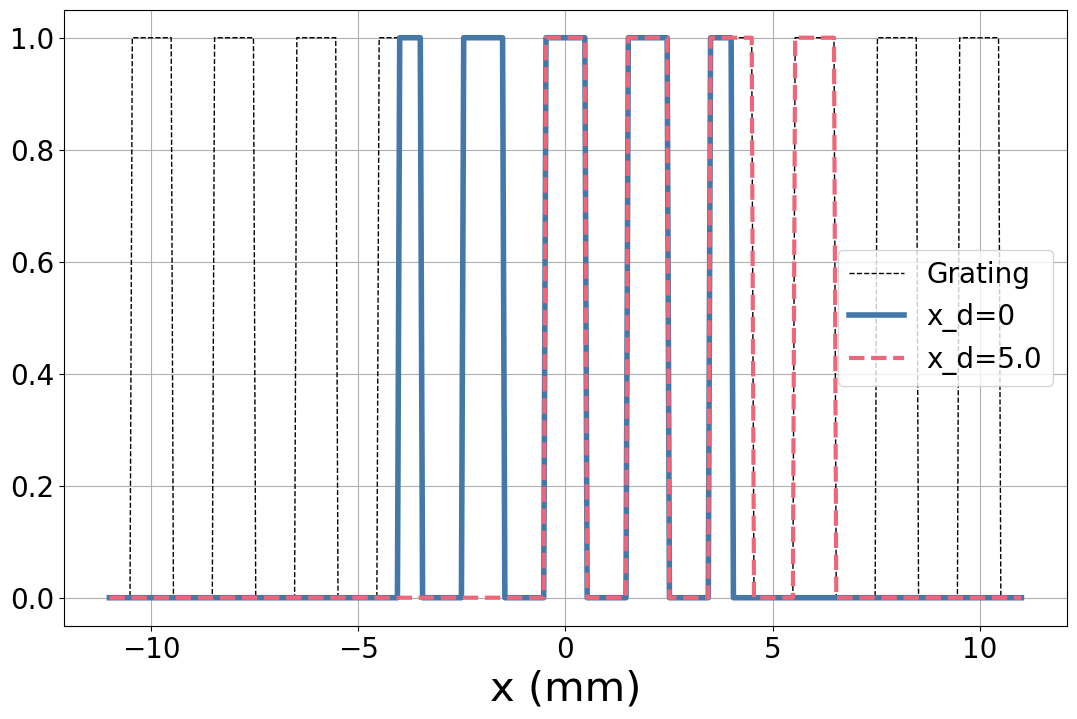

In [7]:
def grating(x,a,t,n,o):
    """Returns 1D transmission function of grating mask."""
    max_x = x[-1]
    result = np.zeros(len(x))
    for indx,i in enumerate(x):
        for s in range(1,n+1):
            if (i > (max_x - o - (a + t)*(s - 1) - t) and i < (max_x - o - (a + t)*(s - 1))):
                result[indx] = 1
    return result

def seen_grating(x,grating,xd,ls,ld,res):
    """Returns the grating as seen by point xd on the detector."""
    lower = -res/2 + (1 - ls/ld)*xd
    upper = res/2 + (1 - ls/ld)*xd
    print(f'Lower/upper limits: {round(lower,3)},{round(upper,3)}')
    mask = [i if (lower<x[indx] and x[indx]<upper) else 0 for indx,i in enumerate(grating)]
    return mask, upper, lower

x_fine = np.linspace(-11.,11.,400,endpoint=True)
MASK = grating(x_fine,slit_width,slit_width,slit_num,.5)
SEEN,UPPER,LOWER = seen_grating(x_fine,MASK,0,Ls,Ld,Ls*ap_dia/Ld)

print(f'Ls={round(Ls,2)}, Ld={round(Ld,2)}, SF={round(1-Ls/Ld,2)} R={round(res,2)} (mm)')
fig = plt.figure(figsize=(plot_width,plot_height))
plt.plot(x_fine,MASK,'--',label='Grating',color='black',linewidth=1)
plt.plot(x_fine,SEEN,linewidth=4,label=f'x_d=0')
xd = [det_x/2]
for x in xd:
    SEEN_xd,UPPER_xd,LOWER_xd = seen_grating(x_fine,MASK,x,Ls,Ld,Ls*ap_dia/Ld) 
    plt.plot(x_fine,SEEN_xd,'--',linewidth=3,label=f'x_d={x}')
plt.xlabel('x (mm)')
plt.legend()
plt.show()

***
## Simulation scans
***

In [17]:
def do_run(ray_num,MWP_current,CG_current,sample_in=True,pols=True,plot=True):
    """Performs McStas simulation of high and low count spin state.
    Returns high and low count intensities."""
    if sample_in: sam.set_parameters(offset=1e-3*slit_offset)
    else: sam.set_parameters(offset=1) #one meter offset
    BCG.value = CG_current*cg_gpa  #center guide field strength (Gauss)
    AER.settings(output_path=f'{path}hc{round(MWP_current,2)}',ncount=ray_num)
    low_count.value, all_off.value, cur1.value, cur2.value = 0, 0, MWP_current, -MWP_current
    AER_hc = AER.backengine()
    if plot: ms.make_sub_plot(AER_hc)
    if pols==False or int(MWP_current*10)==0: #ignores low counts
        return AER_hc[0].Intensity,np.empty(np.shape(AER_hc[0].Intensity))
    else:
        AER.settings(output_path=f'{path}lc{round(MWP_current,2)}',ncount=ray_num)
        low_count.value, all_off.value, cur1.value, cur2.value = 1, 0, MWP_current, -MWP_current
        AER_lc = AER.backengine()
        if plot: ms.make_sub_plot(AER_lc)
        return AER_hc[0].Intensity, AER_lc[0].Intensity

def do_scan(ray_num,curs,CG_current,sample_in=True,pols=True):
    """Performs current scan for given number of AER harmonics.
    Returns lists of intensities and errors from do_run."""
    results = [[] for c in curs]
    for indx,c in enumerate(curs):
        results[indx] = do_run(ray_num,c,CG_current,sample_in=sample_in,pols=pols)
    return results

def do_CG_scan(ray_num,CG_curs,MWP_cur,sample_in=True,pols=True):
    """Performs scan of center guide field assuming MWPs are focused at one current."""
    results = [[] for c in CG_curs]
    cur1.value,cur2.value = MWP_cur,-MWP_cur
    for indx,c in enumerate(CG_curs):
        BCG.value = c*cg_gpa
        print(CG)
        results[indx] = do_run(ray_num,MWP_cur,c,sample_in=sample_in,pols=pols)
    return results

### Idealized current scan


loading system configuration
INFO: Using directory: "C:\Users\xsm\Documents\GitHub\AER-HFIR-1-23\Simulations\Ideal_cur_scan_1e8\hc0.0"
INFO: Regenerating c-file: AER_HFIR_2023.c

-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 

-----------------------------------------------------------

Generating GPU/CPU -DFUNNEL layout:

-----------------------------------------------------------
Info:    'Source_sam' is a contributed component.
Info:    'Pol_MWP_v3' is a contributed component.
Info:    'grating_mask' is a contributed component.
CFLAGS=
INFO: Recompiling: AER_HFIR_2023.exe
AER_HFIR_2023.c: In function 'mcuse_dir':
AER_HFIR_2023.c:3629:8: warning: implicit declaration of function 'mkdir' [-Wimplicit-function-declaration]
     if(mkdir(dirname, 0777)) {
        ^
AER_HFIR_2023.c: In function 'sighandler':
AER_HFIR_2023.c:5535:64: warning: implicit declaration of function 'getpid' [-Wimplicit-function-declaration

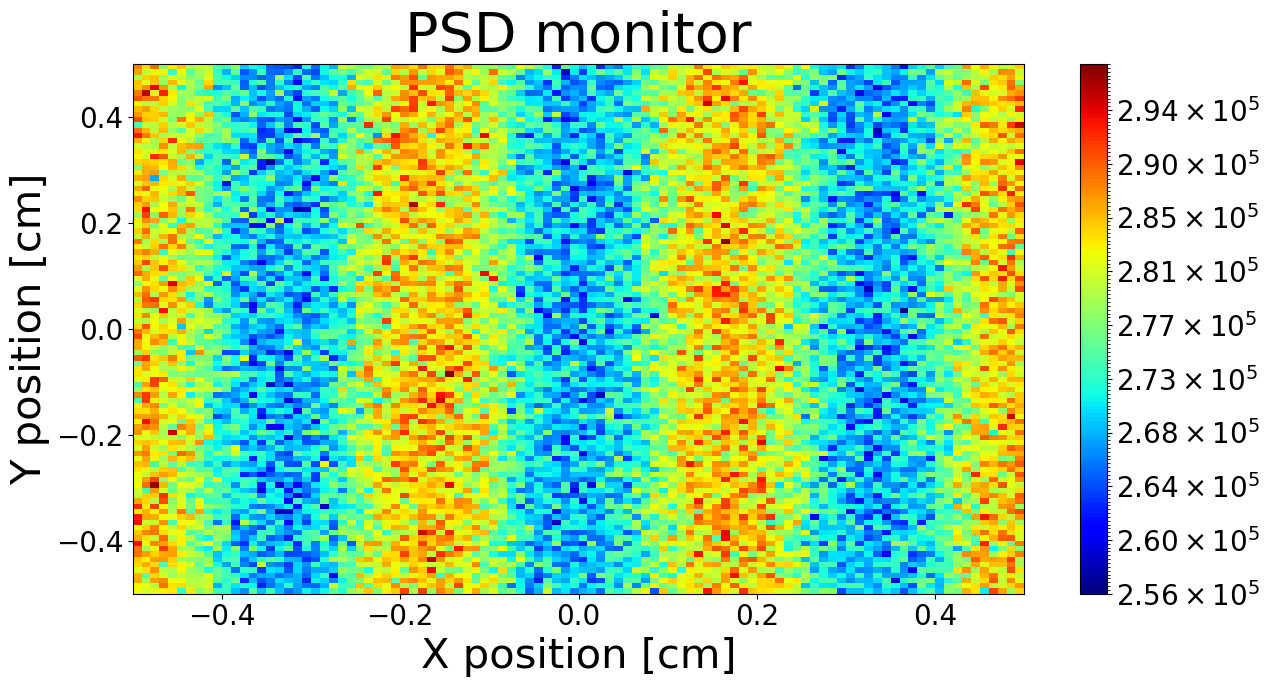


loading system configuration
INFO: Using directory: "C:\Users\xsm\Documents\GitHub\AER-HFIR-1-23\Simulations\Ideal_cur_scan_1e8\hc1.54"
INFO: Regenerating c-file: AER_HFIR_2023.c

-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 

-----------------------------------------------------------

Generating GPU/CPU -DFUNNEL layout:

-----------------------------------------------------------
Info:    'Source_sam' is a contributed component.
Info:    'Pol_MWP_v3' is a contributed component.
Info:    'grating_mask' is a contributed component.
CFLAGS=
INFO: Recompiling: AER_HFIR_2023.exe
AER_HFIR_2023.c: In function 'mcuse_dir':
AER_HFIR_2023.c:3629:8: warning: implicit declaration of function 'mkdir' [-Wimplicit-function-declaration]
     if(mkdir(dirname, 0777)) {
        ^
AER_HFIR_2023.c: In function 'sighandler':
AER_HFIR_2023.c:5535:64: warning: implicit declaration of function 'getpid' [-Wimplicit-function-declaratio

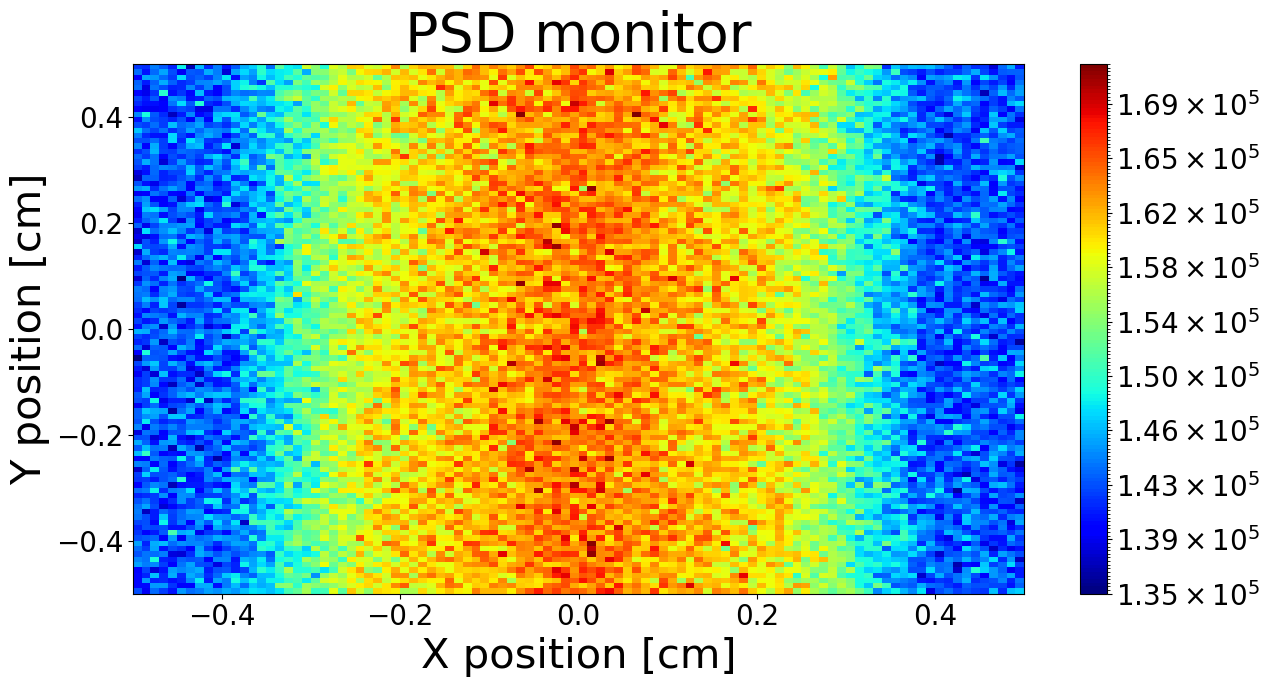


loading system configuration
INFO: Using directory: "C:\Users\xsm\Documents\GitHub\AER-HFIR-1-23\Simulations\Ideal_cur_scan_1e8\lc1.54"
INFO: Regenerating c-file: AER_HFIR_2023.c

-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 

-----------------------------------------------------------

Generating GPU/CPU -DFUNNEL layout:

-----------------------------------------------------------
Info:    'Source_sam' is a contributed component.
Info:    'Pol_MWP_v3' is a contributed component.
Info:    'grating_mask' is a contributed component.
CFLAGS=
INFO: Recompiling: AER_HFIR_2023.exe
AER_HFIR_2023.c: In function 'mcuse_dir':
AER_HFIR_2023.c:3629:8: warning: implicit declaration of function 'mkdir' [-Wimplicit-function-declaration]
     if(mkdir(dirname, 0777)) {
        ^
AER_HFIR_2023.c: In function 'sighandler':
AER_HFIR_2023.c:5535:64: warning: implicit declaration of function 'getpid' [-Wimplicit-function-declaratio

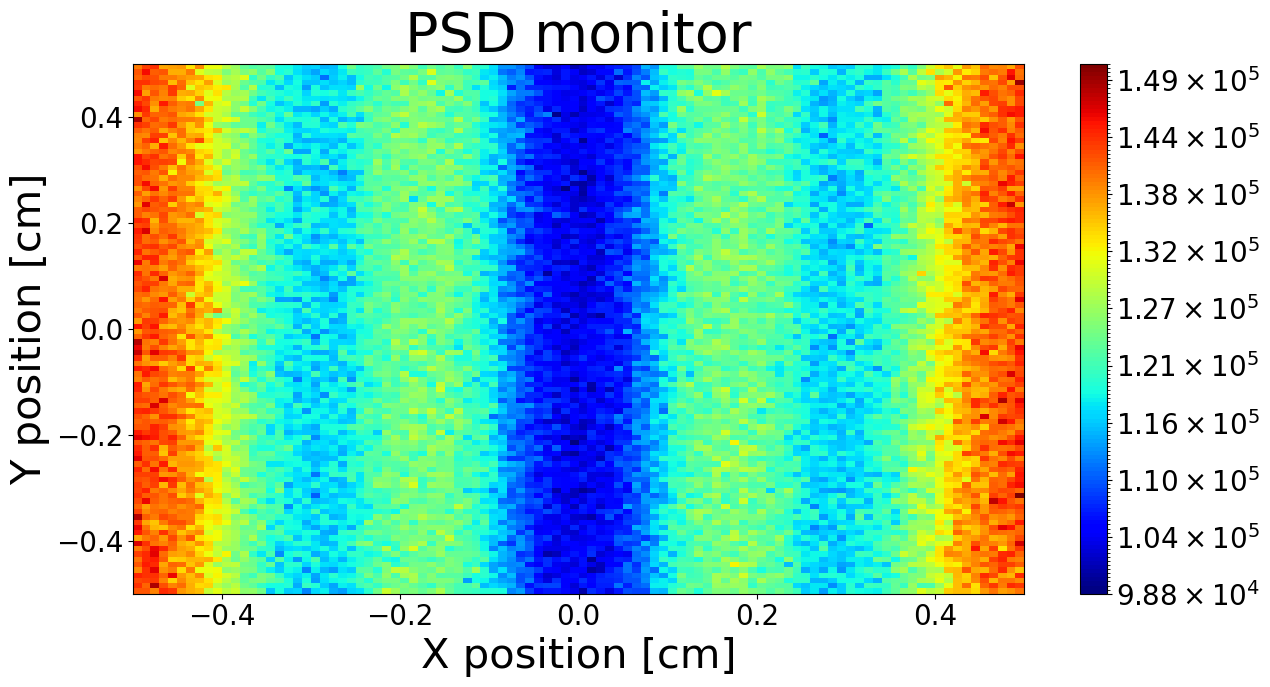


loading system configuration
INFO: Using directory: "C:\Users\xsm\Documents\GitHub\AER-HFIR-1-23\Simulations\Ideal_cur_scan_1e8\hc3.08"
INFO: Regenerating c-file: AER_HFIR_2023.c

-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 

-----------------------------------------------------------

Generating GPU/CPU -DFUNNEL layout:

-----------------------------------------------------------
Info:    'Source_sam' is a contributed component.
Info:    'Pol_MWP_v3' is a contributed component.
Info:    'grating_mask' is a contributed component.
CFLAGS=
INFO: Recompiling: AER_HFIR_2023.exe
AER_HFIR_2023.c: In function 'mcuse_dir':
AER_HFIR_2023.c:3629:8: warning: implicit declaration of function 'mkdir' [-Wimplicit-function-declaration]
     if(mkdir(dirname, 0777)) {
        ^
AER_HFIR_2023.c: In function 'sighandler':
AER_HFIR_2023.c:5535:64: warning: implicit declaration of function 'getpid' [-Wimplicit-function-declaratio

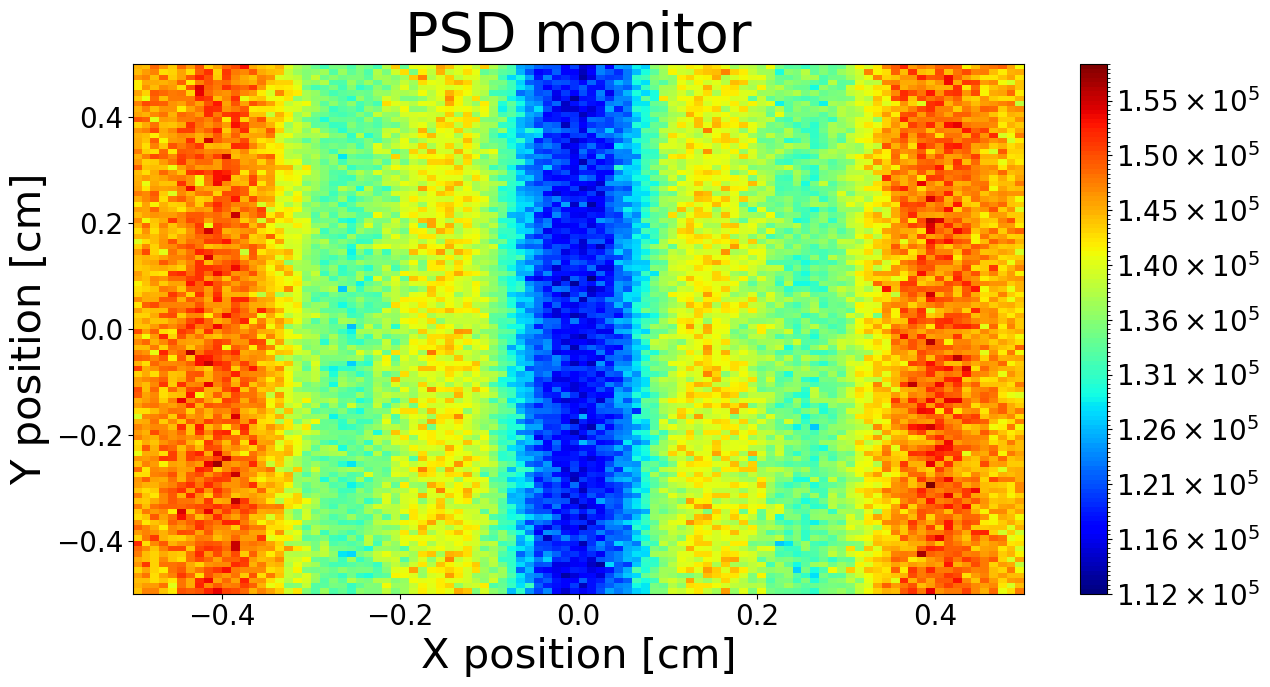


loading system configuration
INFO: Using directory: "C:\Users\xsm\Documents\GitHub\AER-HFIR-1-23\Simulations\Ideal_cur_scan_1e8\lc3.08"
INFO: Regenerating c-file: AER_HFIR_2023.c

-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 

-----------------------------------------------------------

Generating GPU/CPU -DFUNNEL layout:

-----------------------------------------------------------
Info:    'Source_sam' is a contributed component.
Info:    'Pol_MWP_v3' is a contributed component.
Info:    'grating_mask' is a contributed component.
CFLAGS=
INFO: Recompiling: AER_HFIR_2023.exe
AER_HFIR_2023.c: In function 'mcuse_dir':
AER_HFIR_2023.c:3629:8: warning: implicit declaration of function 'mkdir' [-Wimplicit-function-declaration]
     if(mkdir(dirname, 0777)) {
        ^
AER_HFIR_2023.c: In function 'sighandler':
AER_HFIR_2023.c:5535:64: warning: implicit declaration of function 'getpid' [-Wimplicit-function-declaratio

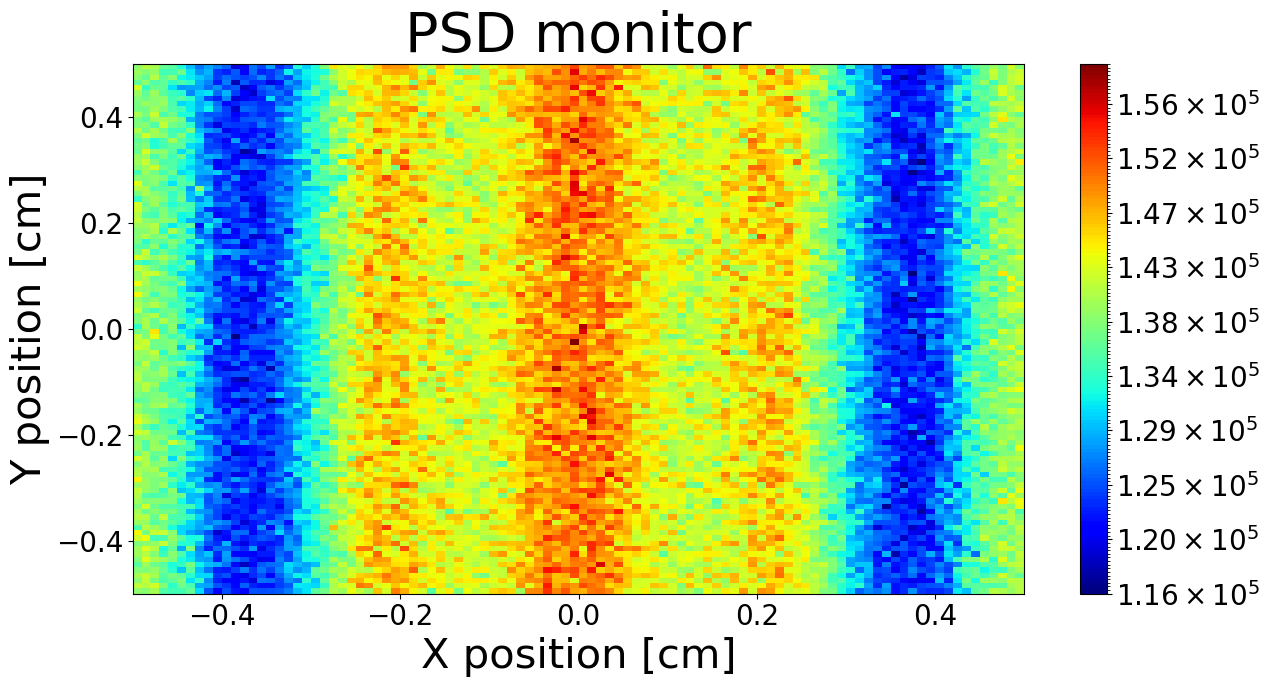


loading system configuration
INFO: Using directory: "C:\Users\xsm\Documents\GitHub\AER-HFIR-1-23\Simulations\Ideal_cur_scan_1e8\hc4.62"
INFO: Regenerating c-file: AER_HFIR_2023.c

-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 

-----------------------------------------------------------

Generating GPU/CPU -DFUNNEL layout:

-----------------------------------------------------------
Info:    'Source_sam' is a contributed component.
Info:    'Pol_MWP_v3' is a contributed component.
Info:    'grating_mask' is a contributed component.
CFLAGS=
INFO: Recompiling: AER_HFIR_2023.exe
AER_HFIR_2023.c: In function 'mcuse_dir':
AER_HFIR_2023.c:3629:8: warning: implicit declaration of function 'mkdir' [-Wimplicit-function-declaration]
     if(mkdir(dirname, 0777)) {
        ^
AER_HFIR_2023.c: In function 'sighandler':
AER_HFIR_2023.c:5535:64: warning: implicit declaration of function 'getpid' [-Wimplicit-function-declaratio

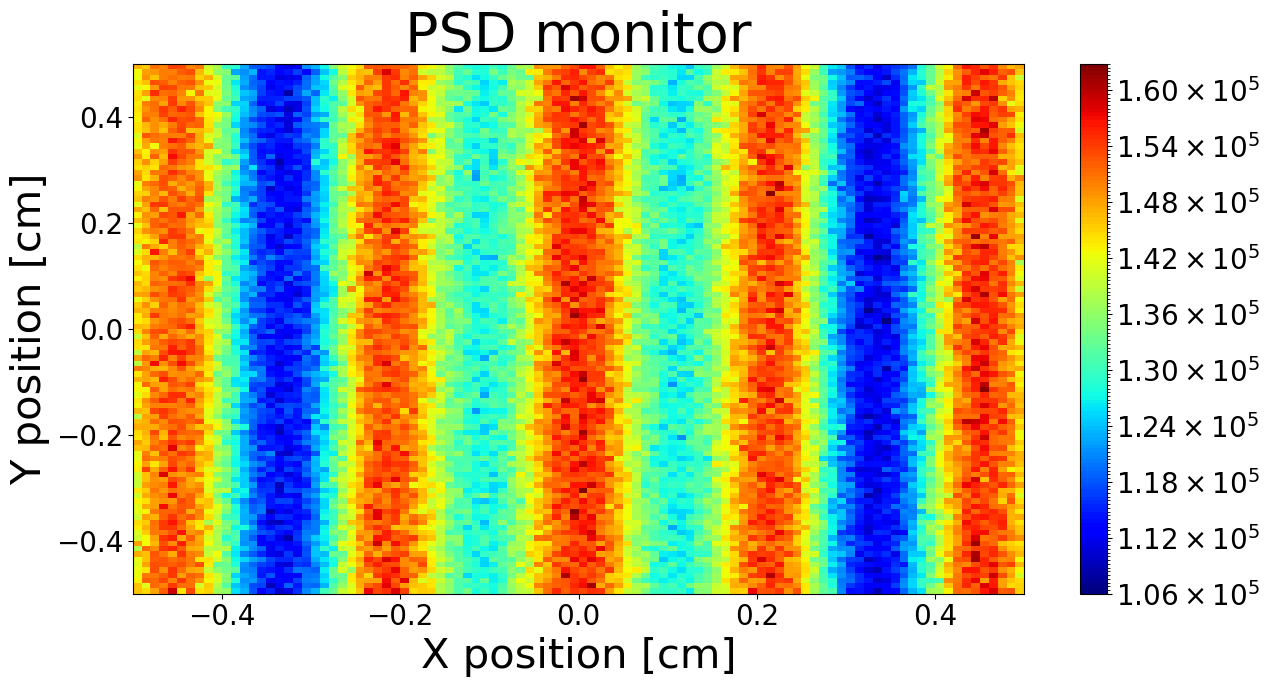


loading system configuration
INFO: Using directory: "C:\Users\xsm\Documents\GitHub\AER-HFIR-1-23\Simulations\Ideal_cur_scan_1e8\lc4.62"
INFO: Regenerating c-file: AER_HFIR_2023.c

-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 

-----------------------------------------------------------

Generating GPU/CPU -DFUNNEL layout:

-----------------------------------------------------------
Info:    'Source_sam' is a contributed component.
Info:    'Pol_MWP_v3' is a contributed component.
Info:    'grating_mask' is a contributed component.
CFLAGS=
INFO: Recompiling: AER_HFIR_2023.exe
AER_HFIR_2023.c: In function 'mcuse_dir':
AER_HFIR_2023.c:3629:8: warning: implicit declaration of function 'mkdir' [-Wimplicit-function-declaration]
     if(mkdir(dirname, 0777)) {
        ^
AER_HFIR_2023.c: In function 'sighandler':
AER_HFIR_2023.c:5535:64: warning: implicit declaration of function 'getpid' [-Wimplicit-function-declaratio

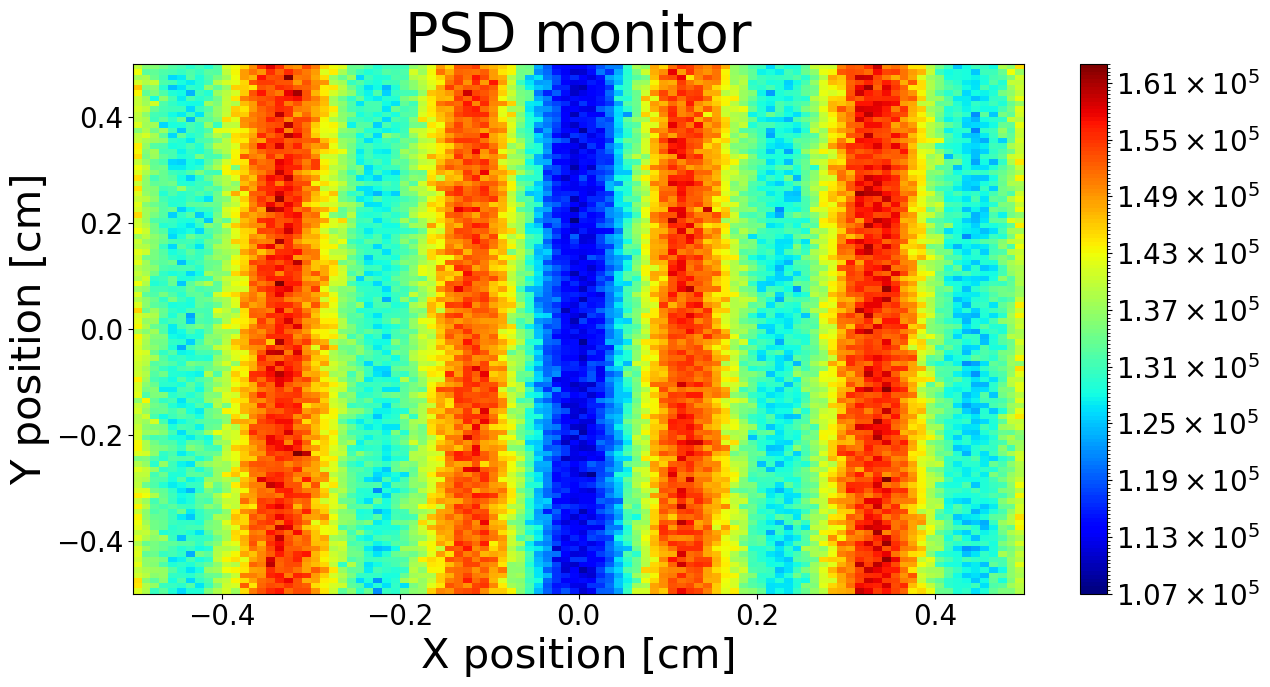


loading system configuration
INFO: Using directory: "C:\Users\xsm\Documents\GitHub\AER-HFIR-1-23\Simulations\Ideal_cur_scan_1e8\hc6.17"
INFO: Regenerating c-file: AER_HFIR_2023.c

-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 

-----------------------------------------------------------

Generating GPU/CPU -DFUNNEL layout:

-----------------------------------------------------------
Info:    'Source_sam' is a contributed component.
Info:    'Pol_MWP_v3' is a contributed component.
Info:    'grating_mask' is a contributed component.
CFLAGS=
INFO: Recompiling: AER_HFIR_2023.exe
AER_HFIR_2023.c: In function 'mcuse_dir':
AER_HFIR_2023.c:3629:8: warning: implicit declaration of function 'mkdir' [-Wimplicit-function-declaration]
     if(mkdir(dirname, 0777)) {
        ^
AER_HFIR_2023.c: In function 'sighandler':
AER_HFIR_2023.c:5535:64: warning: implicit declaration of function 'getpid' [-Wimplicit-function-declaratio

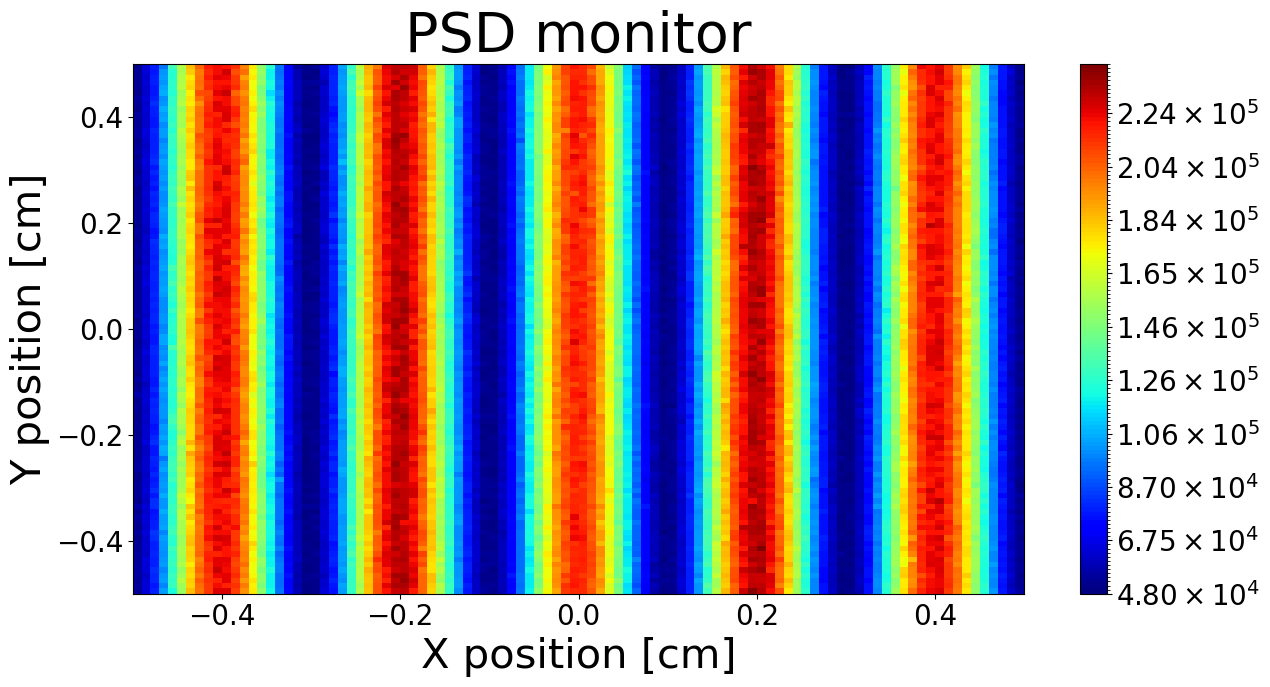


loading system configuration
INFO: Using directory: "C:\Users\xsm\Documents\GitHub\AER-HFIR-1-23\Simulations\Ideal_cur_scan_1e8\lc6.17"
INFO: Regenerating c-file: AER_HFIR_2023.c

-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 

-----------------------------------------------------------

Generating GPU/CPU -DFUNNEL layout:

-----------------------------------------------------------
Info:    'Source_sam' is a contributed component.
Info:    'Pol_MWP_v3' is a contributed component.
Info:    'grating_mask' is a contributed component.
CFLAGS=
INFO: Recompiling: AER_HFIR_2023.exe
AER_HFIR_2023.c: In function 'mcuse_dir':
AER_HFIR_2023.c:3629:8: warning: implicit declaration of function 'mkdir' [-Wimplicit-function-declaration]
     if(mkdir(dirname, 0777)) {
        ^
AER_HFIR_2023.c: In function 'sighandler':
AER_HFIR_2023.c:5535:64: warning: implicit declaration of function 'getpid' [-Wimplicit-function-declaratio

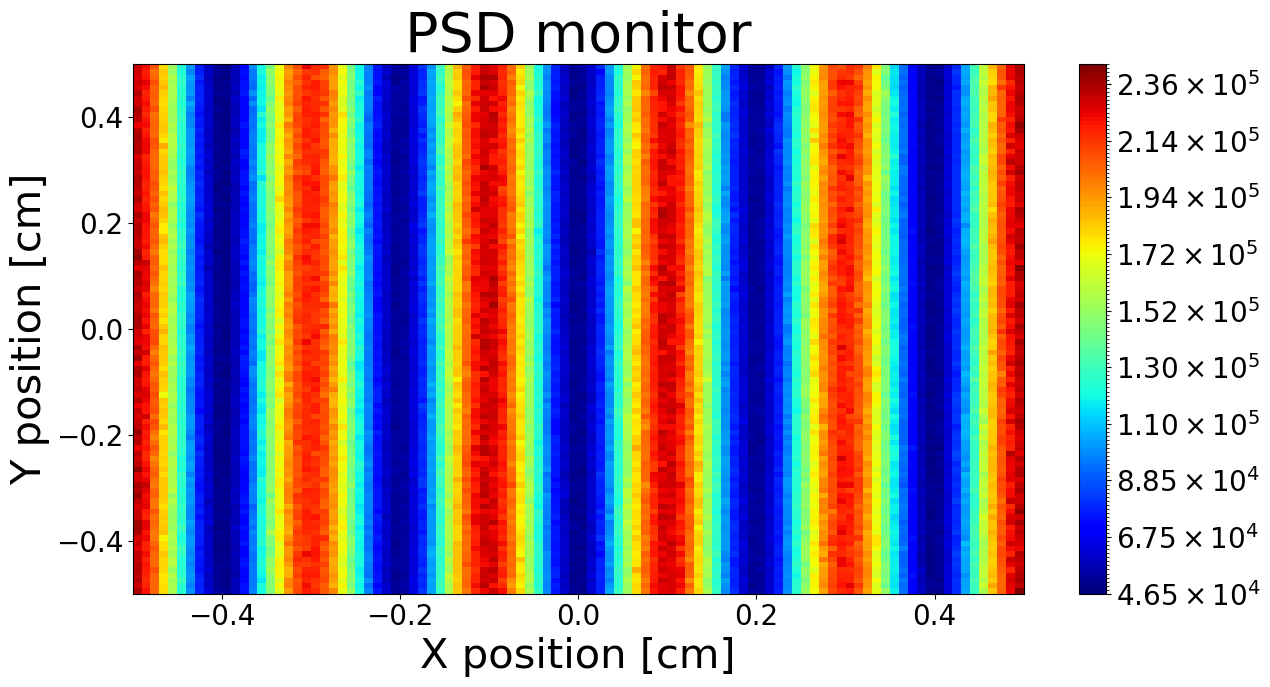


loading system configuration
INFO: Using directory: "C:\Users\xsm\Documents\GitHub\AER-HFIR-1-23\Simulations\Ideal_cur_scan_1e8\hc7.71"
INFO: Regenerating c-file: AER_HFIR_2023.c

-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 

-----------------------------------------------------------

Generating GPU/CPU -DFUNNEL layout:

-----------------------------------------------------------
Info:    'Source_sam' is a contributed component.
Info:    'Pol_MWP_v3' is a contributed component.
Info:    'grating_mask' is a contributed component.
CFLAGS=
INFO: Recompiling: AER_HFIR_2023.exe
AER_HFIR_2023.c: In function 'mcuse_dir':
AER_HFIR_2023.c:3629:8: warning: implicit declaration of function 'mkdir' [-Wimplicit-function-declaration]
     if(mkdir(dirname, 0777)) {
        ^
AER_HFIR_2023.c: In function 'sighandler':
AER_HFIR_2023.c:5535:64: warning: implicit declaration of function 'getpid' [-Wimplicit-function-declaratio

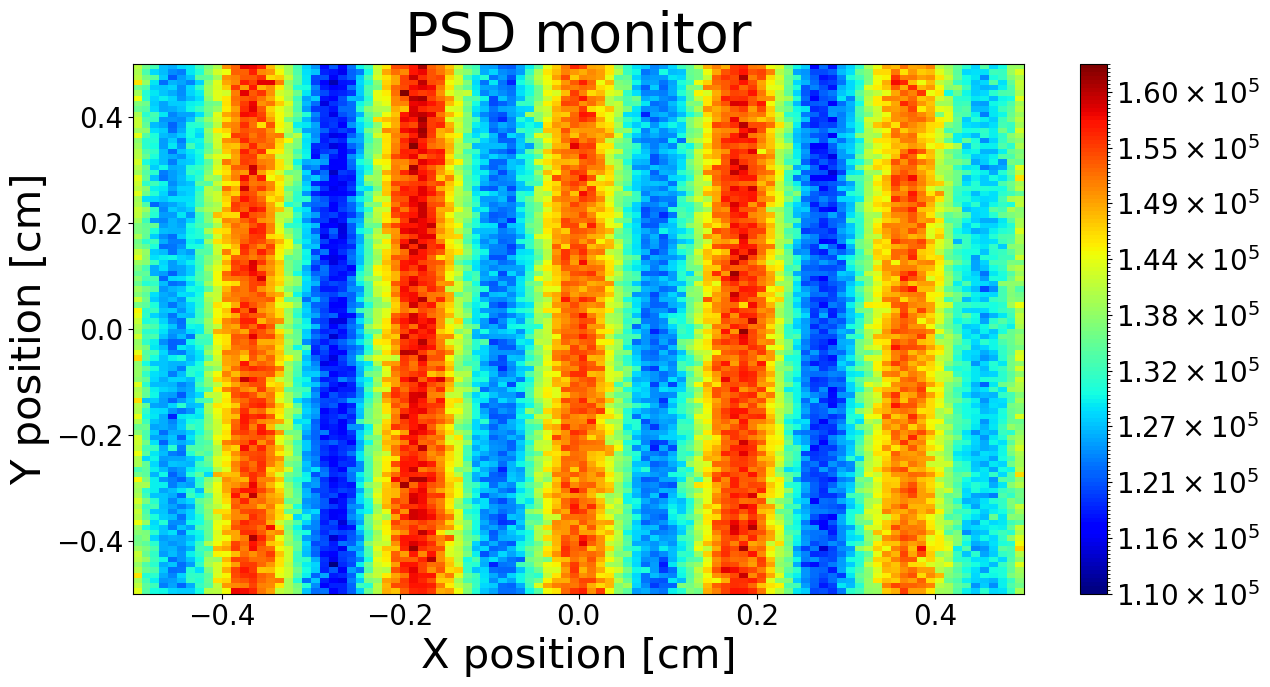


loading system configuration
INFO: Using directory: "C:\Users\xsm\Documents\GitHub\AER-HFIR-1-23\Simulations\Ideal_cur_scan_1e8\lc7.71"
INFO: Regenerating c-file: AER_HFIR_2023.c

-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 

-----------------------------------------------------------

Generating GPU/CPU -DFUNNEL layout:

-----------------------------------------------------------
Info:    'Source_sam' is a contributed component.
Info:    'Pol_MWP_v3' is a contributed component.
Info:    'grating_mask' is a contributed component.
CFLAGS=
INFO: Recompiling: AER_HFIR_2023.exe
AER_HFIR_2023.c: In function 'mcuse_dir':
AER_HFIR_2023.c:3629:8: warning: implicit declaration of function 'mkdir' [-Wimplicit-function-declaration]
     if(mkdir(dirname, 0777)) {
        ^
AER_HFIR_2023.c: In function 'sighandler':
AER_HFIR_2023.c:5535:64: warning: implicit declaration of function 'getpid' [-Wimplicit-function-declaratio

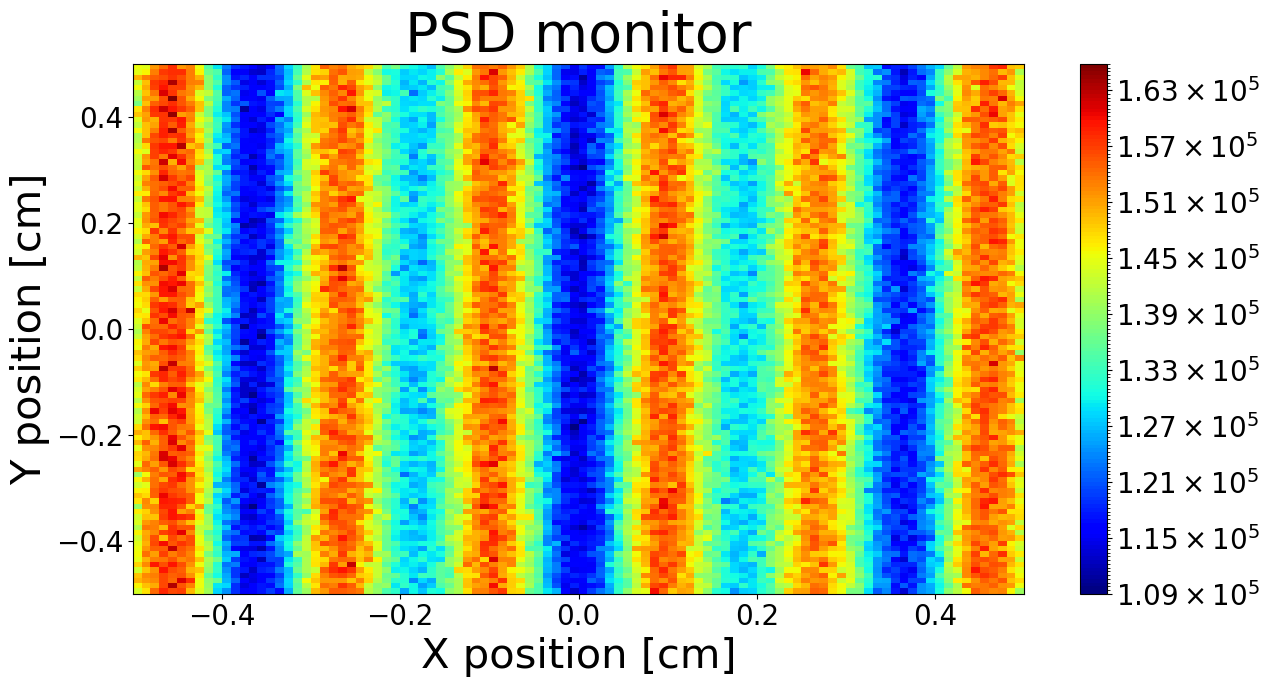


loading system configuration
INFO: Using directory: "C:\Users\xsm\Documents\GitHub\AER-HFIR-1-23\Simulations\Ideal_cur_scan_1e8\hc9.25"
INFO: Regenerating c-file: AER_HFIR_2023.c

-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 

-----------------------------------------------------------

Generating GPU/CPU -DFUNNEL layout:

-----------------------------------------------------------
Info:    'Source_sam' is a contributed component.
Info:    'Pol_MWP_v3' is a contributed component.
Info:    'grating_mask' is a contributed component.
CFLAGS=
INFO: Recompiling: AER_HFIR_2023.exe
AER_HFIR_2023.c: In function 'mcuse_dir':
AER_HFIR_2023.c:3629:8: warning: implicit declaration of function 'mkdir' [-Wimplicit-function-declaration]
     if(mkdir(dirname, 0777)) {
        ^
AER_HFIR_2023.c: In function 'sighandler':
AER_HFIR_2023.c:5535:64: warning: implicit declaration of function 'getpid' [-Wimplicit-function-declaratio

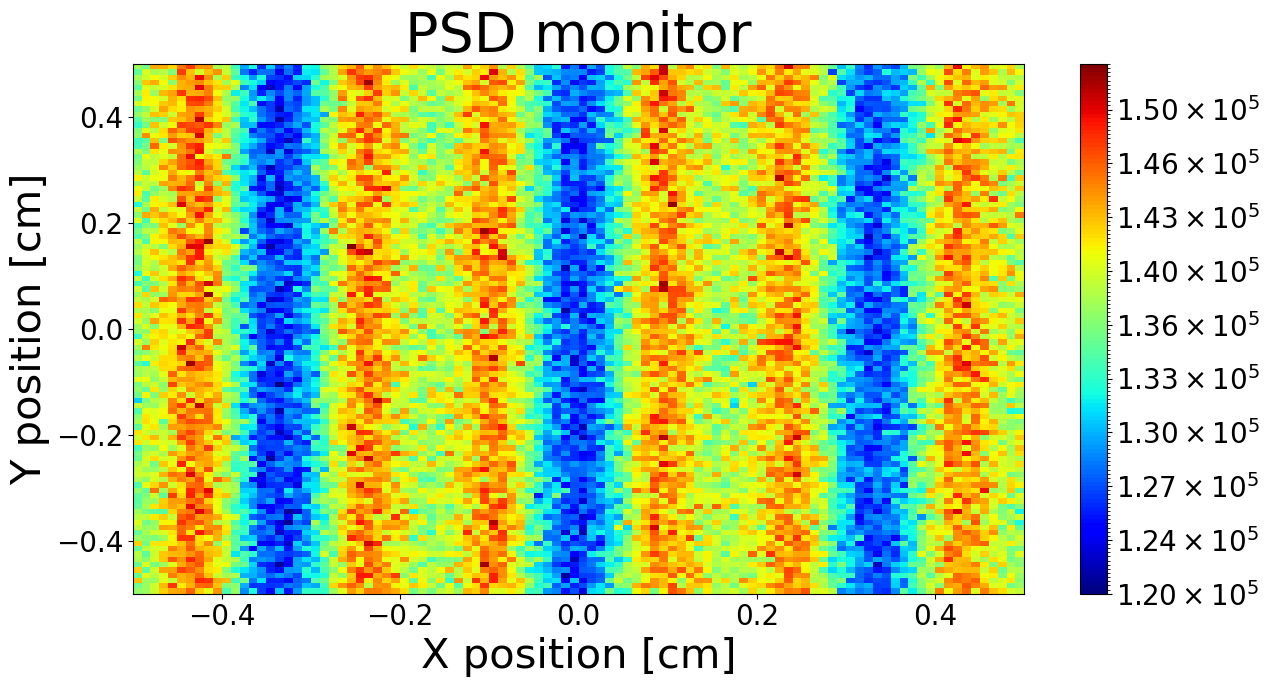


loading system configuration
INFO: Using directory: "C:\Users\xsm\Documents\GitHub\AER-HFIR-1-23\Simulations\Ideal_cur_scan_1e8\lc9.25"
INFO: Regenerating c-file: AER_HFIR_2023.c

-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 

-----------------------------------------------------------

Generating GPU/CPU -DFUNNEL layout:

-----------------------------------------------------------
Info:    'Source_sam' is a contributed component.
Info:    'Pol_MWP_v3' is a contributed component.
Info:    'grating_mask' is a contributed component.
CFLAGS=
INFO: Recompiling: AER_HFIR_2023.exe
AER_HFIR_2023.c: In function 'mcuse_dir':
AER_HFIR_2023.c:3629:8: warning: implicit declaration of function 'mkdir' [-Wimplicit-function-declaration]
     if(mkdir(dirname, 0777)) {
        ^
AER_HFIR_2023.c: In function 'sighandler':
AER_HFIR_2023.c:5535:64: warning: implicit declaration of function 'getpid' [-Wimplicit-function-declaratio

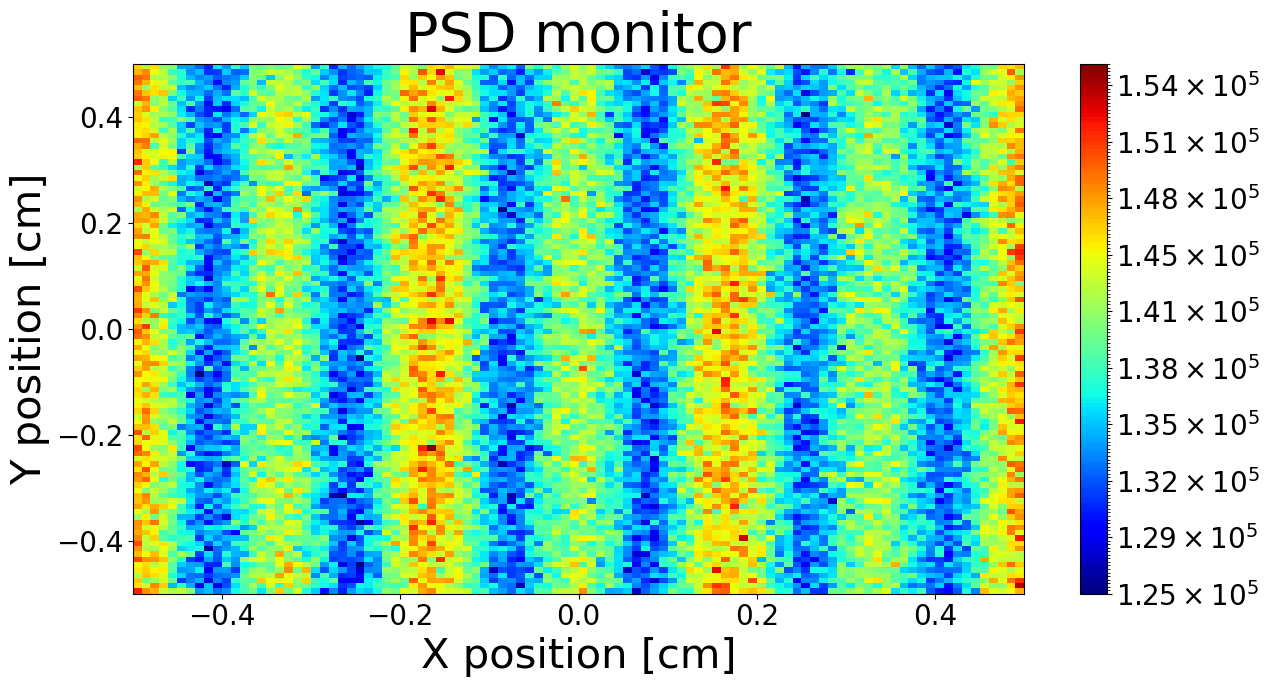


loading system configuration
INFO: Using directory: "C:\Users\xsm\Documents\GitHub\AER-HFIR-1-23\Simulations\Ideal_cur_scan_1e8\hc10.79"
INFO: Regenerating c-file: AER_HFIR_2023.c

-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 

-----------------------------------------------------------

Generating GPU/CPU -DFUNNEL layout:

-----------------------------------------------------------
Info:    'Source_sam' is a contributed component.
Info:    'Pol_MWP_v3' is a contributed component.
Info:    'grating_mask' is a contributed component.
CFLAGS=
INFO: Recompiling: AER_HFIR_2023.exe
AER_HFIR_2023.c: In function 'mcuse_dir':
AER_HFIR_2023.c:3629:8: warning: implicit declaration of function 'mkdir' [-Wimplicit-function-declaration]
     if(mkdir(dirname, 0777)) {
        ^
AER_HFIR_2023.c: In function 'sighandler':
AER_HFIR_2023.c:5535:64: warning: implicit declaration of function 'getpid' [-Wimplicit-function-declarati

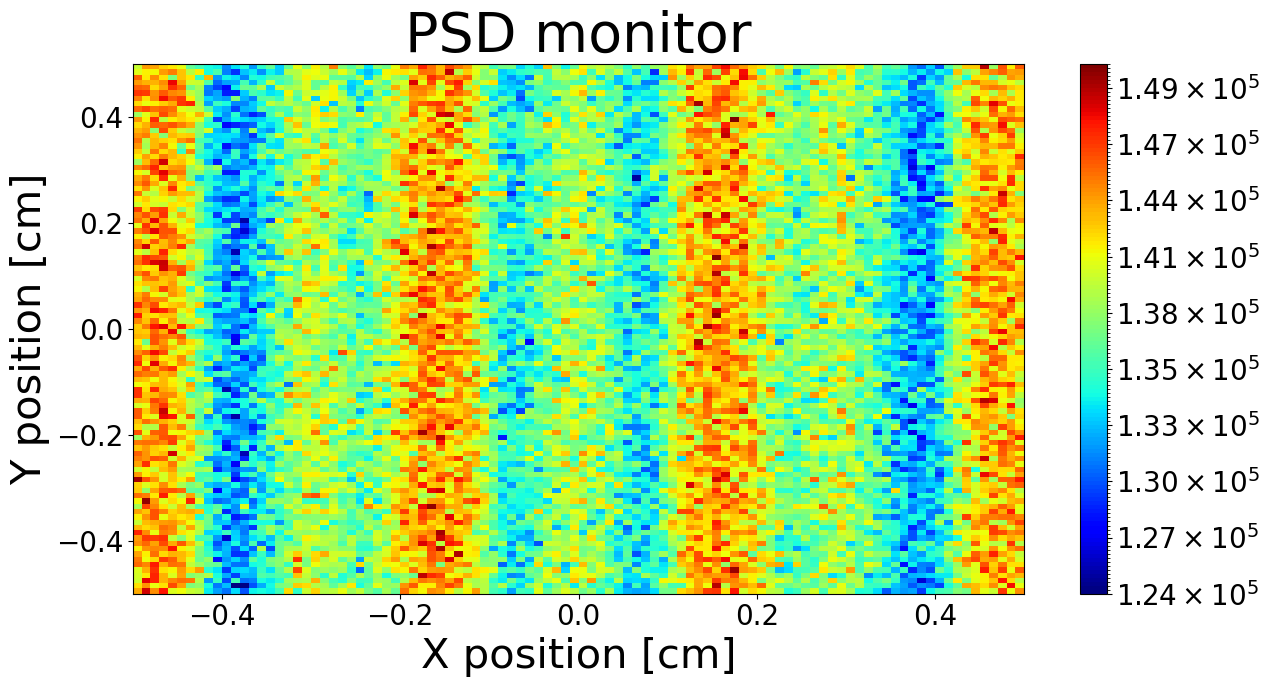


loading system configuration
INFO: Using directory: "C:\Users\xsm\Documents\GitHub\AER-HFIR-1-23\Simulations\Ideal_cur_scan_1e8\lc10.79"
INFO: Regenerating c-file: AER_HFIR_2023.c

-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 

-----------------------------------------------------------

Generating GPU/CPU -DFUNNEL layout:

-----------------------------------------------------------
Info:    'Source_sam' is a contributed component.
Info:    'Pol_MWP_v3' is a contributed component.
Info:    'grating_mask' is a contributed component.
CFLAGS=
INFO: Recompiling: AER_HFIR_2023.exe
AER_HFIR_2023.c: In function 'mcuse_dir':
AER_HFIR_2023.c:3629:8: warning: implicit declaration of function 'mkdir' [-Wimplicit-function-declaration]
     if(mkdir(dirname, 0777)) {
        ^
AER_HFIR_2023.c: In function 'sighandler':
AER_HFIR_2023.c:5535:64: warning: implicit declaration of function 'getpid' [-Wimplicit-function-declarati

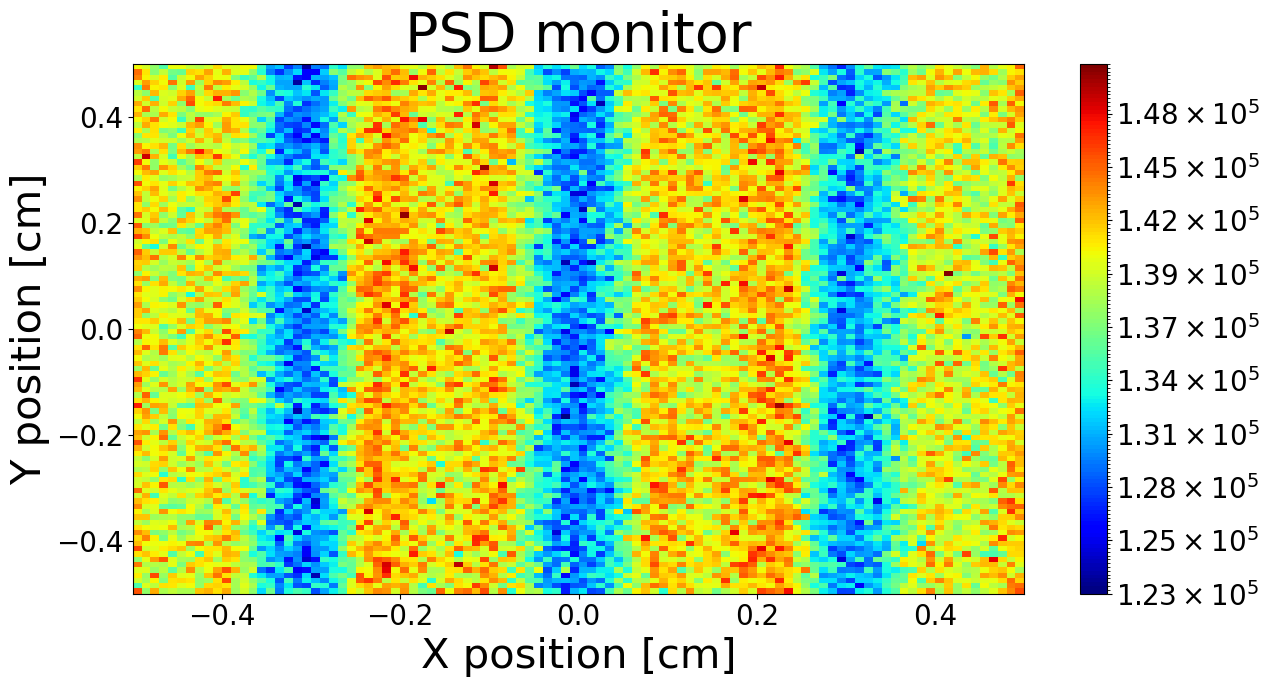


loading system configuration
INFO: Using directory: "C:\Users\xsm\Documents\GitHub\AER-HFIR-1-23\Simulations\Ideal_cur_scan_1e8\hc12.33"
INFO: Regenerating c-file: AER_HFIR_2023.c

-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 

-----------------------------------------------------------

Generating GPU/CPU -DFUNNEL layout:

-----------------------------------------------------------
Info:    'Source_sam' is a contributed component.
Info:    'Pol_MWP_v3' is a contributed component.
Info:    'grating_mask' is a contributed component.
CFLAGS=
INFO: Recompiling: AER_HFIR_2023.exe
AER_HFIR_2023.c: In function 'mcuse_dir':
AER_HFIR_2023.c:3629:8: warning: implicit declaration of function 'mkdir' [-Wimplicit-function-declaration]
     if(mkdir(dirname, 0777)) {
        ^
AER_HFIR_2023.c: In function 'sighandler':
AER_HFIR_2023.c:5535:64: warning: implicit declaration of function 'getpid' [-Wimplicit-function-declarati

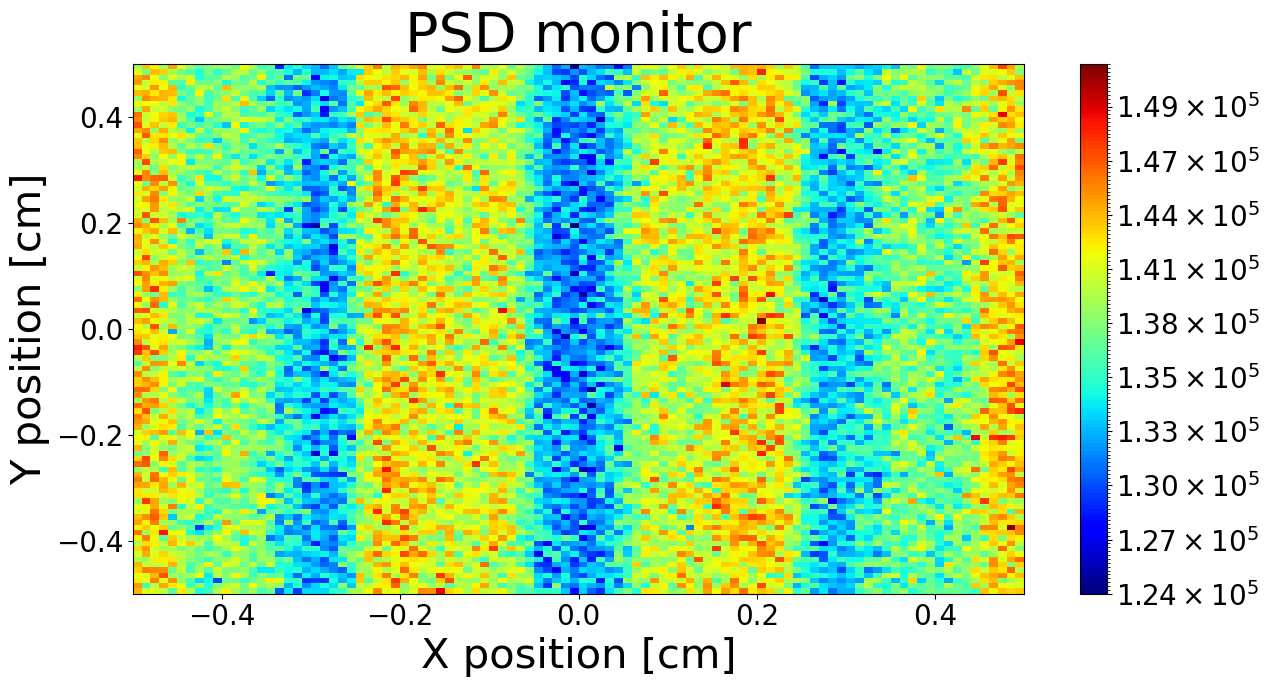


loading system configuration
INFO: Using directory: "C:\Users\xsm\Documents\GitHub\AER-HFIR-1-23\Simulations\Ideal_cur_scan_1e8\lc12.33"
INFO: Regenerating c-file: AER_HFIR_2023.c

-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 

-----------------------------------------------------------

Generating GPU/CPU -DFUNNEL layout:

-----------------------------------------------------------
Info:    'Source_sam' is a contributed component.
Info:    'Pol_MWP_v3' is a contributed component.
Info:    'grating_mask' is a contributed component.
CFLAGS=
INFO: Recompiling: AER_HFIR_2023.exe
AER_HFIR_2023.c: In function 'mcuse_dir':
AER_HFIR_2023.c:3629:8: warning: implicit declaration of function 'mkdir' [-Wimplicit-function-declaration]
     if(mkdir(dirname, 0777)) {
        ^
AER_HFIR_2023.c: In function 'sighandler':
AER_HFIR_2023.c:5535:64: warning: implicit declaration of function 'getpid' [-Wimplicit-function-declarati

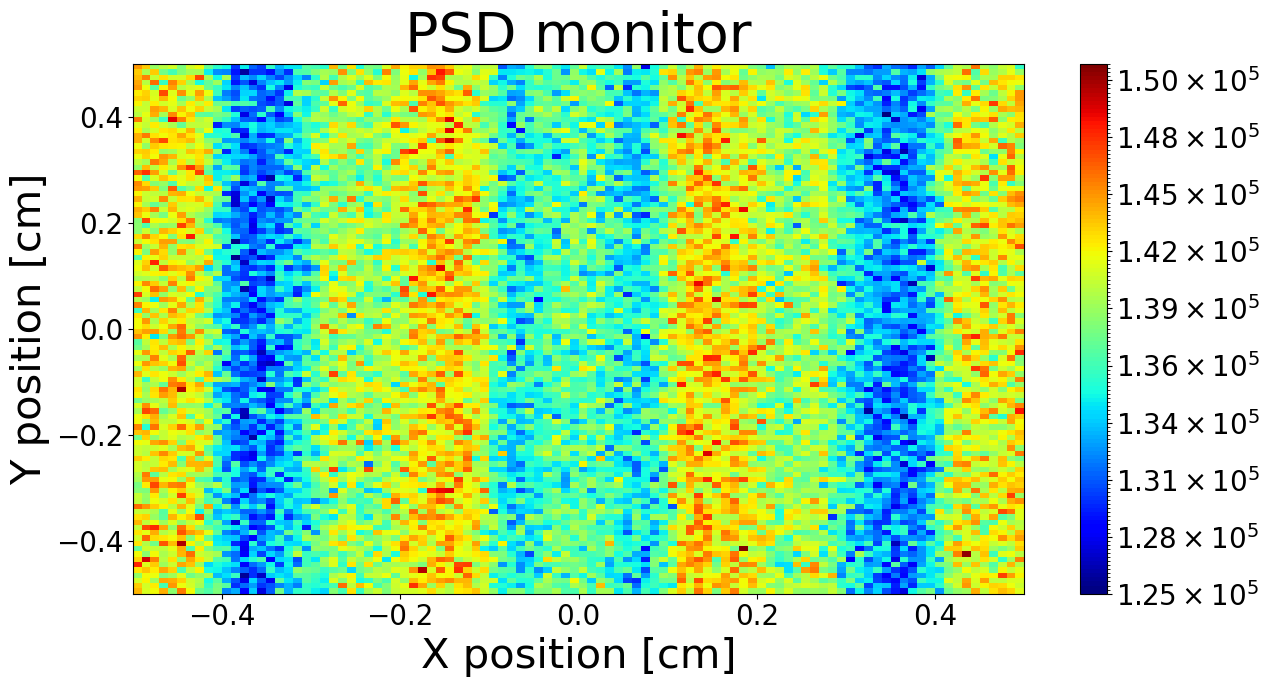


loading system configuration
INFO: Using directory: "C:\Users\xsm\Documents\GitHub\AER-HFIR-1-23\Simulations\Ideal_cur_scan_1e8\hc13.87"
INFO: Regenerating c-file: AER_HFIR_2023.c

-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 

-----------------------------------------------------------

Generating GPU/CPU -DFUNNEL layout:

-----------------------------------------------------------
Info:    'Source_sam' is a contributed component.
Info:    'Pol_MWP_v3' is a contributed component.
Info:    'grating_mask' is a contributed component.
CFLAGS=
INFO: Recompiling: AER_HFIR_2023.exe
AER_HFIR_2023.c: In function 'mcuse_dir':
AER_HFIR_2023.c:3629:8: warning: implicit declaration of function 'mkdir' [-Wimplicit-function-declaration]
     if(mkdir(dirname, 0777)) {
        ^
AER_HFIR_2023.c: In function 'sighandler':
AER_HFIR_2023.c:5535:64: warning: implicit declaration of function 'getpid' [-Wimplicit-function-declarati

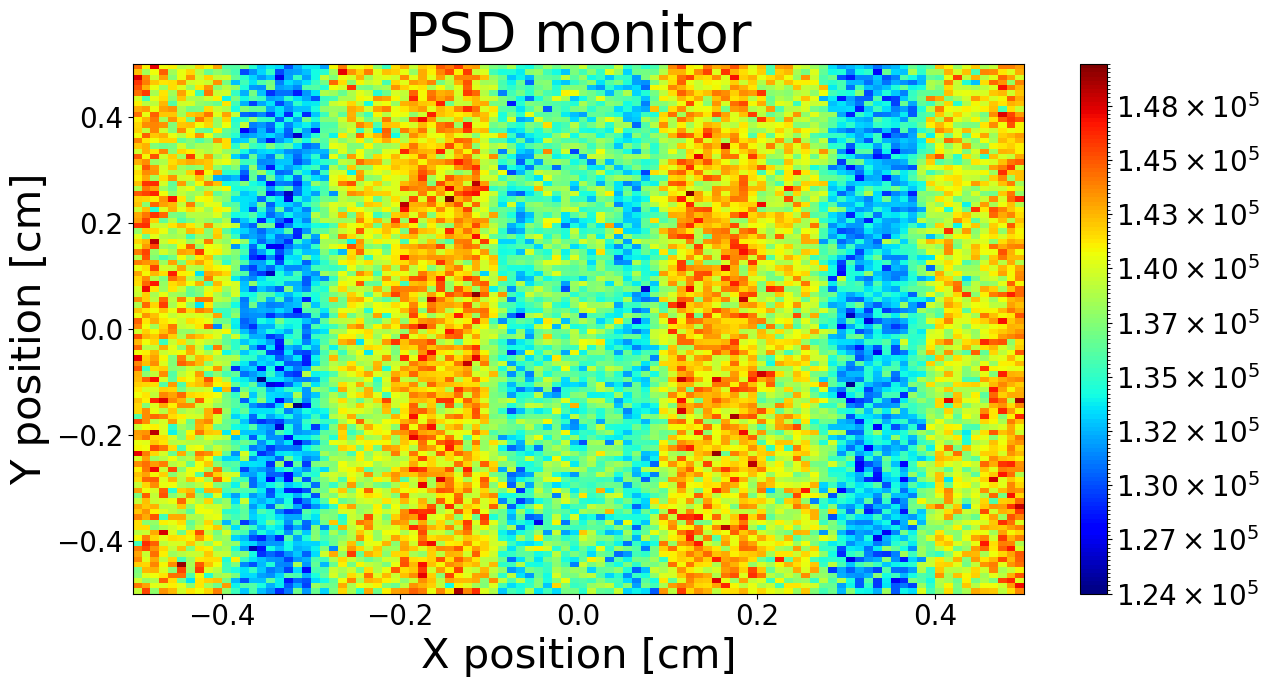


loading system configuration
INFO: Using directory: "C:\Users\xsm\Documents\GitHub\AER-HFIR-1-23\Simulations\Ideal_cur_scan_1e8\lc13.87"
INFO: Regenerating c-file: AER_HFIR_2023.c

-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 

-----------------------------------------------------------

Generating GPU/CPU -DFUNNEL layout:

-----------------------------------------------------------
Info:    'Source_sam' is a contributed component.
Info:    'Pol_MWP_v3' is a contributed component.
Info:    'grating_mask' is a contributed component.
CFLAGS=
INFO: Recompiling: AER_HFIR_2023.exe
AER_HFIR_2023.c: In function 'mcuse_dir':
AER_HFIR_2023.c:3629:8: warning: implicit declaration of function 'mkdir' [-Wimplicit-function-declaration]
     if(mkdir(dirname, 0777)) {
        ^
AER_HFIR_2023.c: In function 'sighandler':
AER_HFIR_2023.c:5535:64: warning: implicit declaration of function 'getpid' [-Wimplicit-function-declarati

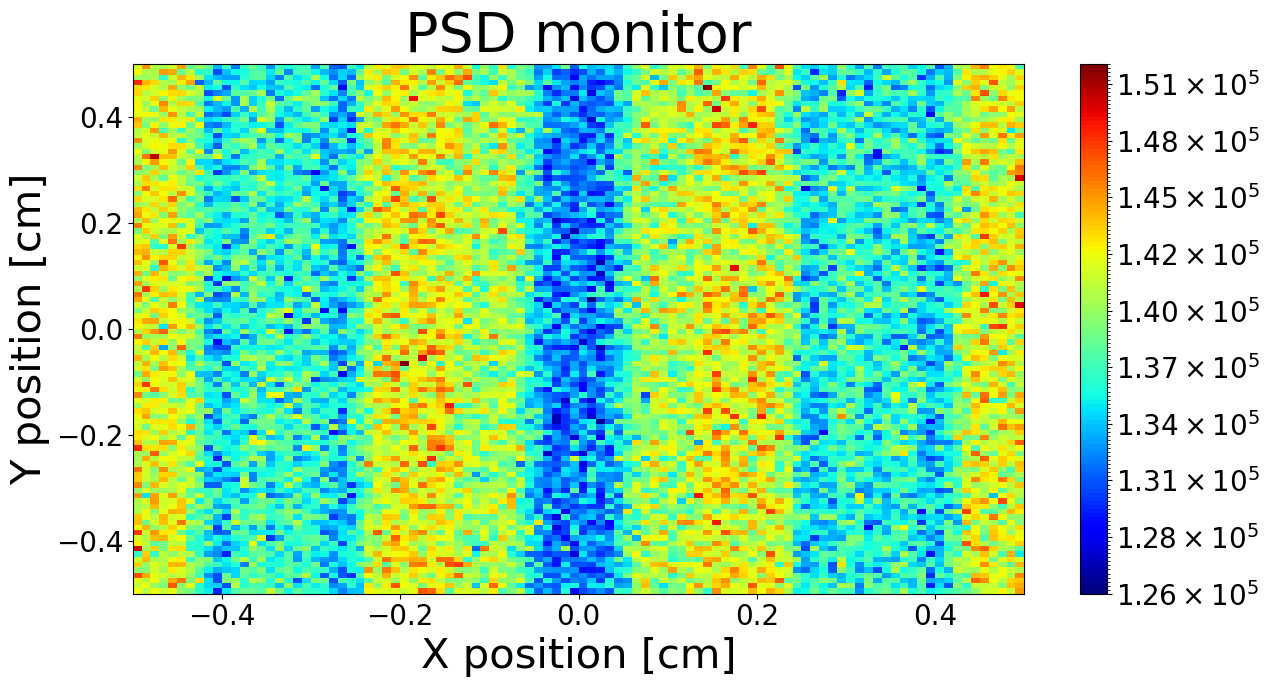


loading system configuration
INFO: Using directory: "C:\Users\xsm\Documents\GitHub\AER-HFIR-1-23\Simulations\Ideal_cur_scan_1e8\hc15.41"
INFO: Regenerating c-file: AER_HFIR_2023.c

-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 

-----------------------------------------------------------

Generating GPU/CPU -DFUNNEL layout:

-----------------------------------------------------------
Info:    'Source_sam' is a contributed component.
Info:    'Pol_MWP_v3' is a contributed component.
Info:    'grating_mask' is a contributed component.
CFLAGS=
INFO: Recompiling: AER_HFIR_2023.exe
AER_HFIR_2023.c: In function 'mcuse_dir':
AER_HFIR_2023.c:3629:8: warning: implicit declaration of function 'mkdir' [-Wimplicit-function-declaration]
     if(mkdir(dirname, 0777)) {
        ^
AER_HFIR_2023.c: In function 'sighandler':
AER_HFIR_2023.c:5535:64: warning: implicit declaration of function 'getpid' [-Wimplicit-function-declarati

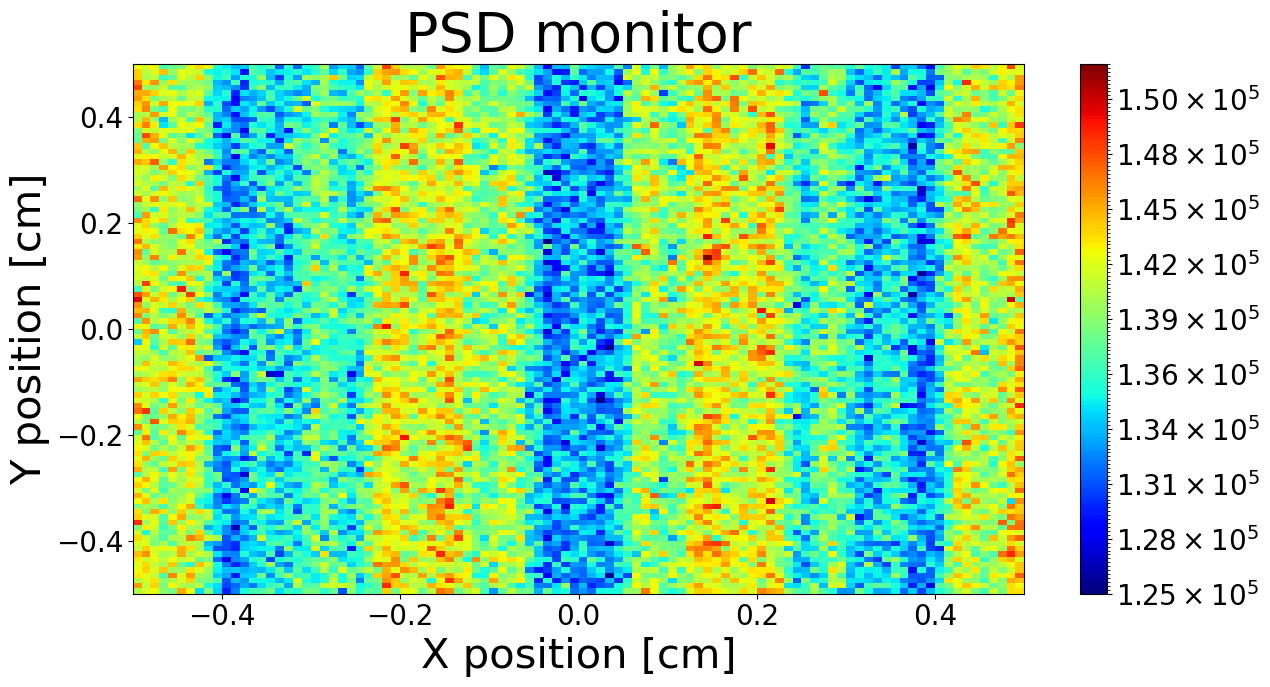


loading system configuration
INFO: Using directory: "C:\Users\xsm\Documents\GitHub\AER-HFIR-1-23\Simulations\Ideal_cur_scan_1e8\lc15.41"
INFO: Regenerating c-file: AER_HFIR_2023.c

-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 

-----------------------------------------------------------

Generating GPU/CPU -DFUNNEL layout:

-----------------------------------------------------------
Info:    'Source_sam' is a contributed component.
Info:    'Pol_MWP_v3' is a contributed component.
Info:    'grating_mask' is a contributed component.
CFLAGS=
INFO: Recompiling: AER_HFIR_2023.exe
AER_HFIR_2023.c: In function 'mcuse_dir':
AER_HFIR_2023.c:3629:8: warning: implicit declaration of function 'mkdir' [-Wimplicit-function-declaration]
     if(mkdir(dirname, 0777)) {
        ^
AER_HFIR_2023.c: In function 'sighandler':
AER_HFIR_2023.c:5535:64: warning: implicit declaration of function 'getpid' [-Wimplicit-function-declarati

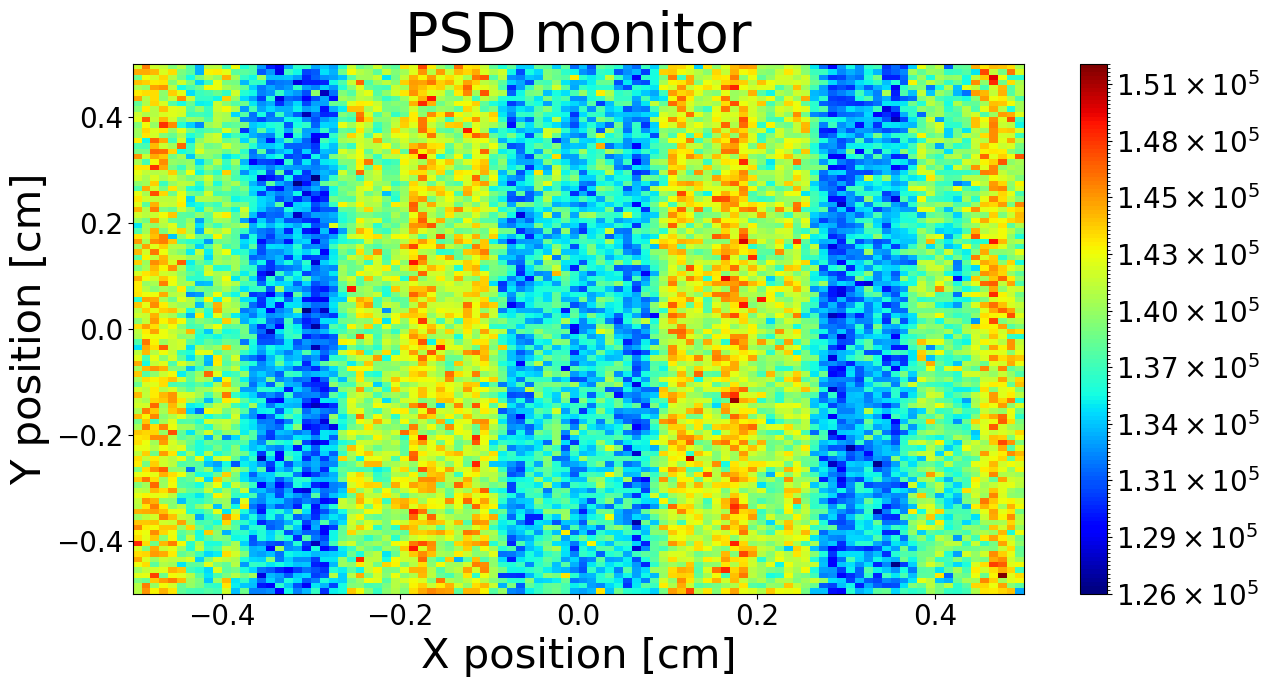

Sim time: 58.325 minutes.


In [22]:
RAY_NUM=1e8 #global control of neutron rays
path = 'Simulations\\Ideal_cur_scan_1e8\\'

time_start = time.time()
cur_scan = do_scan(RAY_NUM,currents,0,pols=True)
time_end = time.time()
print(f'Sim time: {round((time_end-time_start)/60,3)} minutes.')

### Center guide field echo scan

In [13]:
RAY_NUM=1e8 #global control of neutron rays
path = 'Simulations\\CG_scan\\'

CG_currents = np.linspace(2,2.01,10)
MWP_current = get_SS_focus(harms,Ls,res,lam,MWP_parm['a'],L)[4]  #choose one with largest amplitude
print(f'MWP current: {round(MWP_current,3)}')

dfs = np.abs(1e-4*cg_gpa*CG_currents*CL*lam)%(2*np.pi)
print(f'Center guide field (G): {np.round(cg_gpa*CG_currents,3)}')
print(f'Larmor phase mod 2pi: {np.round(dfs,3)}')

"""time_start = time.time()
cur_scan = do_CG_scan(RAY_NUM,CG_currents,pols=True)
time_end = time.time()
print(f'Sim time: {round((time_end-time_start)/60,3)} minutes.')"""

MWP current: 6.166
Center guide field (G): [50.    50.028 50.056 50.083 50.111 50.139 50.167 50.194 50.222 50.25 ]
Larmor phase mod 2pi: [4.622 5.33  6.038 0.462 1.17  1.877 2.585 3.293 4.    4.708]


"time_start = time.time()\ncur_scan = do_CG_scan(RAY_NUM,CG_currents,pols=True)\ntime_end = time.time()\nprint(f'Sim time: {round((time_end-time_start)/60,3)} minutes.')"

### Finding the correct angle-encoding current

### Linear correction mode

***
## Data Analysis
***

### Data Loader

In [26]:
path = 'C:\\Users\\xsm\\Documents\\GitHub\\AER-HFIR-1-23\\Simulations\\'
sim_folder = 'Ideal_cur_scan_1e8\\'

def data_loader(dirs,sort=True,plot=False,N0=True,curscan_format=True):
    """Loads data into tuple of titles and 2D intensities in curscan format."""
    data,counts,curs = [],[],[]
    output_data,titles = [],[]
    for d in islice(os.walk(dirs),1,None):
        lc = d[0].split('\\')[-1][:2]
        cu = d[0].split('\\')[-1][2:]
        counts.append(lc)
        curs.append(float(cu))
        data.append(ms.load_data(d[0])[0].Intensity)
    temp = zip(curs,counts,data)
    if sort: temp = sorted(temp)  #sorts by current, then hc first lc second
    else: temp = list(temp)
    if curscan_format:  #pairs high counts and low counts
        if N0:
            output_data.append([temp[0][2],np.zeros(np.shape(temp[0][2]))])
            titles.append([temp[0][1]+str(temp[0][0]),'---'])
            for k in range(len(temp)//2): 
                output_data.append([temp[2*k+1][2],temp[2*k+2][2]])
                titles.append([temp[2*k+1][1]+str(temp[2*k+1][0]),temp[2*k+2][1]+str(temp[2*k+2][0])])
        else:
            for k in range(len(temp)//2):
                output_data.append([temp[2*k][2],temp[2*k+1][2]])
                titles.append([temp[2*k][1]+str(temp[2*k][0]),temp[2*k+1][1]+str(temp[2*k+1][0])])
        if plot:
            for indx,data in enumerate(output_data):
                fig,axs = plt.subplots(1,2,figsize=(plot_width,plot_height))
                axs[0].set_title(titles[indx][0])
                im1 = axs[0].imshow(data[0],origin='lower')
                axs[1].set_title(titles[indx][1])
                im2 = axs[1].imshow(data[1],origin='lower')
                plt.colorbar(im1,ax=axs[0])
                plt.colorbar(im2,ax=axs[1])
                plt.show()
    else:  #format for normalized intensities
        for k in range(len(temp)):
            output_data.append(temp[k][2])
            titles.append(temp[k][1]+str(temp[k][0]))
        if plot:
            for indx,data in enumerate(output_data):
                fig = plt.figure(figsize=(plot_width,plot_height))
                plt.title(titles[indx])
                plt.imshow(data,origin='lower')
                plt.colorbar()
                plt.show()
    
    return titles,output_data

ts,cur_scan = data_loader(path+sim_folder,curscan_format=True,plot=False)
currents = []
for indx,i in enumerate(ts):
    currents.append(float(i[0][2:]))
print(currents)

[0.0, 1.54, 3.08, 4.62, 6.17, 7.71, 9.25, 10.79, 12.33, 13.87, 15.41]


Need to worry about getting currents from scan, detector size, and other simualtion parameters into the data loader. Works fine for right now, but that will change as soon as I start to compare the signals from slightly different McStas beamlines.

### Extracts polarizations from data

Currents used: [ 0.    1.54  3.08  4.62  6.17  7.71  9.25 10.79 12.33 13.87 15.41] 



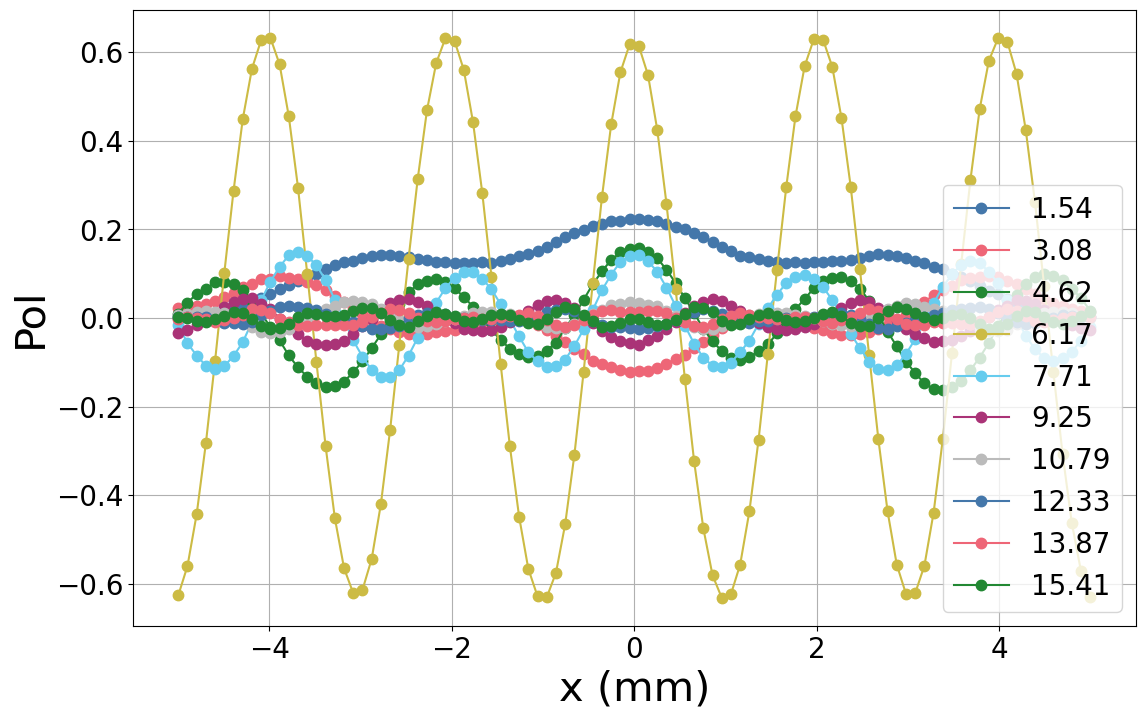

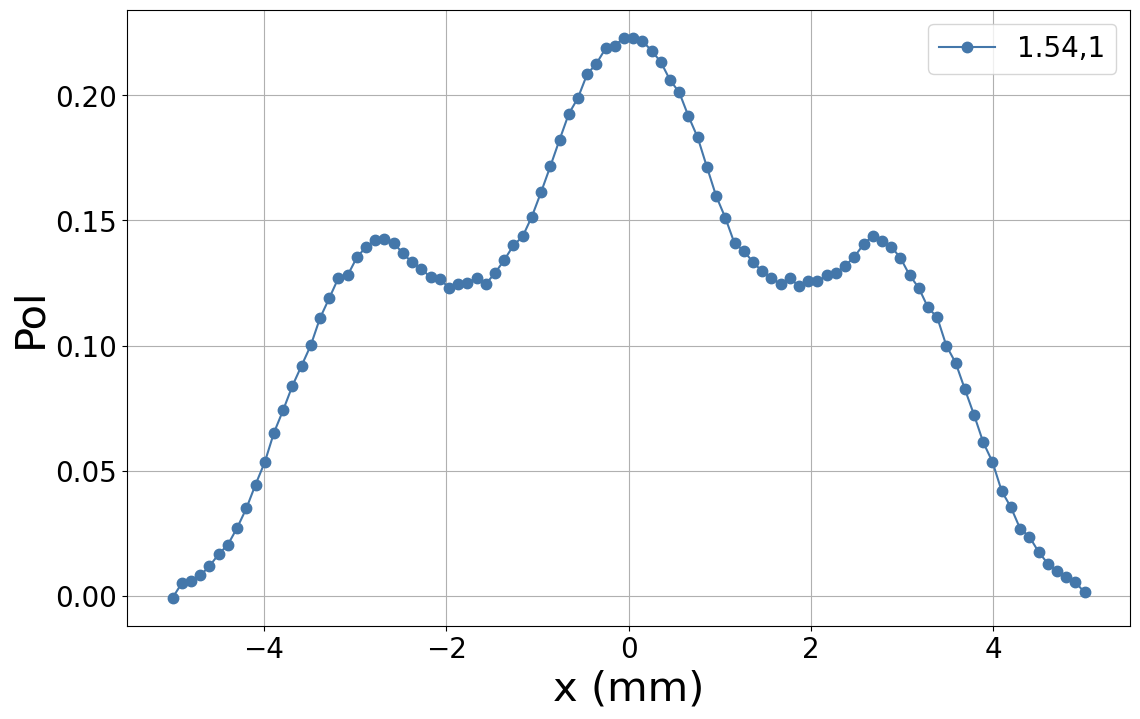

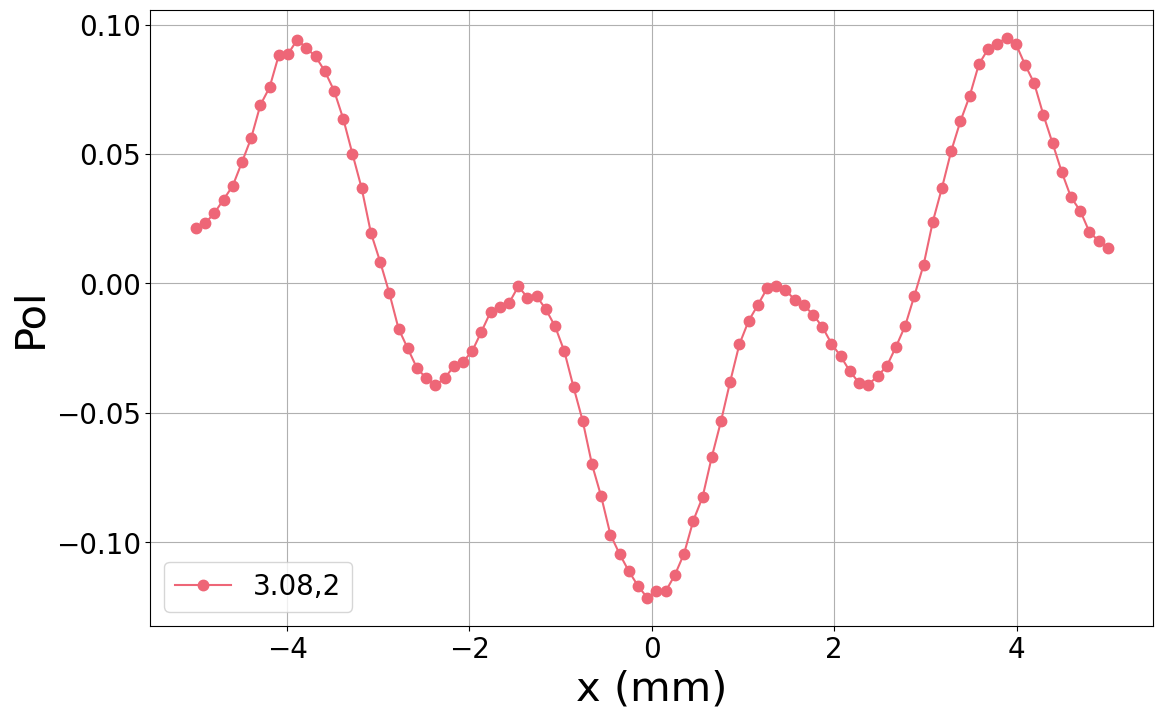

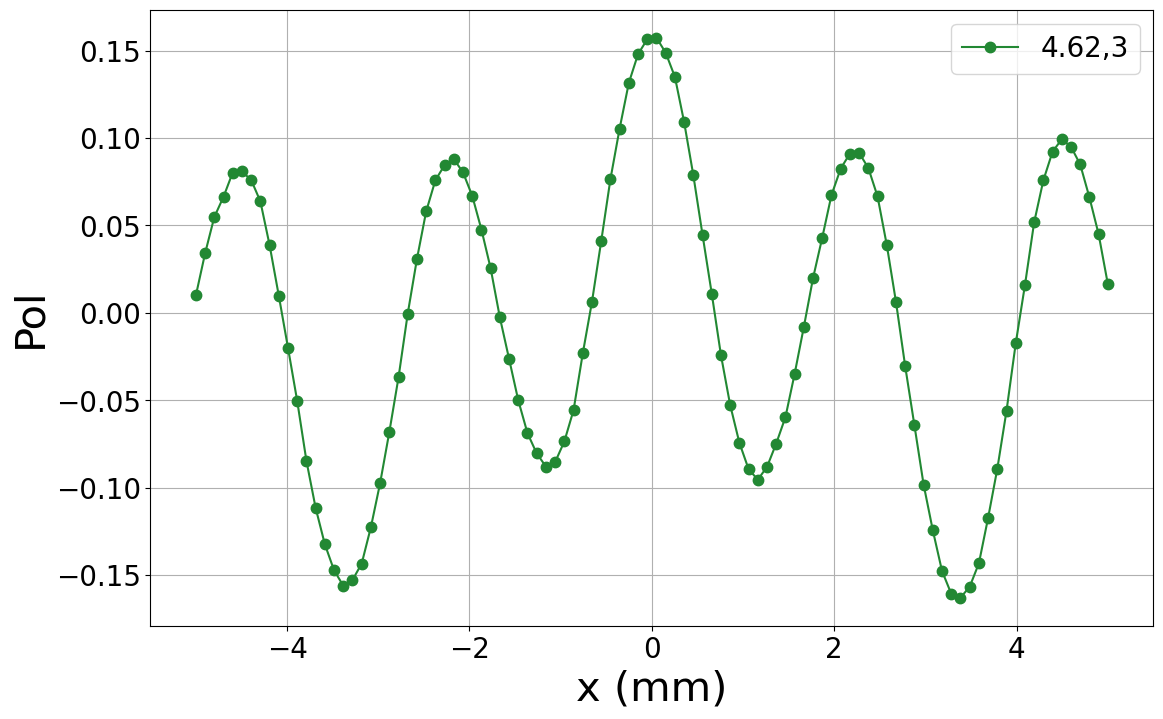

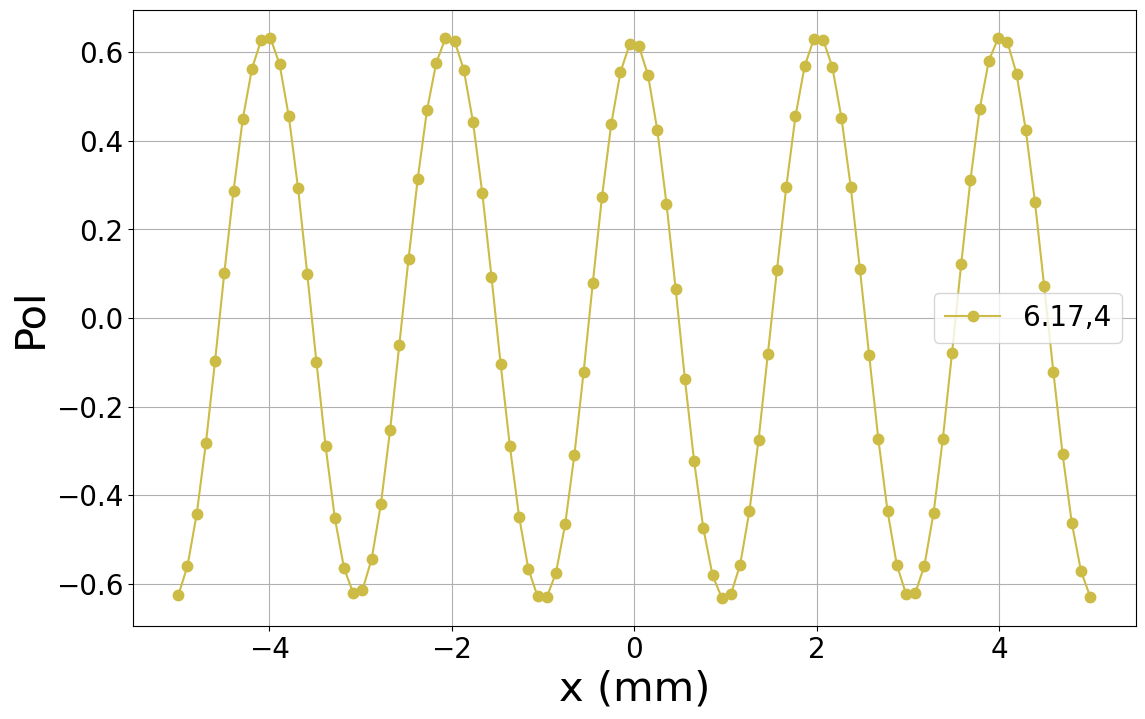

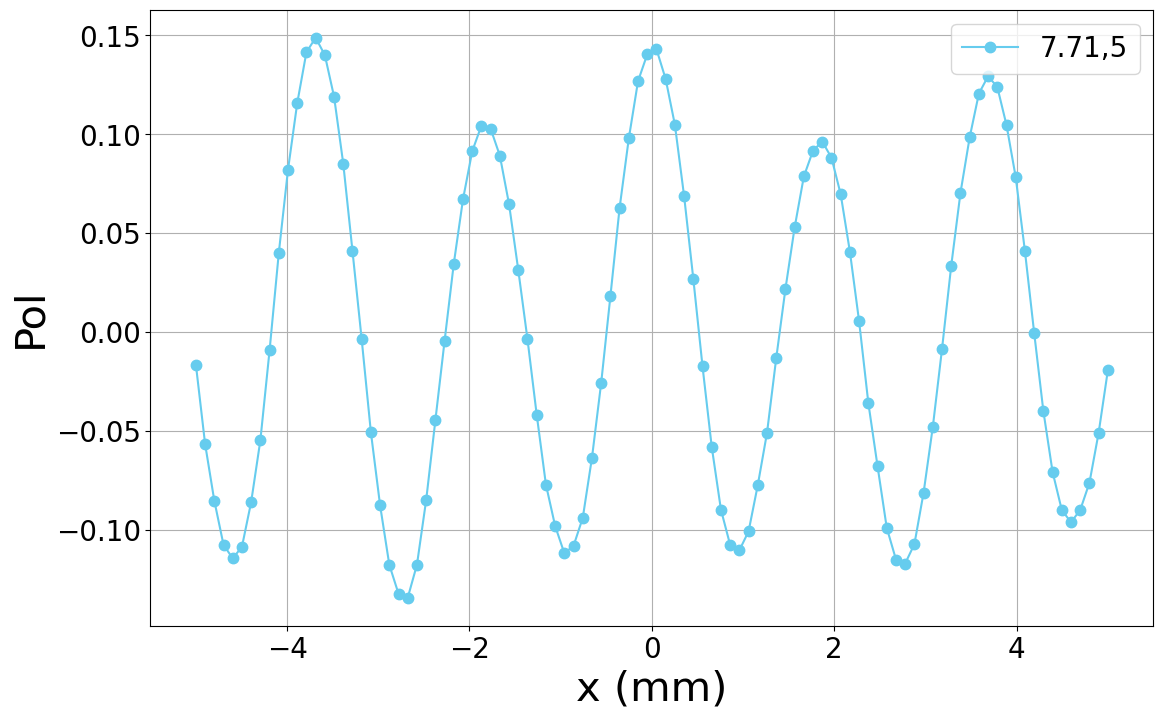

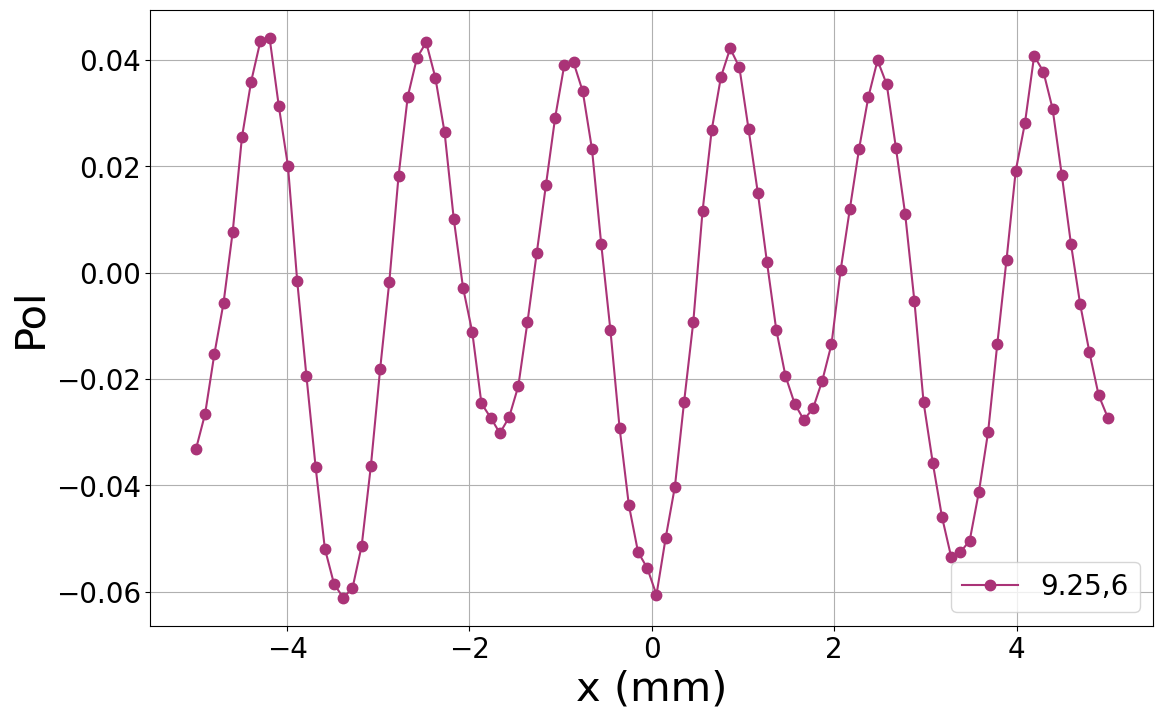

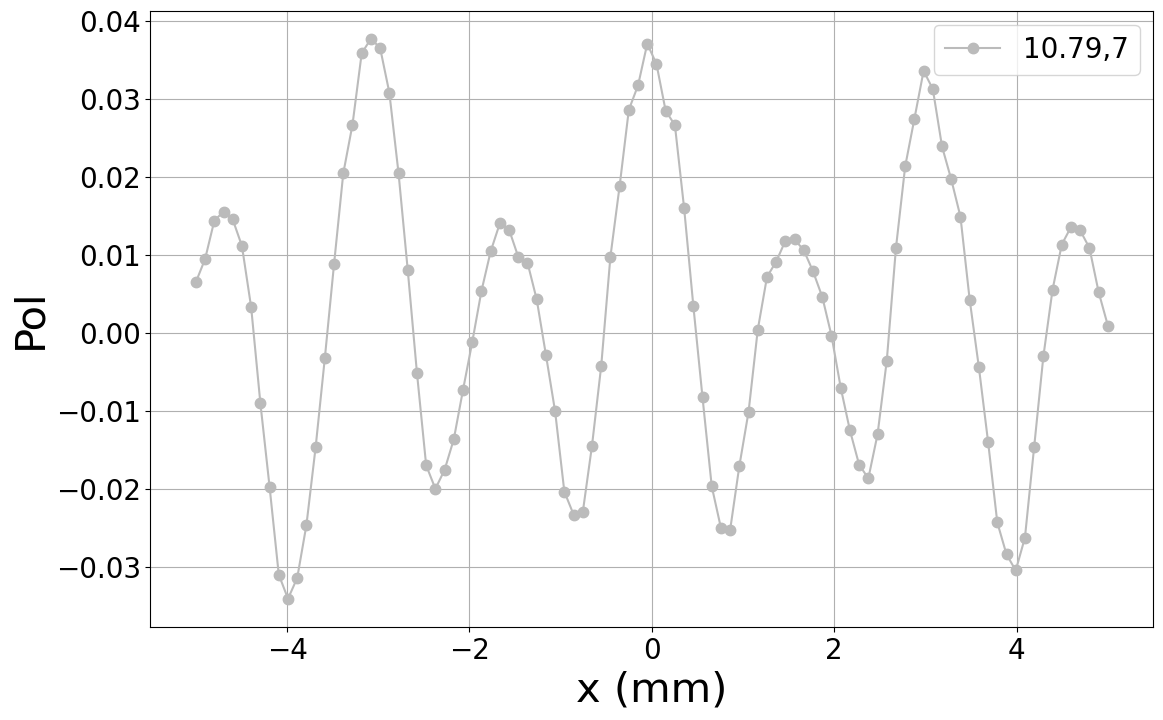

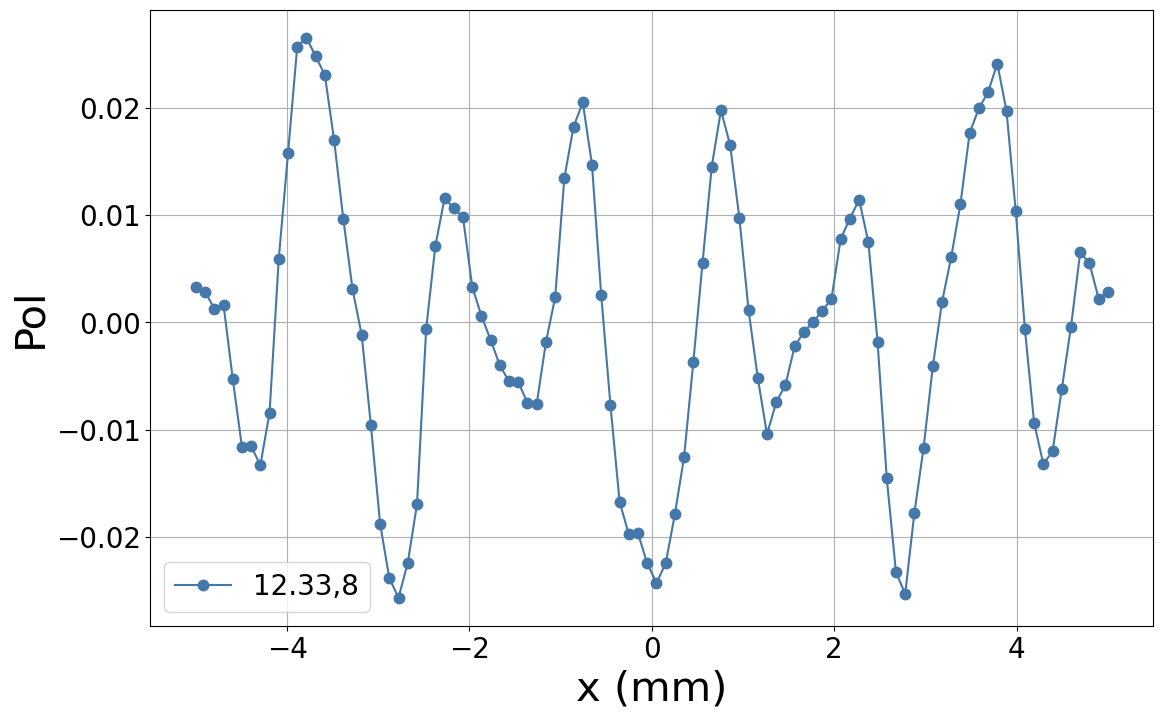

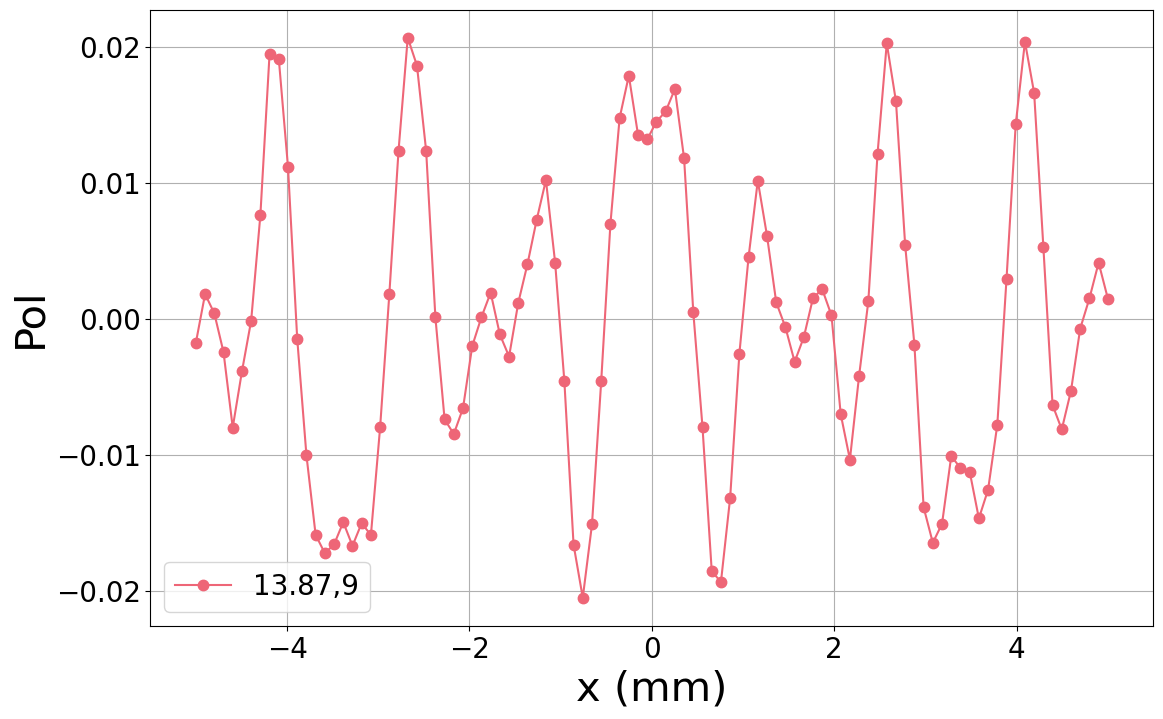

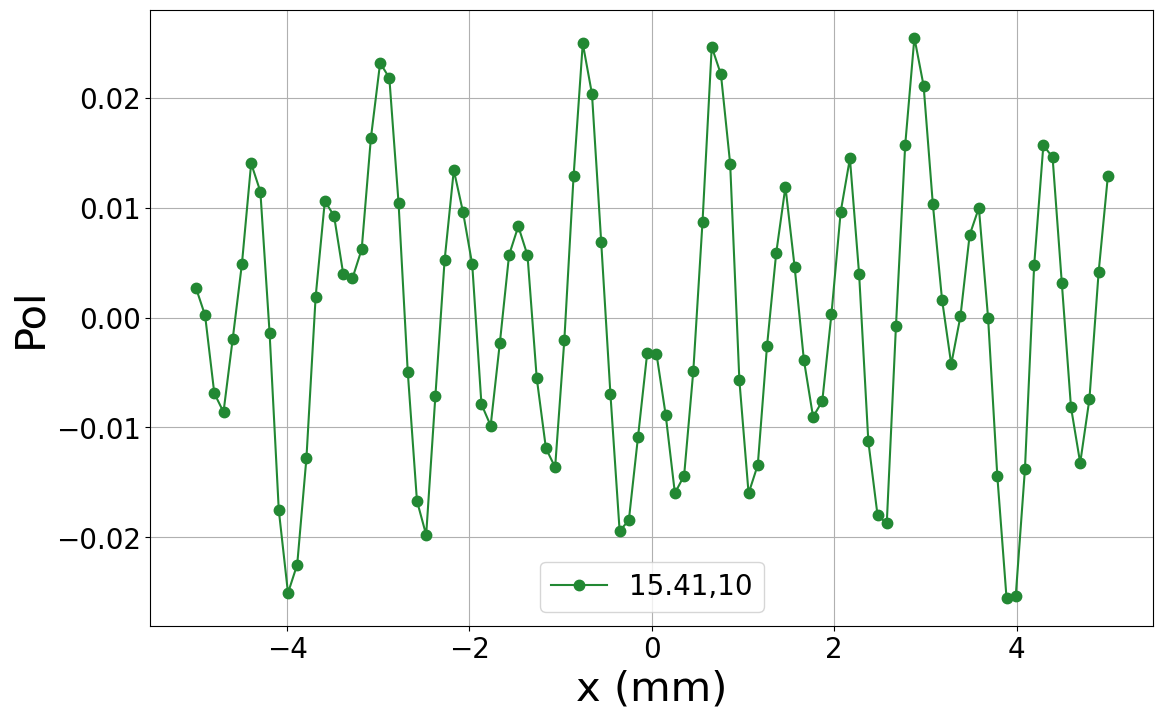

In [27]:
def get_pol(data):
    """Returns 2D polarization from current scans."""
    pol = np.zeros(np.shape(data[0]))
    for indx,val in np.ndenumerate(pol):
        sum = data[0,indx[0],indx[1]] + data[1,indx[0],indx[1]]
        if sum != 0:
            pol[indx[0],indx[1]] = (data[0,indx[0],indx[1]] - data[1,indx[0],indx[1]])/sum
        else:
            pol[indx[0],indx[1]] = 0
    return pol

pols = [get_pol(np.array(cur_scan[1:][i])) for i in range(0,len(cur_scan)-1)] #removing constant scan
print(f'Currents used: {np.round(currents,2)} \n')

plot_pols,plot_slices,plot_all_slices,do_rebin = False,True,True,False
rebin_size = (50,50)
if do_rebin: print(f'New bin size: {round(det_x/rebin_size[0],3)} (mm)')

if plot_pols:
    for indx,p in enumerate(pols):
        fig = plt.figure(figsize=(plot_width,plot_height))
        plt.title(f'Harm. {indx+1}, {round(currents[indx+1],2)} amps')
        plt.tight_layout()
        if do_rebin: p=rebin(p,rebin_size)
        plt.imshow(p,origin='lower',extent=[-det_x/2,det_x/2,-det_y/2,det_y/2],interpolation='none')
        plt.ylabel('y (mm)')
        plt.xlabel('x (mm)')
        plt.colorbar()
        plt.show()

if plot_all_slices:
    fig = plt.figure(figsize=(plot_width,plot_height))
    x = np.linspace(-det_x/2,det_x/2,bin_x)
    for indx,p in enumerate(pols):
        if do_rebin:
            p = rebin(p,rebin_size)
            x = np.linspace(-det_x/2,det_x/2,rebin_size[0])
        plt.plot(x,np.mean(p,axis=0),'.-',ms=15,label=f'{round(currents[indx+1],2)}')
    plt.ylabel('Pol')
    plt.xlabel('x (mm)')
    plt.legend()
    plt.show()
    
if plot_slices:
    x = np.linspace(-det_x/2,det_x/2,bin_x)
    for indx,p in enumerate(pols):
        fig = plt.figure(figsize=(plot_width,plot_height))
        if do_rebin:
            p = rebin(p,rebin_size)
            x = np.linspace(-det_x/2,det_x/2,rebin_size[0])
        plt.plot(x,np.mean(p,axis=0),'.-',ms=15,label=f'{round(currents[indx+1],2)},{indx+1}',color=f'C{indx}')
        plt.ylabel('Pol')
        plt.xlabel('x (mm)')
        plt.legend()
        plt.show()

***
### Extracts normed intensities from data
***

Currents used: [ 0.    1.54  3.08  4.62  6.17  7.71  9.25 10.79 12.33 13.87 15.41] 



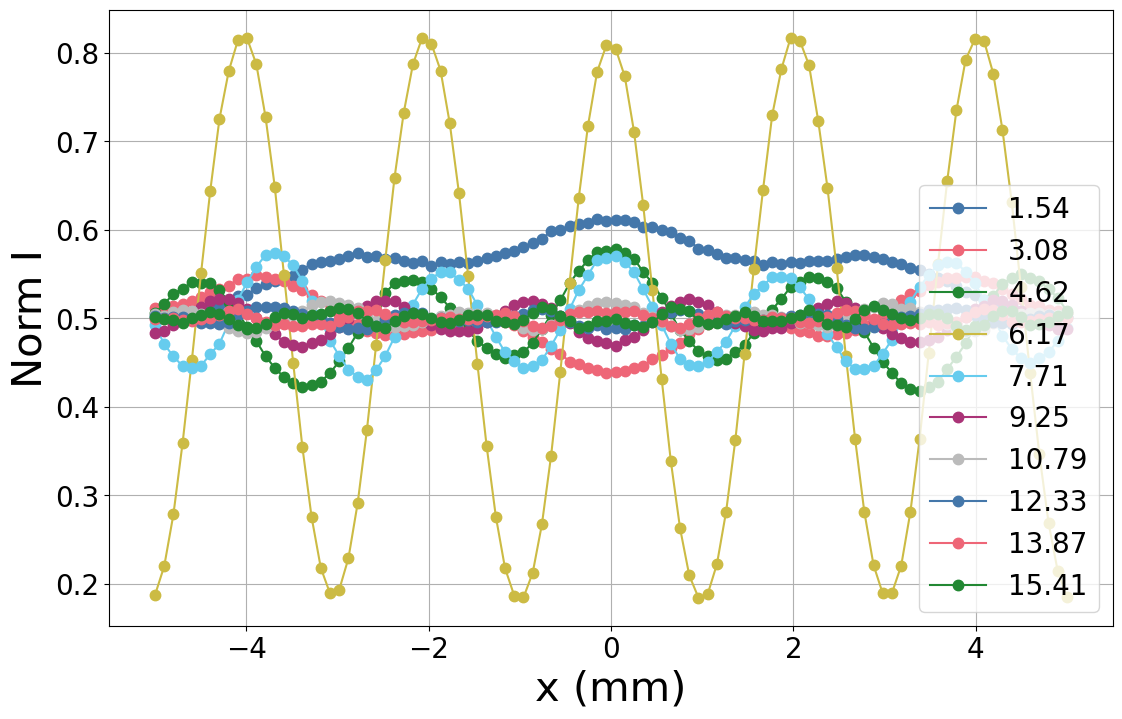

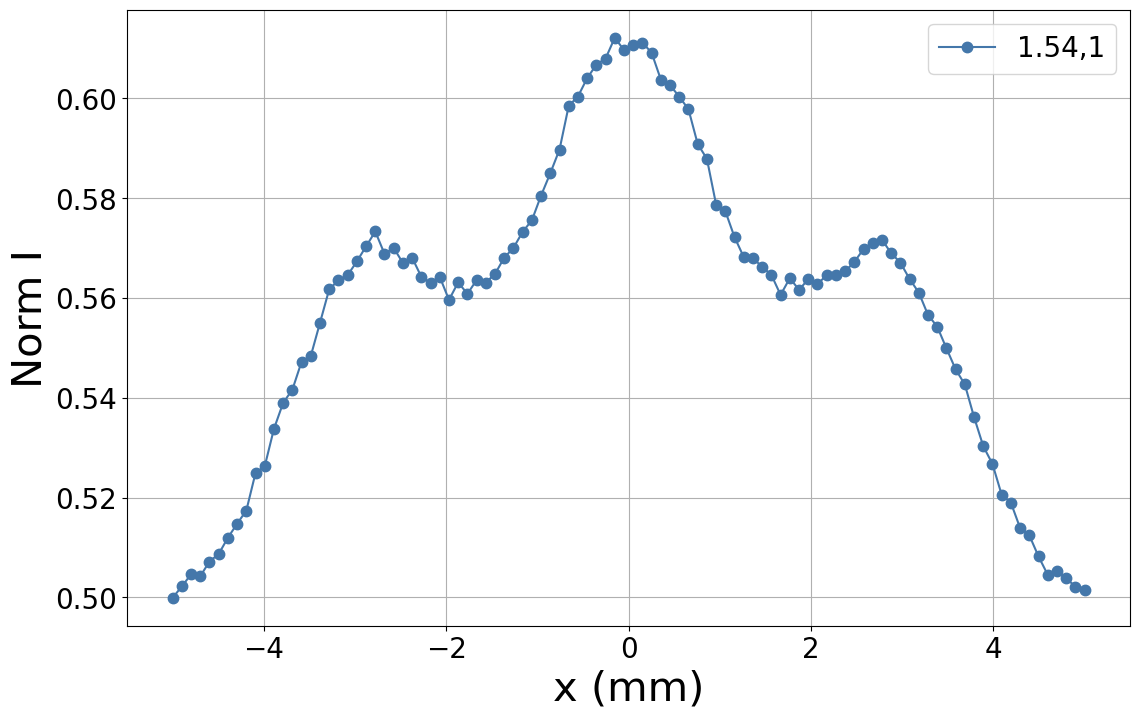

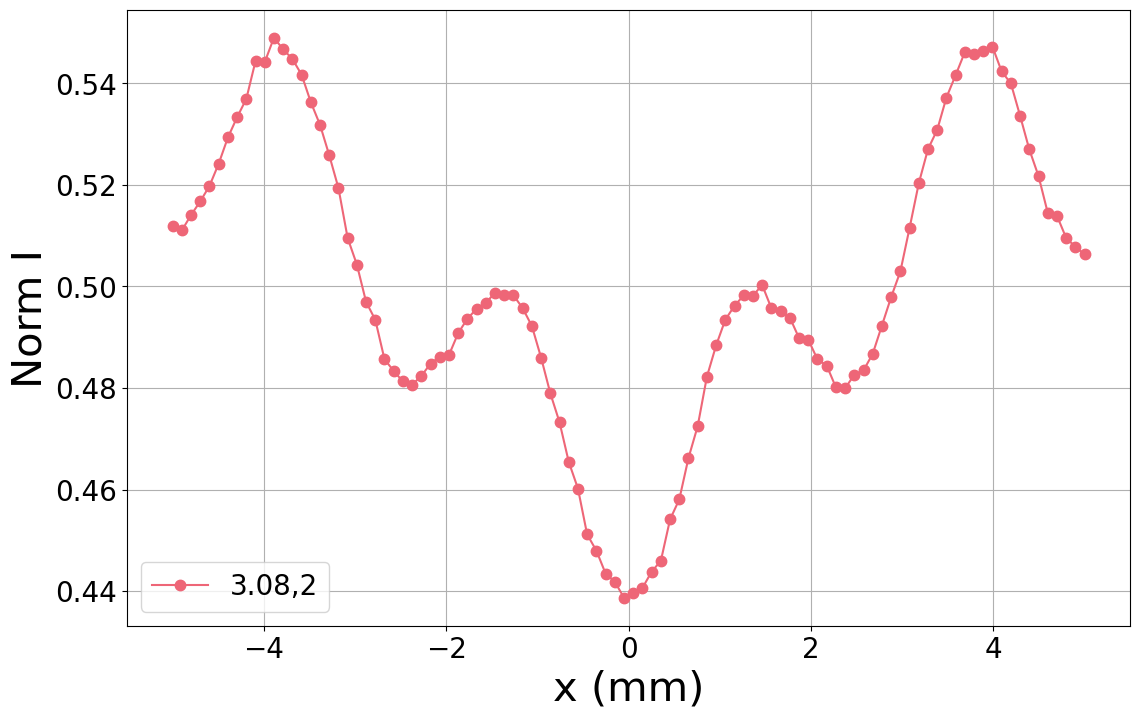

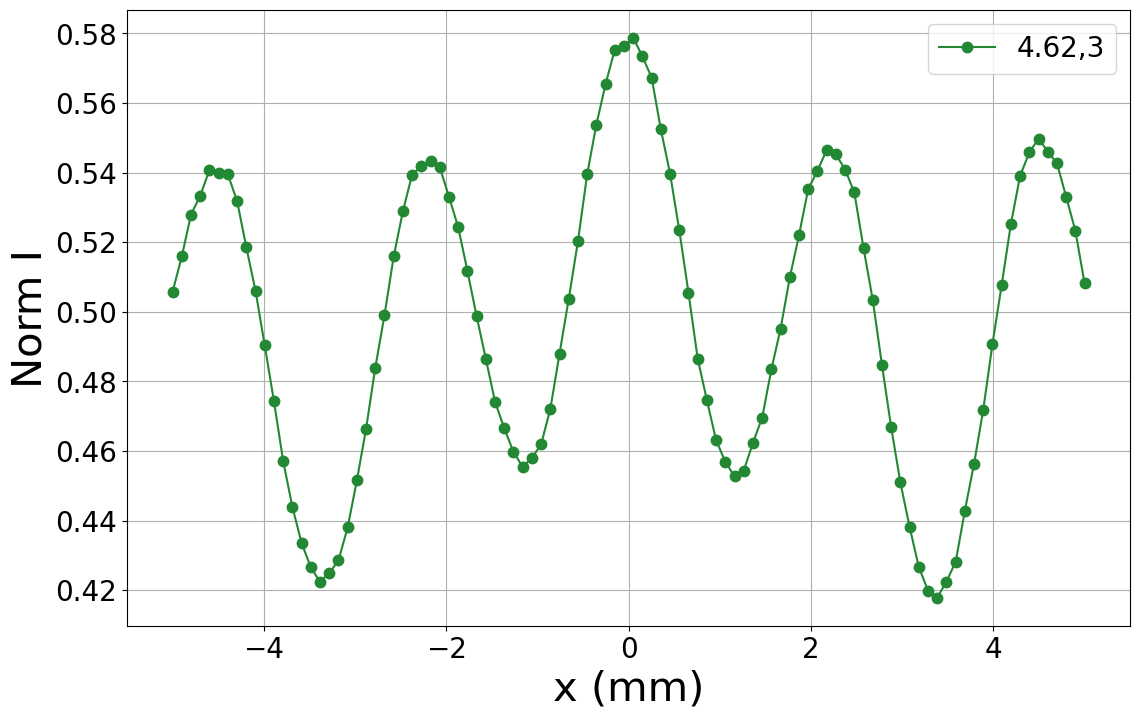

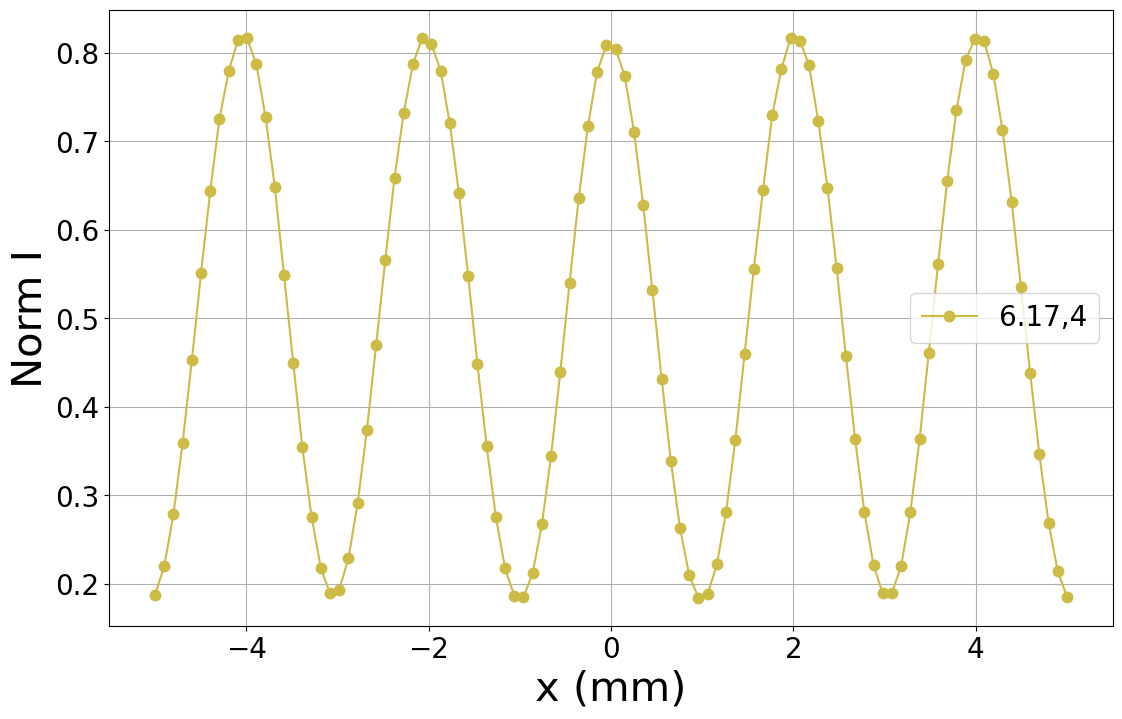

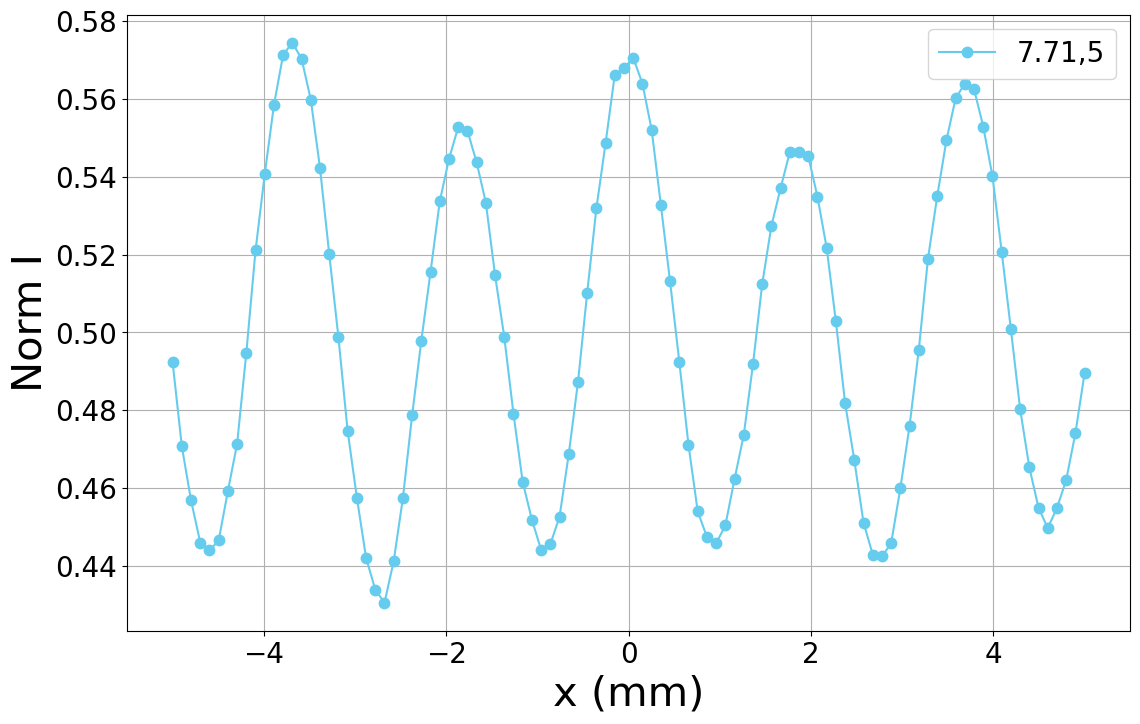

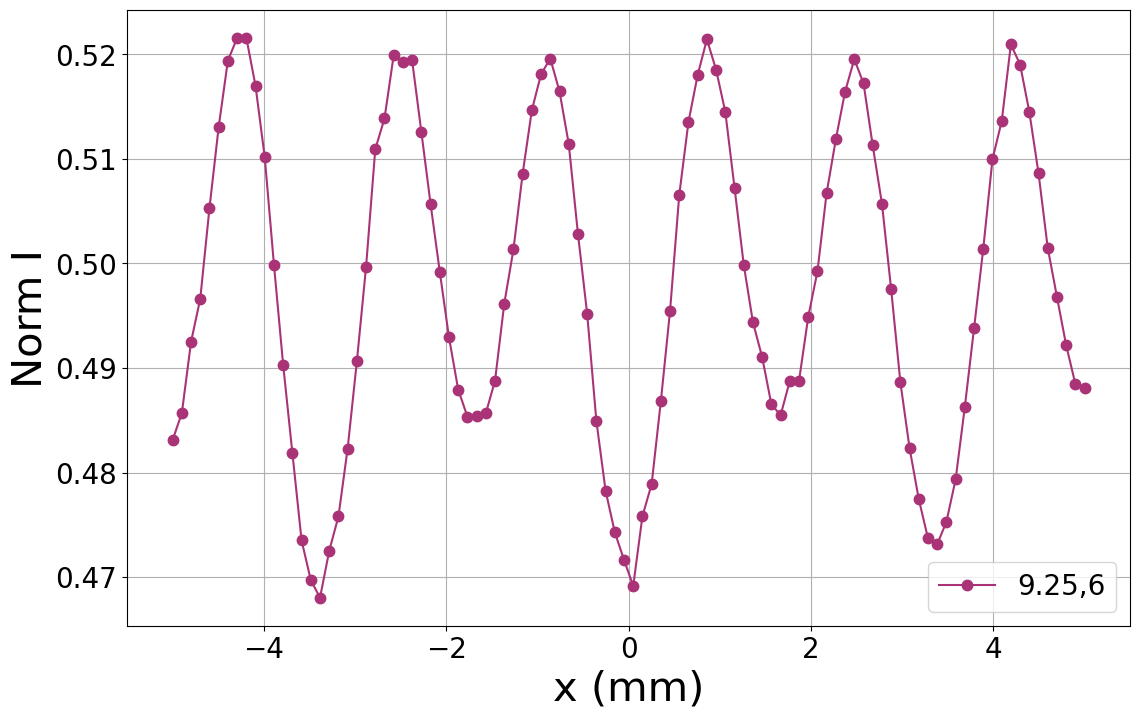

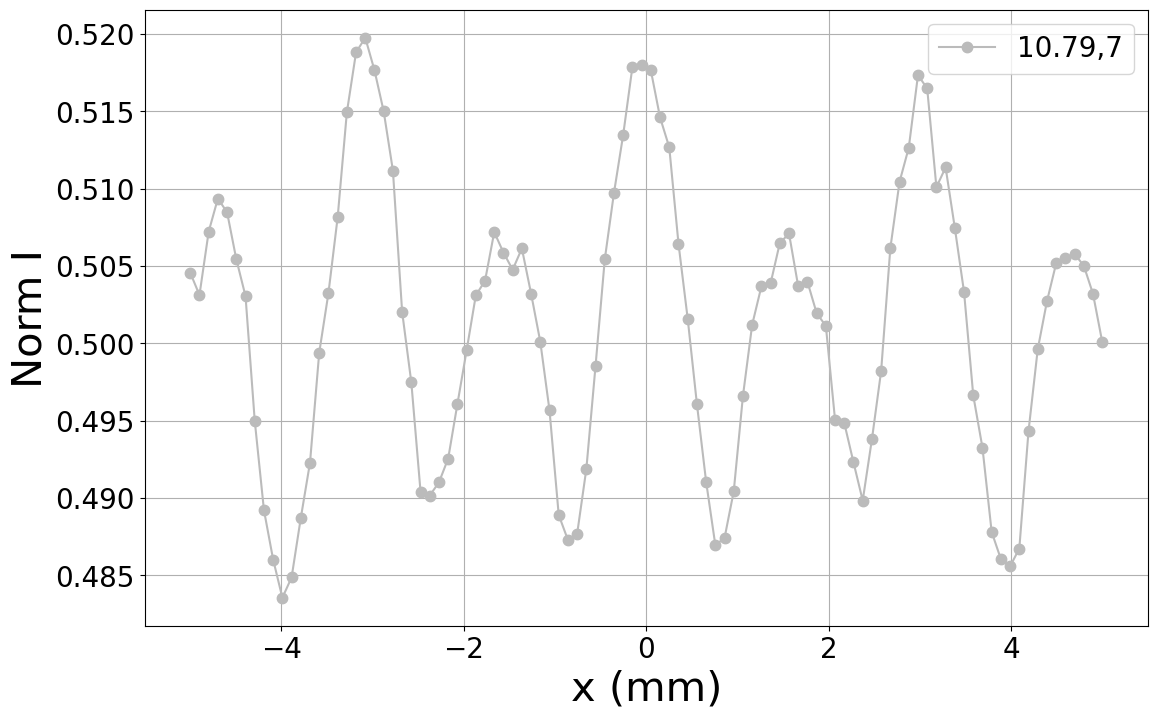

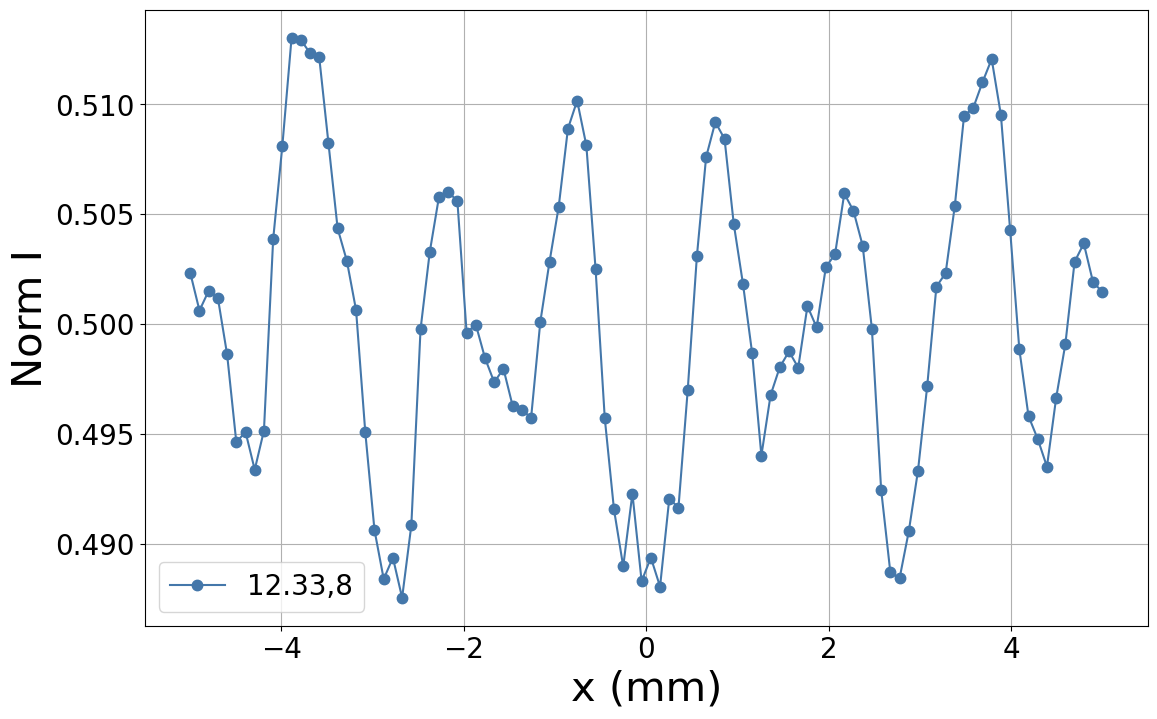

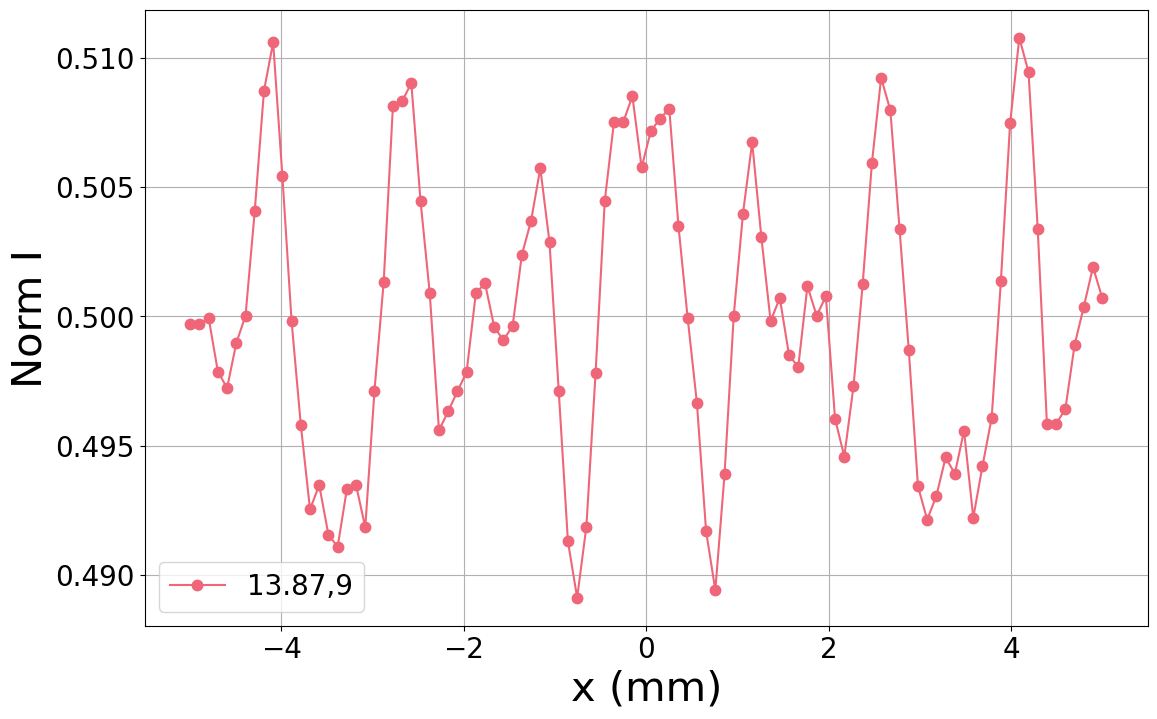

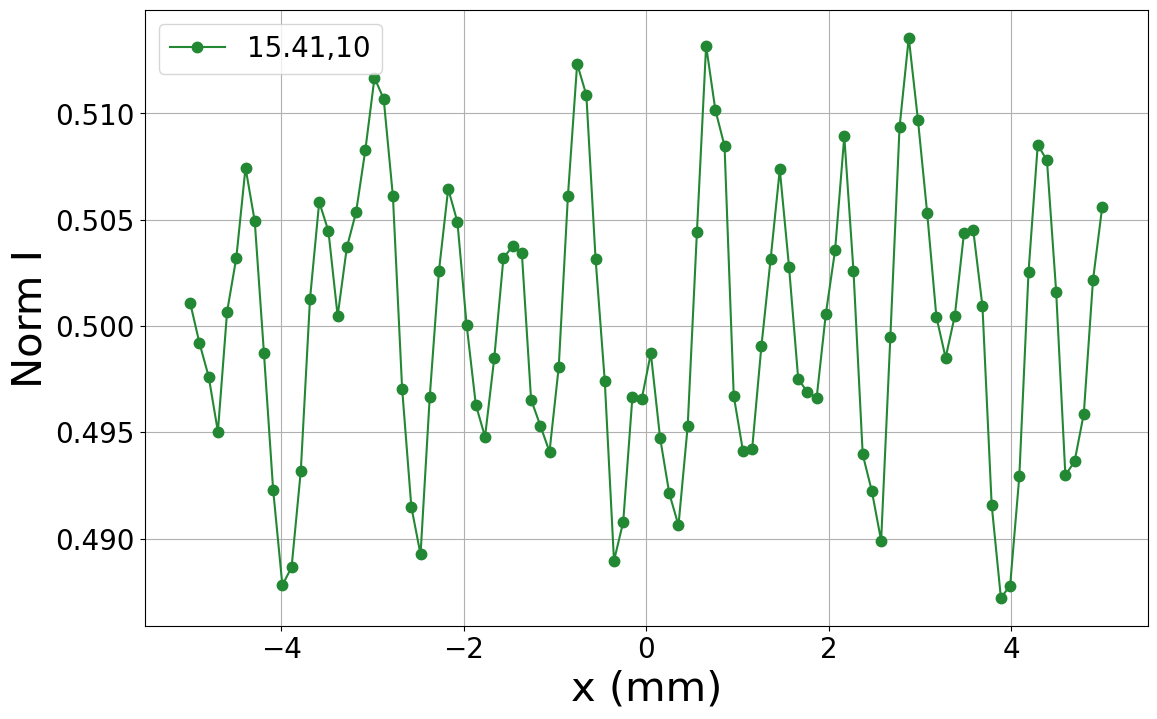

In [28]:
def get_ni(data,zeroth):
    """Returns 2D N_0 normalized intensity from current scans."""
    nint = np.zeros(np.shape(data[0]))
    for indx,val in np.ndenumerate(nint):
        if zeroth[indx[0],indx[1]] != 0:
            nint[indx[0],indx[1]] = data[0,indx[0],indx[1]]/zeroth[indx[0],indx[1]]
    return nint

nints = [get_ni(np.array(cur_scan[1:][i]),np.array(cur_scan[0][0])) for i in range(0,len(cur_scan)-1)] #removing constant scan
print(f'Currents used: {np.round(currents,2)} \n')

plot_nints,plot_slices,plot_all_slices,do_rebin = False,True,True,False
rebin_size = (50,50)
if do_rebin: print(f'New bin size: {round(det_x/rebin_size[0],3)} (mm)')

if plot_nints:
    for indx,n in enumerate(nints):
        fig = plt.figure(figsize=(plot_width,plot_height))
        plt.title(f'Harm. {indx+1}, {round(currents[indx+1],2)} amps')
        plt.tight_layout()
        if do_rebin: n=rebin(p,rebin_size)
        plt.imshow(n,origin='lower',extent=[-det_x/2,det_x/2,-det_y/2,det_y/2],interpolation='none')
        plt.ylabel('y (mm)')
        plt.xlabel('x (mm)')
        plt.colorbar()
        plt.show()

if plot_all_slices:
    fig = plt.figure(figsize=(plot_width,plot_height))
    x = np.linspace(-det_x/2,det_x/2,bin_x)
    for indx,n in enumerate(nints):
        if do_rebin:
            n = rebin(n,rebin_size)
            x = np.linspace(-det_x/2,det_x/2,rebin_size[0])
        plt.plot(x,np.mean(n,axis=0),'.-',ms=15,label=f'{round(currents[indx+1],2)}')
    plt.ylabel('Norm I')
    plt.xlabel('x (mm)')
    plt.legend()
    plt.show()

if plot_slices:
    x = np.linspace(-det_x/2,det_x/2,bin_x)
    for indx,n in enumerate(nints):
        fig = plt.figure(figsize=(plot_width,plot_height))
        if do_rebin:
            n = rebin(n,rebin_size)
            x = np.linspace(-det_x/2,det_x/2,rebin_size[0])
        plt.plot(x,np.mean(n,axis=0),'.-',ms=15,label=f'{round(currents[indx+1],2)},{indx+1}',color=f'C{indx}')
        envelope = np.mean(n,axis=0)/np.abs(hilbert(np.mean(n,axis=0)))
        #plt.plot(x,envelope,'--',color=f'C{indx}')
        #plt.plot(x,-envelope,'--',color=f'C{indx}')
        plt.ylabel('Norm I')
        plt.xlabel('x (mm)')
        plt.legend()
        plt.show()

***
## Analytical and Simulated Comparison
***

Simulated Fourier coefficients:
	 a1 = 0.223, b1 = 0.00063
	 a2 = -0.12061, b2 = -0.00113
	 a3 = 0.158, b3 = 0.0056
	 a4 = 0.61855, b4 = -0.02298
	 a5 = 0.14207, b5 = 0.00958
	 a6 = -0.05794, b6 = 0.00646
	 a7 = 0.03519, b7 = -0.00493
	 a8 = -0.02317, b8 = 0.00338
	 a9 = 0.01486, b9 = -0.00227
	 a10 = -0.00619, b10 = 0.00629
Analytic Fourier coefficients:
	 a1 = -0.00547, b1 = 0.0
	 a2 = -0.00717, b2 = 0.0
	 a3 = -0.01338, b3 = -0.0
	 a4 = 0.63983, b4 = -0.0
	 a5 = 0.01291, b5 = -0.0
	 a6 = 0.00703, b6 = 0.0
	 a7 = 0.00548, b7 = 0.0
	 a8 = 0.005, b8 = 0.0
	 a9 = 0.00558, b9 = -0.0
	 a10 = 0.0072, b10 = 0.0


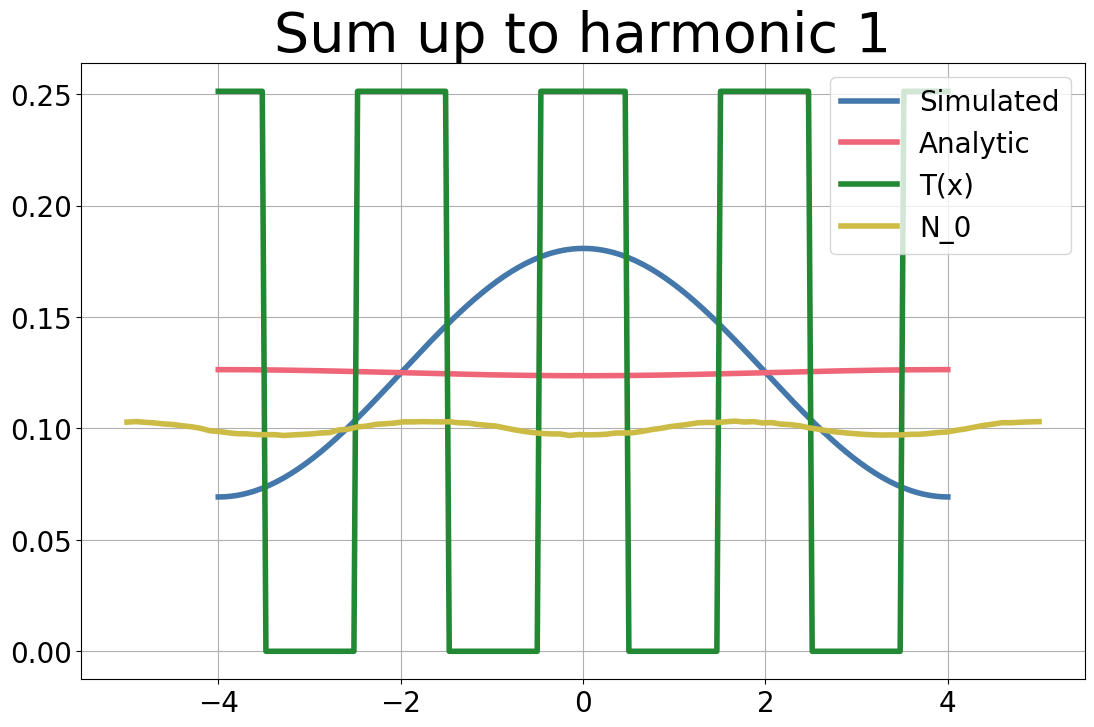

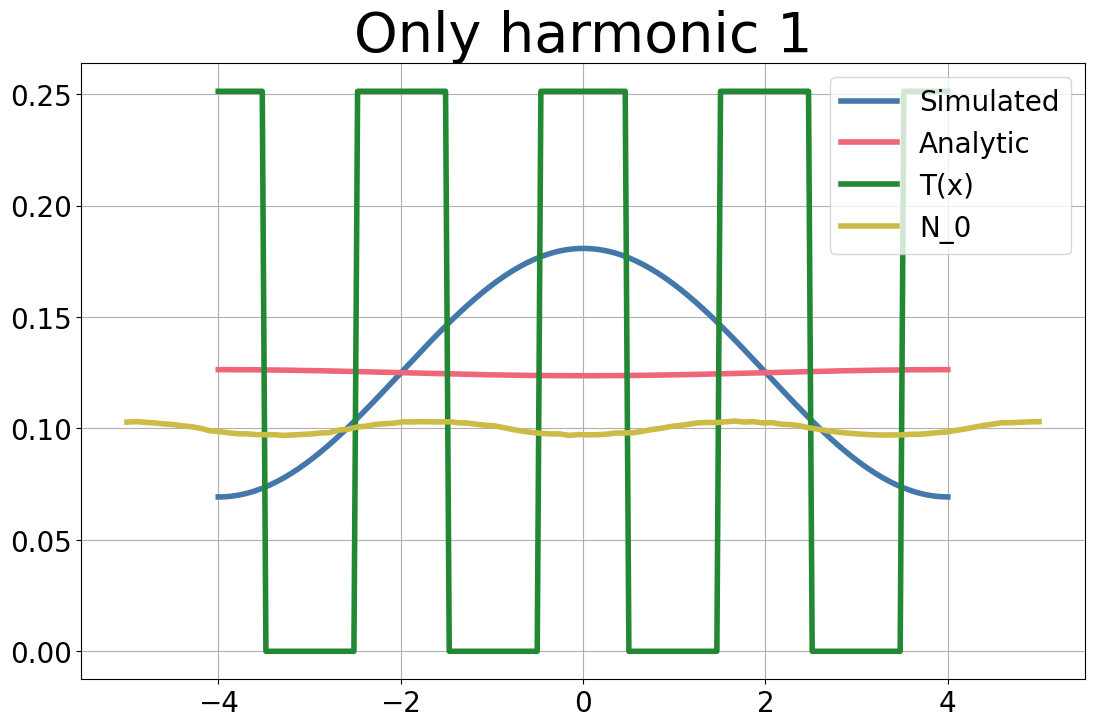

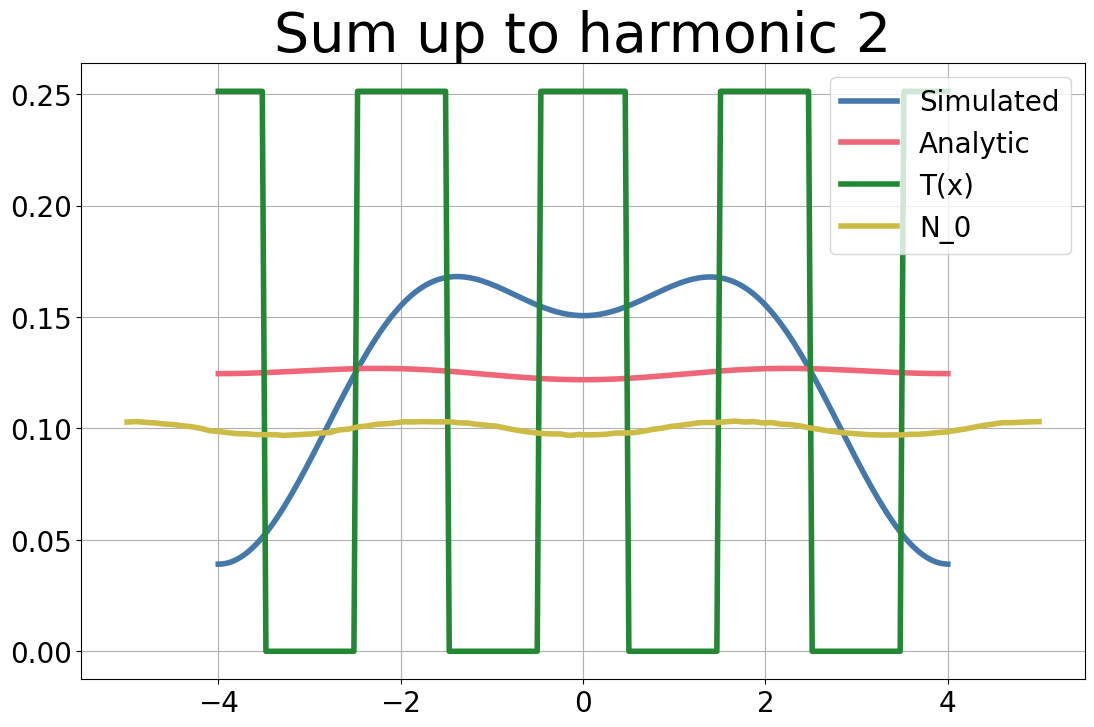

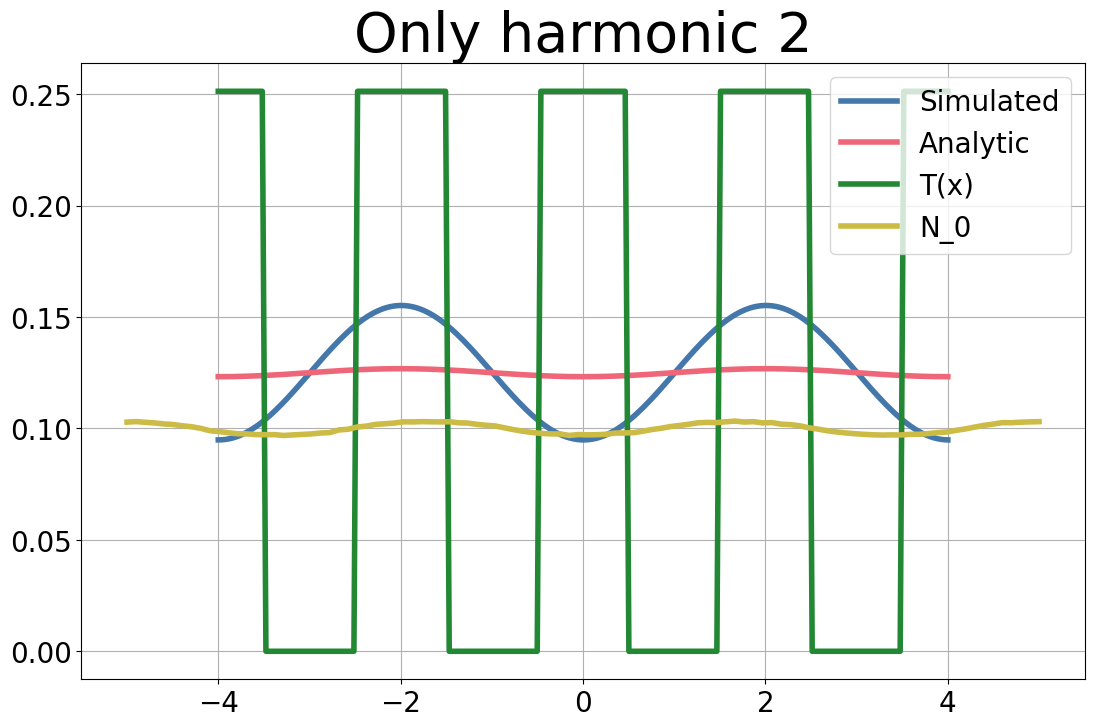

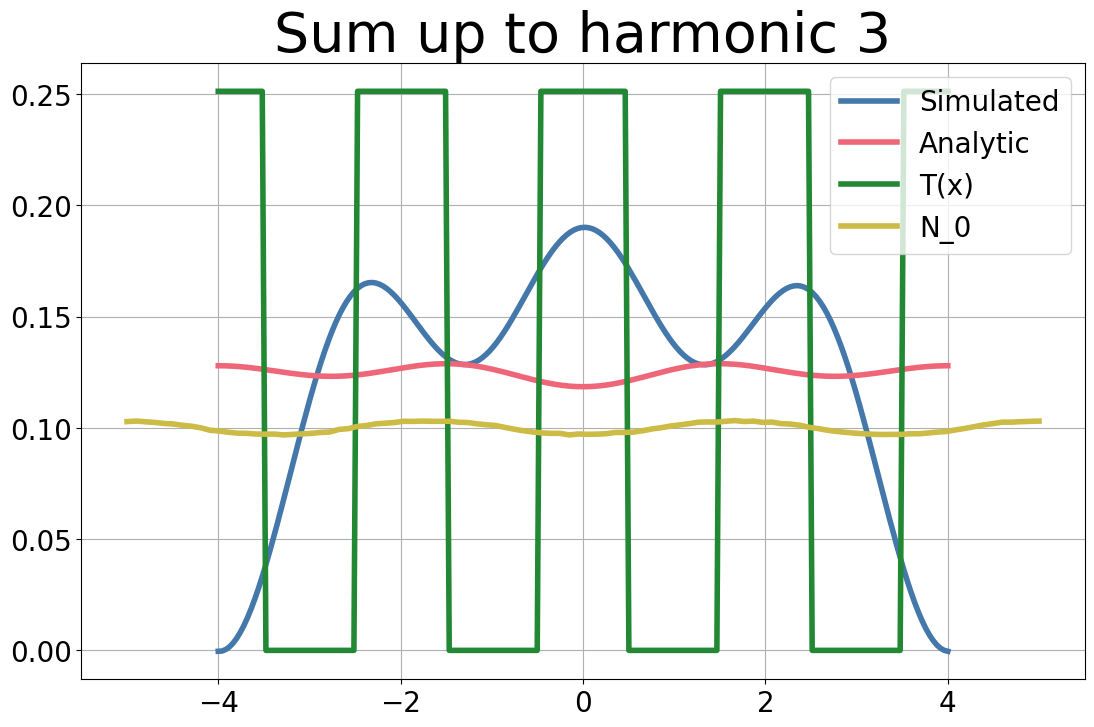

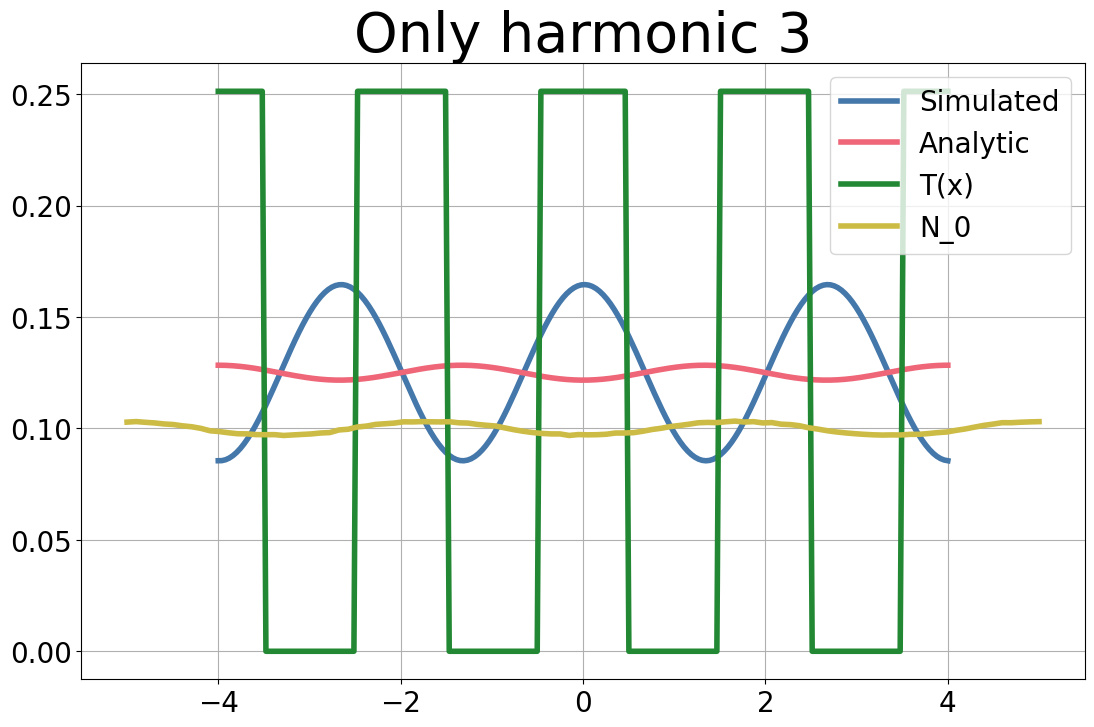

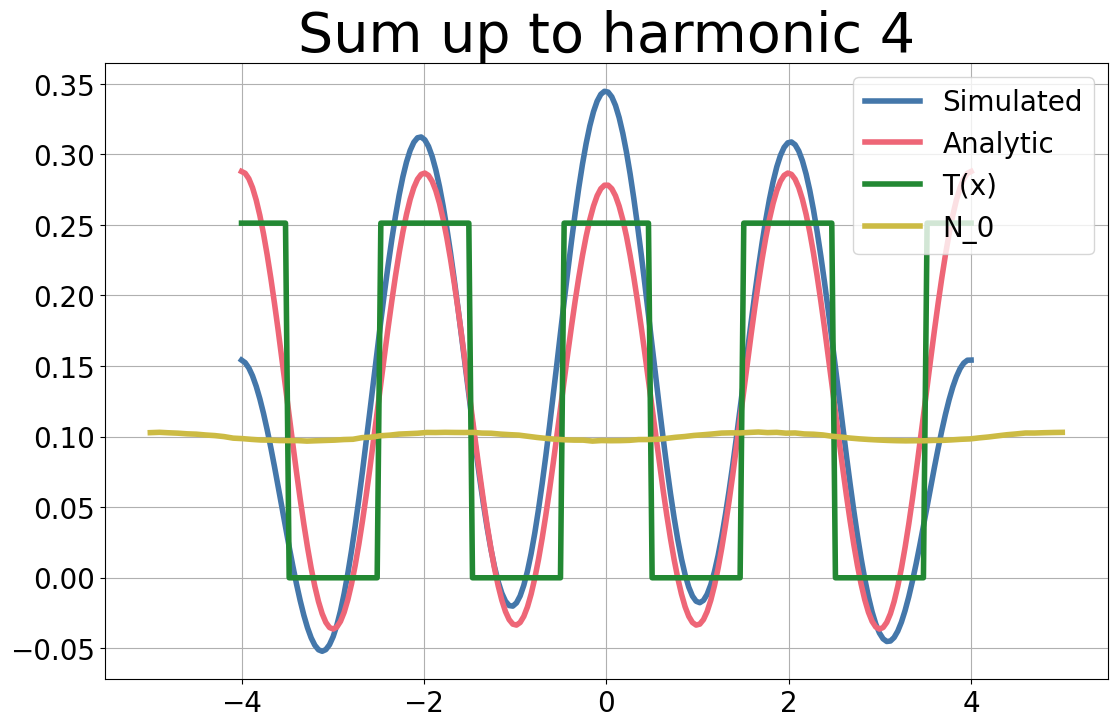

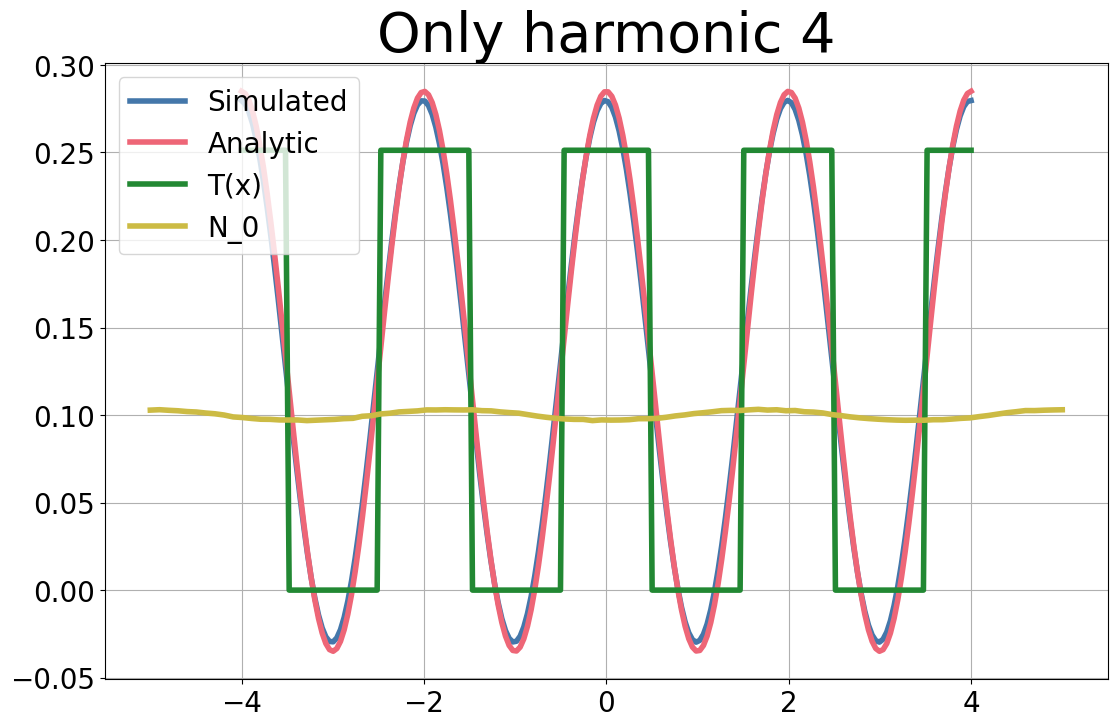

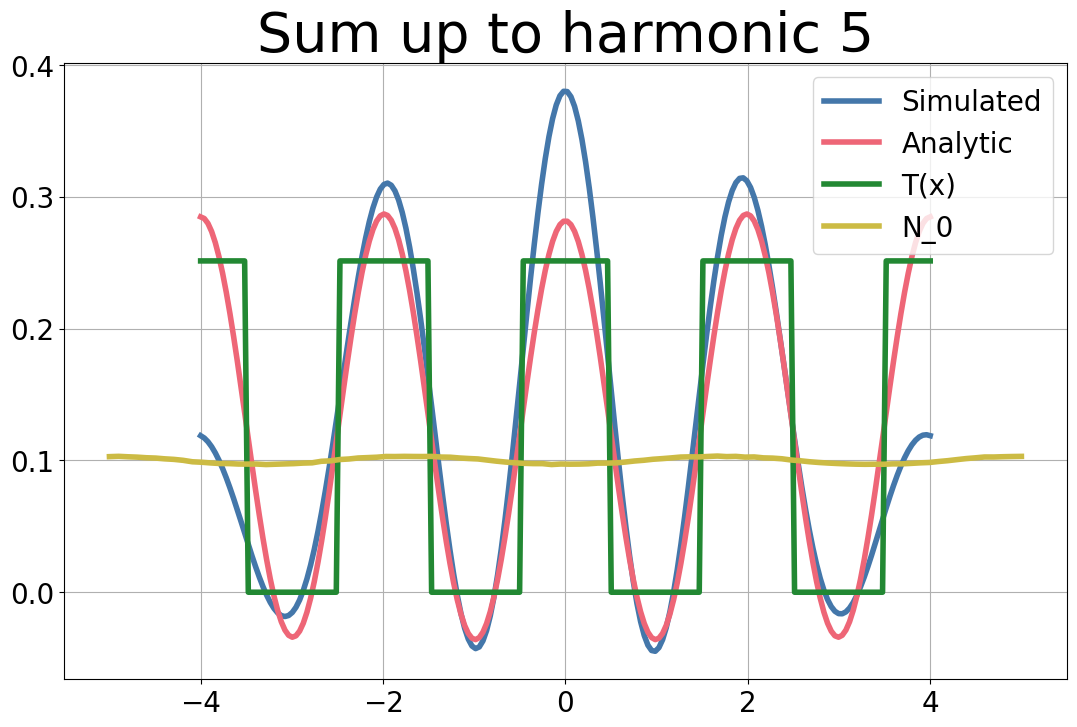

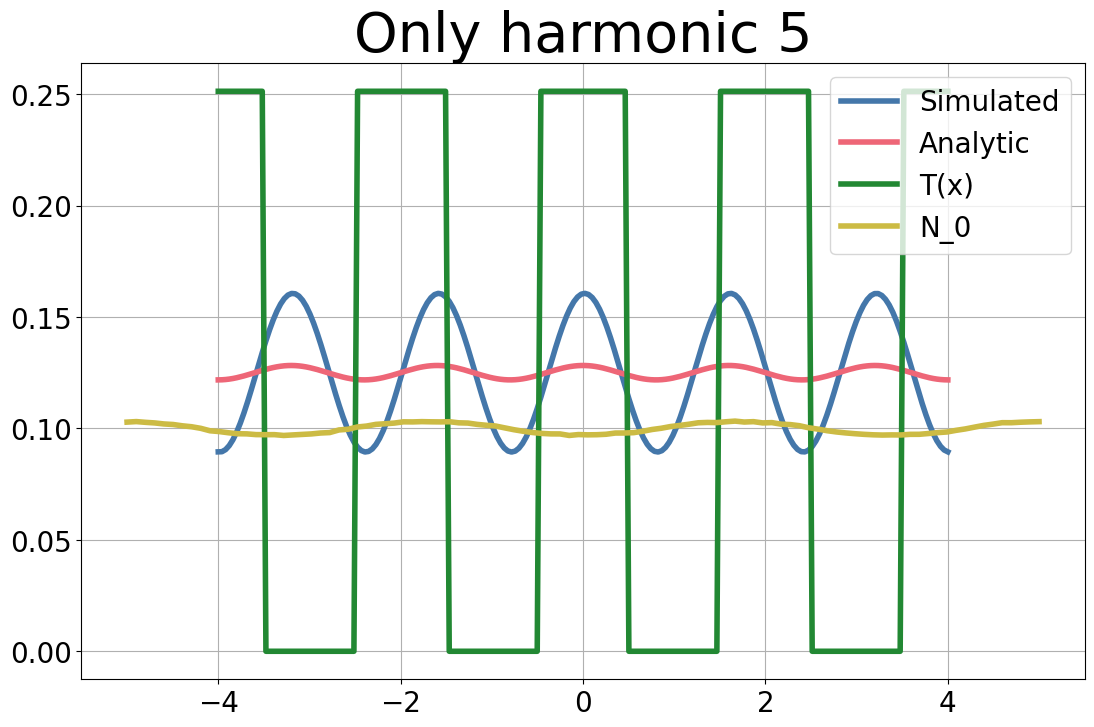

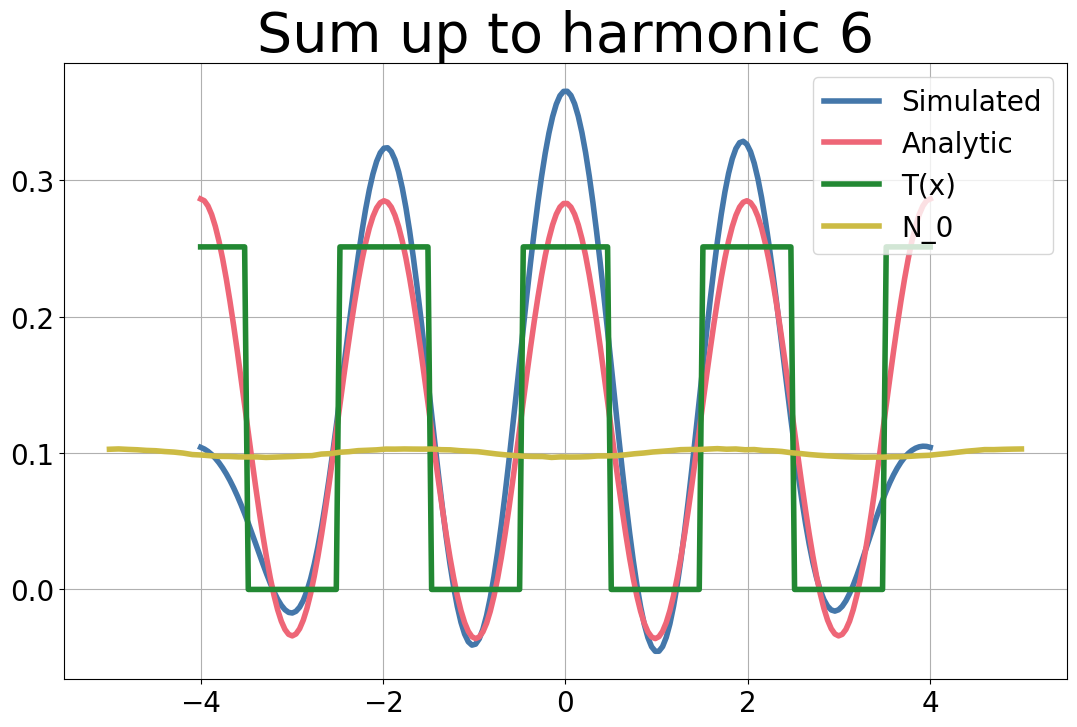

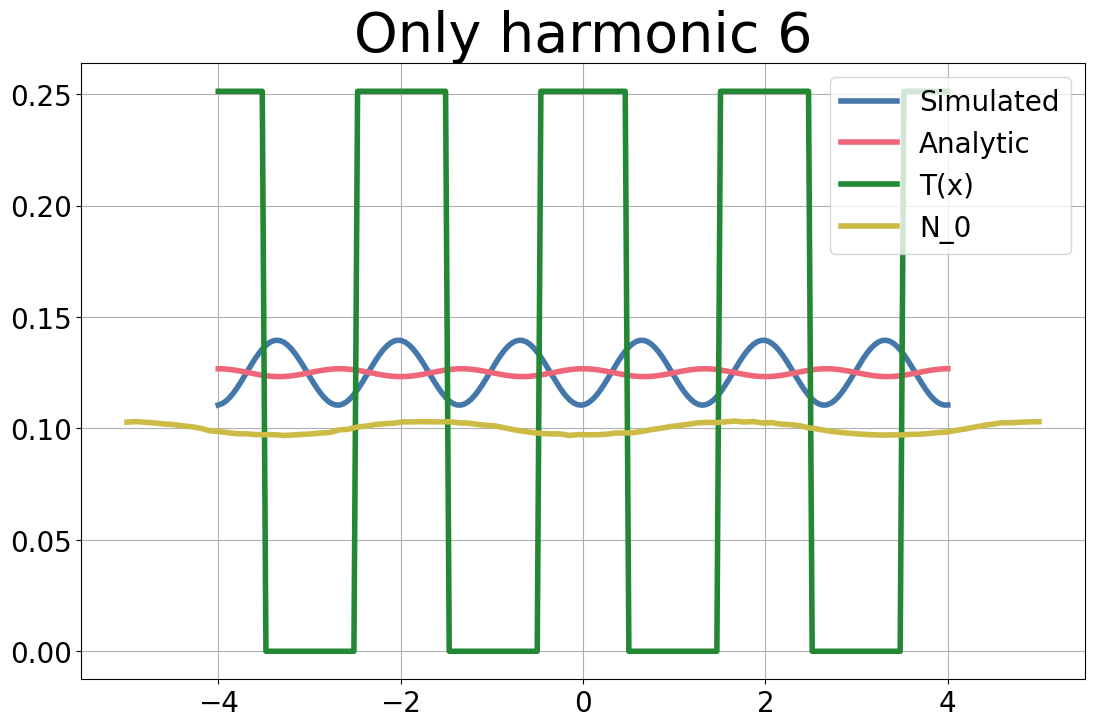

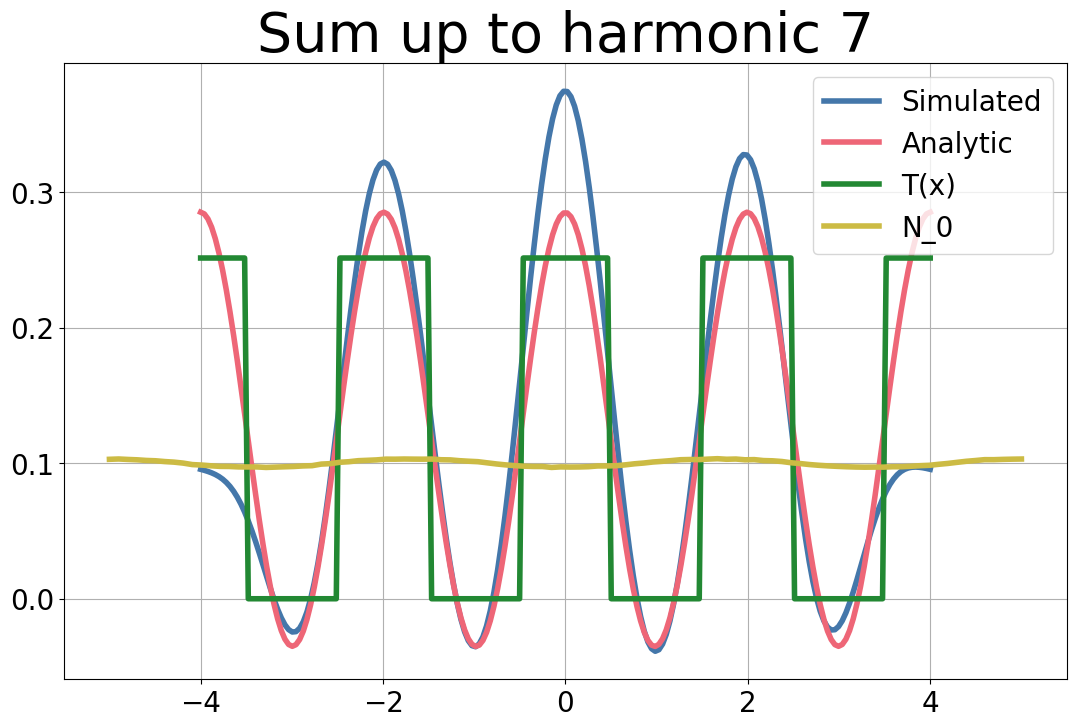

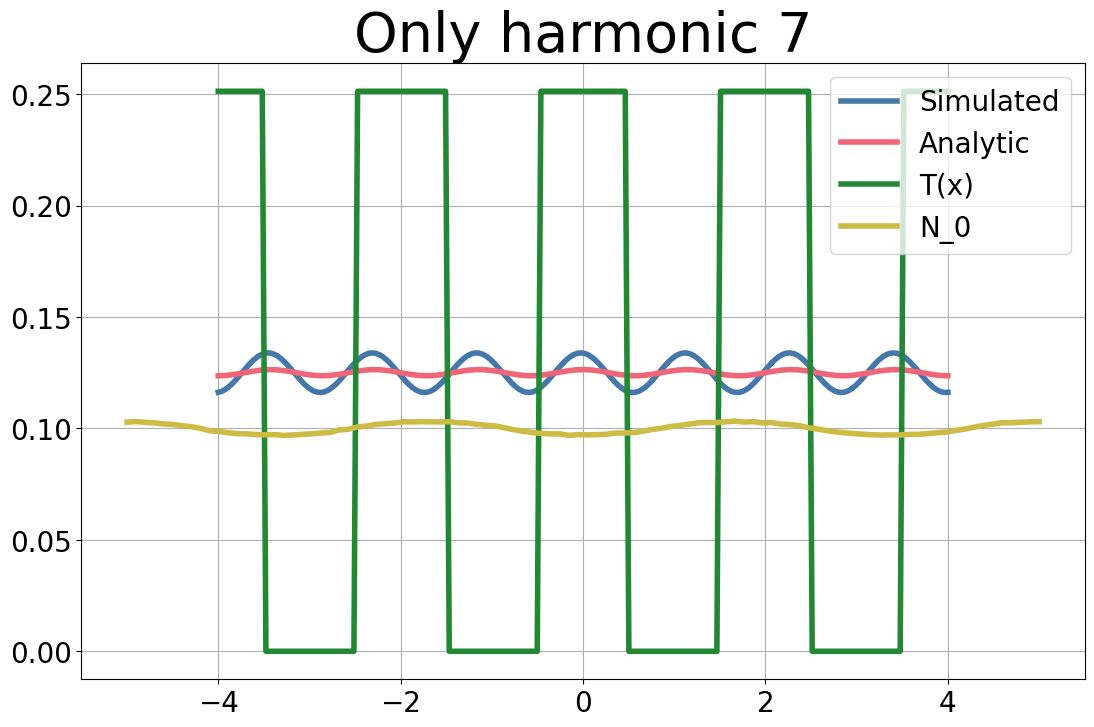

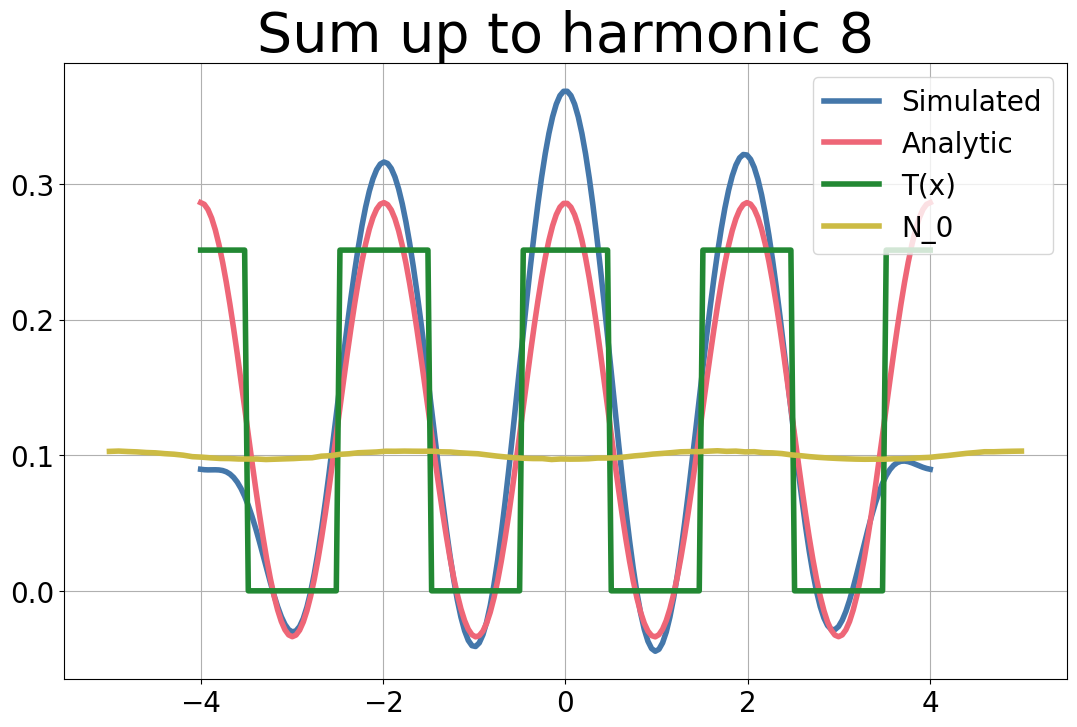

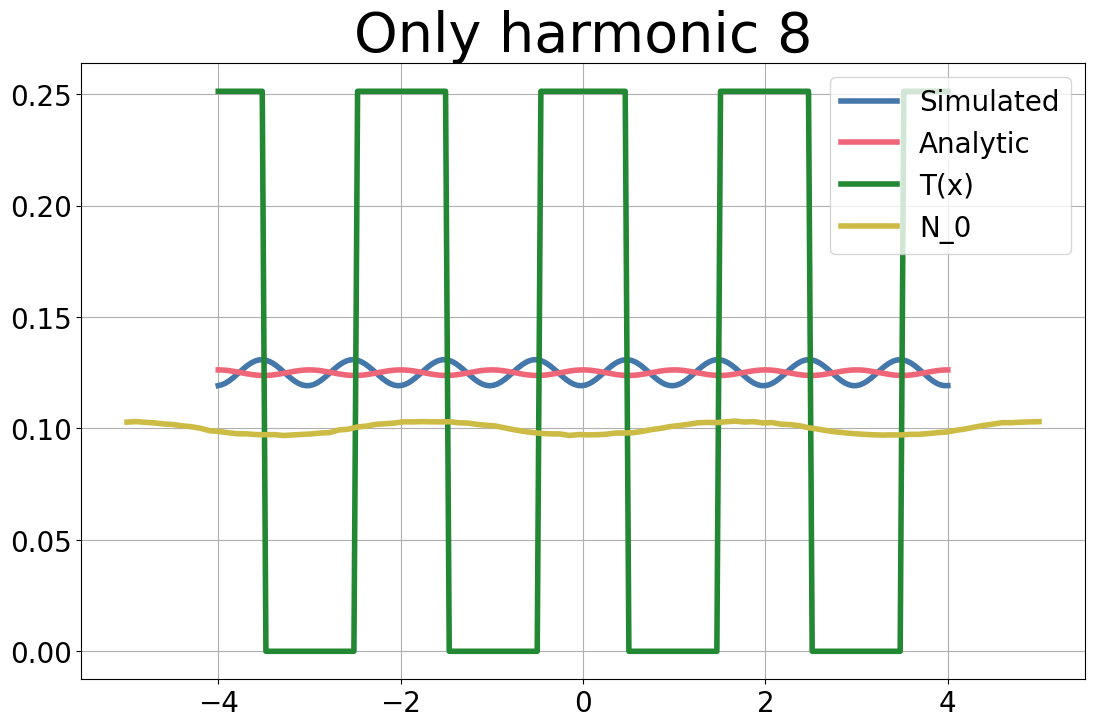

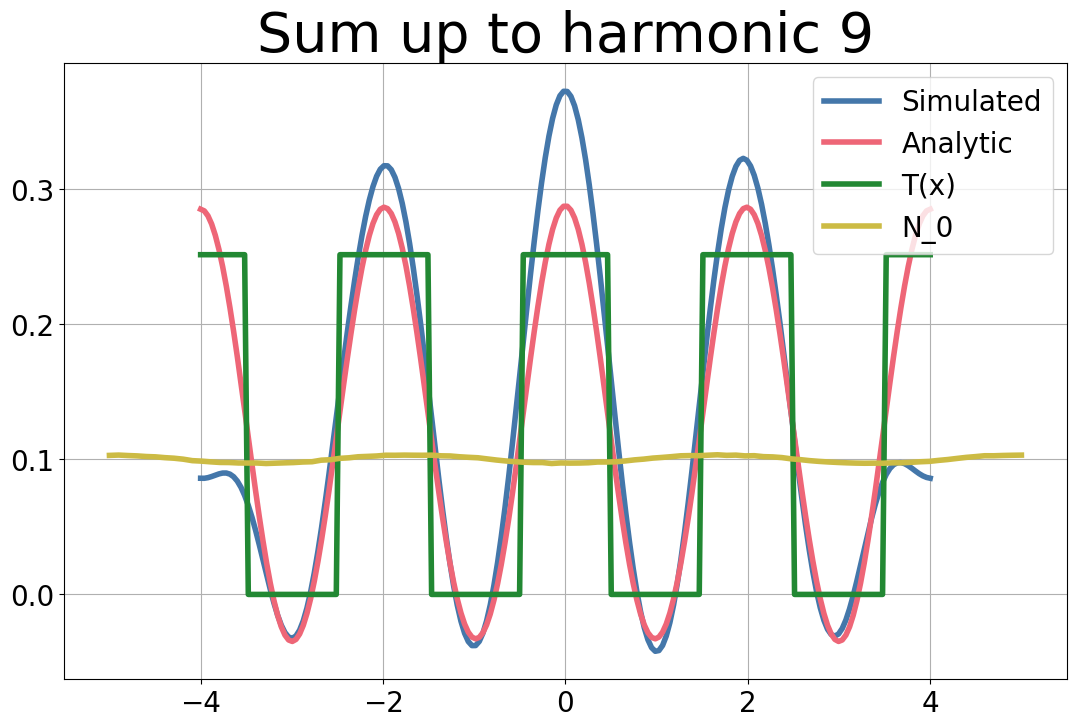

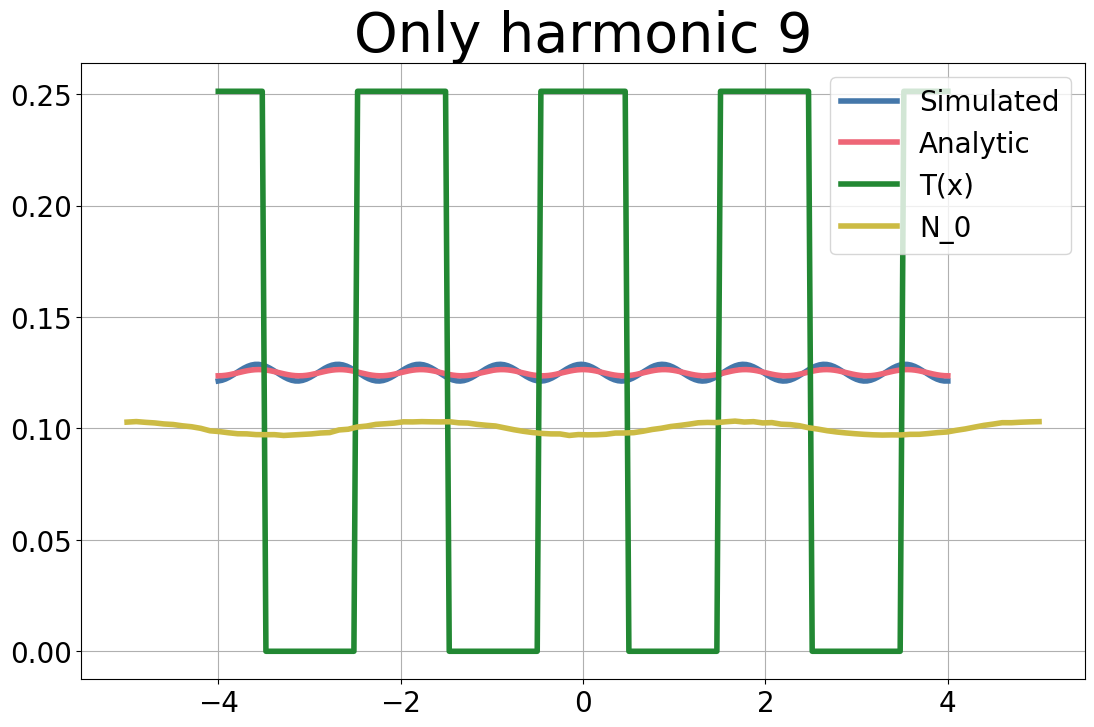

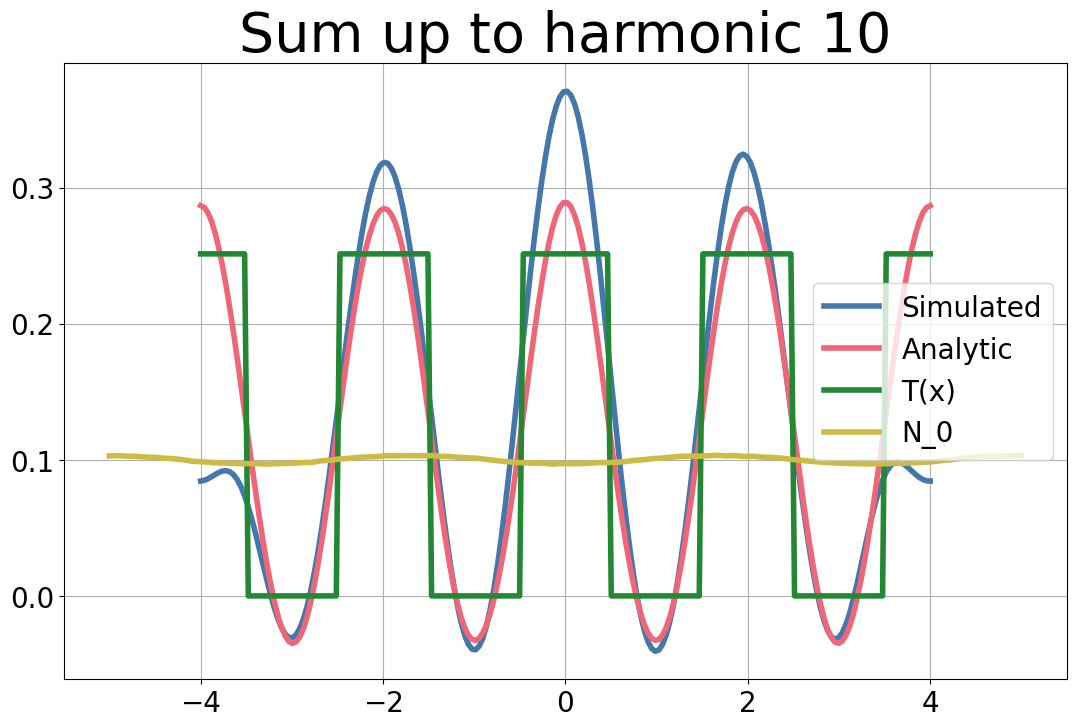

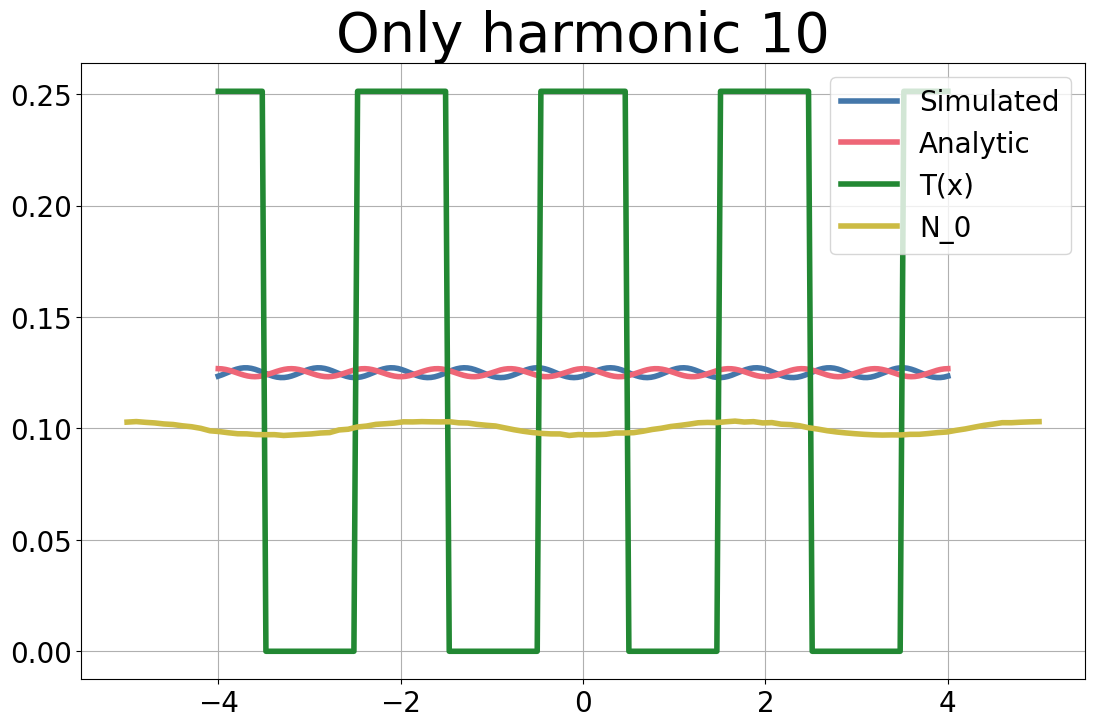

In [30]:
x = np.linspace(-det_x/2,det_x/2,bin_x)
x_mid = x[len(p)//2-4:len(p)//2+4]
x_fine = np.linspace(-det_x/2,det_x/2,200)
fits,errs,guess = [[] for i in range(len(pols))],[[] for i in range(len(pols))],[[] for i in range(len(pols))]
peak_fits,peak_errs,peak_guess = [[] for i in range(len(pols))],[[] for i in range(len(pols))],[[] for i in range(len(pols))]

def fit_pols(pols,plot_fits=True,plot_peaks=True):
    for i,_ in enumerate(pols):
        p = np.mean(pols[i],axis=0)
        guess[i] = np.array([p[len(p)//2],.0,2*np.pi*(i + 1)/res])
        #guess[i] = np.array([p[len(p)//2],2*np.pi*(i + 2)/res,0])
        peak_guess[i] = [-1.,0,p[len(p)//2]]
        p_mid = p[len(p)//2-4:len(p)//2+4]
        fits[i],errs[i] = curve_fit(pol_sc,x,p,p0=guess[i])
        peak_fits[i],peak_errs[i] = curve_fit(quad,x_mid,p_mid,p0=guess[i])
        
        if plot_fits:
            fig = plt.figure(figsize=(plot_width,plot_height))
            plt.title(f'Harm. {i+1}, {round(currents[i+1],2)} amps')
            plt.plot(x,np.mean(pols[i],axis=0),'.',color='C0')
            plt.plot(x,pol_sc(x,*fits[i]),color='C0',label='Fit')
            plt.plot(x,pol_sc(x,*guess[i]),color='C1',label='Guess')
            plt.legend()
            plt.show()
        if plot_peaks:
            fig = plt.figure(figsize=(plot_width,plot_height))
            plt.title(f'Harm. {i+1}, {round(currents[i+1],2)} amps')
            plt.plot(x,np.mean(pols[i],axis=0),'.',color='C0')
            plt.plot(x_mid,quad(x_mid,*peak_fits[i]),color='C0',label='Quad Fit')
            print(f'Const={round(peak_fits[i][2],2)}, Lin={round(peak_fits[i][1],2)}')
            plt.legend()
            plt.show()

def sum_series(x,R,an,bn,nl,nu,a0=1,norm=True):
    """Sums Fourier series from coefficients."""
    assert(len(an) == len(bn)), "Too many an's or bn's!"
    cn = np.array([np.cos(2*np.pi*(i+1)*x/R) for i in range(nl,nu)])
    sn = np.array([np.sin(2*np.pi*(i+1)*x/R) for i in range(nl,nu)])
    tot = a0 + 2*(np.dot(an,cn) + np.dot(bn,sn))
    if norm: tot = tot/simpson(tot,x) #divide by resolution, because a0 = 1/res
    return tot

def get_coeff(x,f,n,R,print_coeff=True):
    """Returns Fourier cosine or sine coefficient."""
    an = simpson(f*np.cos(2*np.pi*n/R*x),x)
    bn = simpson(f*np.sin(2*np.pi*n/R*x),x)
    if print_coeff: print(f'\t a{n} = {round(an,5)}, b{n} = {round(bn,5)}')
    return an,bn

def get_ana(x,f,nl,nu,R,a0=1,norm=True,print_coeff=False):
    """Returns Fourier series up to order n. a0 is given."""
    an,bn = np.zeros(nu-nl),np.zeros(nu-nl)
    if print_coeff: print(f'Analytic Fourier coefficients:')
    for indx,n in enumerate(range(nl,nu)):
        an[indx],bn[indx] = get_coeff(x,f,n+1,R,print_coeff=print_coeff)
    return sum_series(x,R,an,bn,nl,nu,a0=a0,norm=norm), an, bn

def get_N0(x,f,R,norm=True):
    """Returns traditional normalized radiograph (n=0)."""
    return 1/res*simpson(f,x)
    
fit_pols(pols,plot_fits=False,plot_peaks=False)
peak_fits = np.array(peak_fits)
print('Simulated Fourier coefficients:')
for n in range(len(peak_fits[:,2])):
    print(f'\t a{n+1} = {round(peak_fits[n,2],5)}, b{n+1} = {round(peak_fits[n,1],5)}')
    
res_fine = np.linspace(-res/2,res/2,200)

coarse_mask = grating(res_fine,1,1,5,-.5)  #magic number for offset
coarse_mask = coarse_mask/simpson(coarse_mask,res_fine)

images = [sum_series(res_fine,res,peak_fits[:i,2],peak_fits[:i,1],0,i) for i in harms[1:]]
anas = [get_ana(res_fine,coarse_mask,0,i,res)[0] for i in harms[1:-1]] + \
        [get_ana(res_fine,coarse_mask,0,harms[-1],res)[0]]
ana_coeffs = get_ana(res_fine,coarse_mask,0,len(harms)-1,res,print_coeff=True)[1:]

N0 = np.mean(cur_scan[0][0],axis=0)/simpson(np.mean(cur_scan[0][0],axis=0),x)

plot_ps,plot_comps = True,True

for i in harms[:-1]:
    if plot_ps:
        fig = plt.figure(figsize=(plot_width,plot_height))
        plt.title(f'Sum up to harmonic {i+1}')
        plt.plot(res_fine,images[i],linewidth=4,label='Simulated')
        plt.plot(res_fine,anas[i],linewidth=4,label='Analytic')
        plt.plot(res_fine,coarse_mask,linewidth=4,label='T(x)')
        plt.plot(x,N0,linewidth=4,label='N_0')
        plt.legend()
        plt.show()
    
    if plot_comps:
        fig = plt.figure(figsize=(plot_width,plot_height))
        plt.title(f'Only harmonic {i+1}')
        temp_sim = sum_series(res_fine,res,[peak_fits[i,2]],[peak_fits[i,1]],i,i+1)
        temp_ana = get_ana(res_fine,coarse_mask,i,i+1,res)[0]
        plt.plot(res_fine,temp_sim,linewidth=4,label='Simulated')
        plt.plot(res_fine,temp_ana,linewidth=4,label='Analytic')
        plt.plot(res_fine,coarse_mask,linewidth=4,label='T(x)')
        plt.plot(x,N0,linewidth=4,label='N_0')
        plt.legend()
        plt.show()

***
## Solution animations
***

In [170]:
def AER_ani(frame):
    frame += 2
    temp_cos_vals_num = 2*np.array([simple_cos(xpos_finer, *nic_hc_fits[i])[500] for i in range(0,frame)]) - 1
    temp_cos_vals_num = np.insert(temp_cos_vals_num, 0, 1/2, axis=0)
    temp_recon_num = np.asarray([temp_cos_vals_num[0] + np.sum(np.array([temp_cos_vals_num[i]*np.cos(2*np.pi*i/res*x) \
                                for i in range(1,frame)]), axis=0) for x in xpos_finer])
    temp_recon_num = temp_recon_num/np.sum(temp_recon_num)
    ax.set_title(r'Reconstruction up to $N ='+str(frame-1)+'$')
    line.set_ydata(temp_recon_num)
    line.set_label(r'$N=$'+str(frame-1))
    plt.text(-1.6, 5e-3, r'$R_{\mathrm{AER}}=\num{'+str(round(res/frame,2))+r'}\unit{\milli \meter}$', \
             fontdict=dict(fontsize=60), bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=.25'))
    plt.legend()
    
fig = plt.figure(figsize=(plot_width,plot_height))
ax = plt.axes()
ax.plot(xpos_finer, slit_T(xpos_finer, slit_x*1e-3)/np.sum(slit_T(xpos_finer, slit_x*1e-3)), linewidth=8, label='$T(x)$')
line, = ax.plot(xpos_finer, np.zeros(len(xpos_finer)), linewidth=8)
#ax.plot(xpos_finer, np.zeros(len(xpos_finer)), '-', linewidth=5, label='Num. Recon')
#plt.plot(xpos_finer, recon_num/np.sum(recon_num), '--', linewidth=5, label='Num. Recon')
#plt.text(-1.6, 7.75e-3, r'Slit width = $\num{200}\unit{\micro \meter}$', \
#         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=.25'))
ax.set_ylim(-.002, .010)
plt.xlabel('x ' + r'$[\unit{\milli \meter}]$')
plt.ylabel('Transmission')
plt.legend()
plt.grid('on')

F_tot = 6
F_int = 200
FPS = .5
anim = FuncAnimation(fig, AER_ani, frames=F_tot, interval=F_int, repeat=False)
anim.save('Aer_soln_FPS'+str(FPS)+'_frames'+str(F_tot)+'.gif', writer='pillow', fps=FPS)
plt.close()
print('Ding!')


Ding!


In [175]:
def AER_ani(frame):
    frame += 7
    temp_cos_vals_num = 2*np.array([simple_cos(xpos_finer, *nic_hc_fits[i])[500] for i in range(0,frame)]) - 1
    temp_cos_vals_num = np.insert(temp_cos_vals_num, 0, 1/2, axis=0)
    temp_recon_num = np.asarray([temp_cos_vals_num[0] + np.sum(np.array([temp_cos_vals_num[i]*np.cos(2*np.pi*i/res*x) \
                                for i in range(1,frame)]), axis=0) for x in xpos_finer])
    temp_recon_num = temp_recon_num/np.sum(temp_recon_num)
    ax.set_title(r'Reconstruction up to $N ='+str(frame-1)+'$')
    line.set_ydata(temp_recon_num)
    line.set_label(r'$N=$'+str(frame-1))
    plt.text(-1.6, 5e-3, r'$R_{\mathrm{AER}}=\num{'+f"{round(res/frame,2):.2f}"+r'}\unit{\milli \meter}$', \
             fontdict=dict(fontsize=60), bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=.25'))
    plt.legend()
    
fig = plt.figure(figsize=(plot_width,plot_height))
ax = plt.axes()
ax.plot(xpos_finer, slit_T(xpos_finer, slit_x*1e-3)/np.sum(slit_T(xpos_finer, slit_x*1e-3)), linewidth=8, label='$T(x)$')
line, = ax.plot(xpos_finer, np.zeros(len(xpos_finer)), linewidth=8)
#ax.plot(xpos_finer, np.zeros(len(xpos_finer)), '-', linewidth=5, label='Num. Recon')
#plt.plot(xpos_finer, recon_num/np.sum(recon_num), '--', linewidth=5, label='Num. Recon')
#plt.text(-1.6, 7.75e-3, r'Slit width = $\num{200}\unit{\micro \meter}$', \
#         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=.25'))
ax.set_ylim(-.002, .011)
plt.xlabel('x ' + r'$[\unit{\milli \meter}]$')
plt.ylabel('Transmission')
plt.legend()
plt.grid('on')

F_tot = 10
F_int = 200
FPS = .5
anim = FuncAnimation(fig, AER_ani, frames=F_tot, interval=F_int, repeat=False)
anim.save('Aer_soln_higher_FPS'+str(FPS)+'_frames'+str(F_tot)+'.gif', writer='pillow', fps=FPS)
plt.close()
print('Ding!')


Ding!
